<div style="text-align:left; font-size:13pt; font-family:'Tahoma','Verdana',sans-serif; line-height:1.8;">

# 🚗 Vehicle Insurance Claim Prediction  

This project focuses on analyzing a **vehicle insurance dataset** and building predictive models.  
We explore key policy and vehicle-related features to gain insights and create two types of models:  

1. **Classification Model** 🧩  
   - 🎯 Target: `CLAIM_FLAG` (0 = No Claim, 1 = Claim)  
   - Goal: Predict whether a new insurance contract will result in a claim or not.  

2. **Regression Model** 📈  
   - 🎯 Target: `CLAIM_PAID` (numeric value of claim amount)  
   - Goal: Estimate the potential claim amount for policies that have a claim.  

---

## 📊 Dataset Overview  

The dataset includes **policy details, vehicle specifications, and claim information**.  
Key features:  

- `SEX` → Gender of policyholder (0=Male, 1=Female, 2=Organization)  
- `INSR_BEGIN`, `INSR_END`, `EFFECTIVE_YR` → Policy duration and effective year  
- `INSR_TYPE` → Type of insurance  
- `INSURED_VALUE`, `PREMIUM` → Policy financial details  
- `PROD_YEAR`, `SEATS_NUM`, `CARRYING_CAPACITY` → Vehicle specifications  
- `TYPE_VEHICLE`, `CCM_TON`, `MAKE`, `USAGE` → Vehicle type and usage  
- `CLAIM_PAID` → Claim amount (used for regression)  

From these, we will engineer **`CLAIM_FLAG`** as the main target for classification.  

---

## 🎯 Project Goals  

- 🧹 Perform **data cleaning & feature engineering** (handling missing values, ratios, binary flags, etc.).  
- 🔎 Conduct **EDA (Exploratory Data Analysis)** with visualizations to extract insights.  
- 🤖 Train and evaluate **classification models** (e.g., CatBoost, RandomForest) to predict `CLAIM_FLAG`.  
- 📈 Build **regression models** to estimate `CLAIM_PAID` for claim-positive cases.  
- 💡 Provide actionable **business insights** for risk management and insurance pricing.  

---

✨ By combining **analytics and machine learning**, this project aims to improve **risk assessment** and support **data-driven decisions** in vehicle insurance.  

</div>


from IPython.display import HTML
HTML("""
<style>
JupyterLab/Classic
.jp-RenderedHTMLCommon, .jp-OutputArea-output {
  direction: rtl;
  text-align: right;
}
.jp-RenderedHTMLCommon ul, .jp-RenderedHTMLCommon ol {
  direction: rtl;
  padding-right: 1.2em;
}
VS Code Notebook (وب‌ویو) — اگر JupyterLab نبود، این هم کمک می‌کند
div.rendered_html, div.output, .markdown-body {
  direction: rtl !important;
  text-align: right !important;
}
</style>
""")

##### 📦 Importing required libraries for data analysis, visualization, and model building


In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.preprocessing import  OneHotEncoder , OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_absolute_error,precision_recall_curve,average_precision_score, mean_squared_error,r2_score , f1_score, precision_score, recall_score, roc_curve, auc , classification_report, confusion_matrix,classification_report, roc_auc_score, f1_score
from catboost import CatBoostClassifier , Pool
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer , TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.utils import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

##### 📂 Extracting dataset from ZIP and loading insurance data (2011–2018)


In [2]:
zip_path = '../Dataset//Vehicle Insurance Data.zip'
extracted_folder = '../Dataset//Vehicle Insurance Data/'
if not os.path.exists(extracted_folder):
    os.makedirs(extracted_folder)
if not os.path.exists(zip_path):
    print(f"Error: The zip file {zip_path} does not exist.")
else:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

# Load the dataset
df_2001_2014 = pd.read_csv('../Dataset//Vehicle Insurance Data//motor_data11-14lats.csv')
df_2014_2018 = pd.read_csv('../Dataset//Vehicle Insurance Data//motor_data14-2018.csv')
df = pd.concat([df_2001_2014, df_2014_2018], ignore_index=True)

df.head(5)

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
0,0,08-AUG-13,07-AUG-14,08,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
1,0,08-AUG-12,07-AUG-13,08,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
2,0,08-AUG-11,07-AUG-12,08,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
3,0,08-JUL-11,07-AUG-11,08,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
4,0,08-AUG-13,07-AUG-14,08,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43


In [3]:
df.tail(5)

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
802031,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350484,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802032,0,02-FEB-18,01-FEB-19,12,1202,0.0,299.51,5001350489,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802033,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350498,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802034,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350502,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN
802035,0,02-FEB-18,01-FEB-19,12,1202,0.0,294.51,5001350505,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802036 entries, 0 to 802035
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEX                802036 non-null  int64  
 1   INSR_BEGIN         802036 non-null  object 
 2   INSR_END           802036 non-null  object 
 3   EFFECTIVE_YR       802032 non-null  object 
 4   INSR_TYPE          802036 non-null  int64  
 5   INSURED_VALUE      802036 non-null  float64
 6   PREMIUM            802015 non-null  float64
 7   OBJECT_ID          802036 non-null  int64  
 8   PROD_YEAR          801867 non-null  float64
 9   SEATS_NUM          801801 non-null  float64
 10  CARRYING_CAPACITY  603837 non-null  float64
 11  TYPE_VEHICLE       802036 non-null  object 
 12  CCM_TON            802028 non-null  float64
 13  MAKE               802031 non-null  object 
 14  USAGE              802036 non-null  object 
 15  CLAIM_PAID         60145 non-null   float64
dtypes:

In [5]:
df.describe()  # Get a statistical summary of the DataFrame

,SEX,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,CCM_TON,CLAIM_PAID
count,802036.000000,802036.000000,8.020360e+05,8.020150e+05,8.020360e+05,801867.000000,801801.000000,603837.000000,802028.000000,6.014500e+04
mean,0.567092,1201.742123,5.091294e+05,7.406987e+03,5.000453e+09,2004.533970,6.130357,497.877618,3172.698129,2.564802e+05
std,0.644430,0.440322,9.017833e+05,1.352456e+04,3.444165e+05,10.227981,13.403486,3861.218481,3445.455114,1.495336e+06
min,0.000000,1201.000000,0.000000e+00,0.000000e+00,5.000018e+09,1950.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,1201.000000,0.000000e+00,7.557000e+02,5.000160e+09,2000.000000,1.000000,0.000000,200.000000,1.350000e+04
50%,0.000000,1202.000000,1.800000e+05,3.376550e+03,5.000380e+09,2008.000000,4.000000,6.000000,2494.000000,3.463352e+04
75%,1.000000,1202.000000,7.300000e+05,9.643270e+03,5.000718e+09,2012.000000,4.000000,35.000000,4164.000000,1.338690e+05
max,2.000000,1204.000000,2.500000e+08,7.581230e+06,5.001351e+09,2018.000000,199.000000,1000000.000000,20000.000000,1.524458e+08


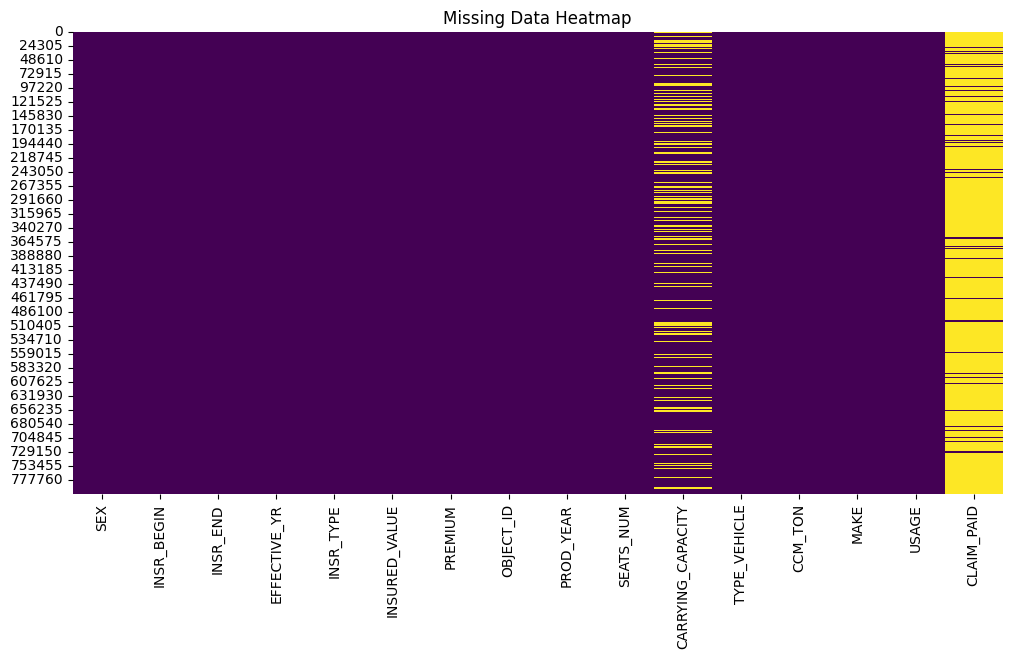

In [6]:
# Function to plot missing data heatmap
def plot_missing_data(data):
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Data Heatmap')
    plt.show()
plot_missing_data(df)

In [7]:
pd.to_datetime(df['INSR_BEGIN'])

0        2013-08-08
1        2012-08-08
2        2011-08-08
3        2011-07-08
4        2013-08-08
            ...    
802031   2018-02-02
802032   2018-02-02
802033   2018-02-02
802034   2018-02-02
802035   2018-02-02
Name: INSR_BEGIN, Length: 802036, dtype: datetime64[ns]

In [8]:
total_len = len(df)
print("Total records:", total_len)
Claim_paid_na = df["CLAIM_PAID"].isna().sum()
print("CLAIM_PAID is NaN:", Claim_paid_na, "records")
print("Percentage of NaN CLAIM_PAID:", (Claim_paid_na / total_len) * 100, "%")

Total records: 802036
CLAIM_PAID is NaN: 741891 records
Percentage of NaN CLAIM_PAID: 92.50096005665581 %


In [9]:
# Convert insurance date columns to datetime format
df["INSR_BEGIN"] = pd.to_datetime(df["INSR_BEGIN"], errors="coerce")
df["INSR_END"]   = pd.to_datetime(df["INSR_END"], errors="coerce")

# Filter the records where CLAIM_PAID is missing (NaN)
missing_claims = df[df["CLAIM_PAID"].isna()]

# Define "today" as one day after the latest insurance end date in the dataset
today = max(df['INSR_END']) + pd.Timedelta(days=1)
print("Today:", today)

# Count the number of missing claims where the policy has already expired
expired = missing_claims[missing_claims["INSR_END"] < today]
print("Expired but NaN Claim:", expired.shape[0])

# Count the number of missing claims where the policy is still active
active = missing_claims[missing_claims["INSR_END"] >= today]
print("Active but NaN Claim:", active.shape[0])

Today: 2019-06-30 00:00:00
Expired but NaN Claim: 741891
Active but NaN Claim: 0


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;"

## 🧹 مدیریت مقادیر گمشده در ستون خسارت (CLAIM_PAID)

- در دیتاست مشاهده شد که ستون **خسارت پرداختی (CLAIM_PAID)** برای حدود **۹۳٪ رکوردها مقدار خالی** دارد.  
- بررسی با استفاده از ستون **تاریخ پایان بیمه‌نامه (INSR_END)** نشان داد که همه‌ی این رکوردها مربوط به **بیمه‌نامه‌های منقضی‌شده** هستند.  
- بنابراین به‌جای حذف این رکوردها از دیتاست، مقادیر خالی باید به **عدد صفر** تغییر یابند؛ زیرا این وضعیت نشان‌دهنده‌ی **عدم وقوع خسارت** است.

---

### 🧹 Handling Missing Values in CLAIM_PAID

- It was observed that the **CLAIM_PAID** column had **missing values for about 93% of the records**.  
- By analyzing the **INSR_END** column, we found that all of these records belong to **expired policies**.  
- Therefore, instead of removing these records, the missing values should be **replaced with 0**, as they represent **no-claim policies**.

</div>


In [10]:
# Fill missing CLAIM_PAID with 0
df['CLAIM_PAID'].fillna(0 , inplace=True)
print("CLAIM_PAID NaN values filled with 0.")

CLAIM_PAID NaN values filled with 0.


In [11]:
# Check for duplicates
print("Number of duplicate records:", df.duplicated().sum())

Number of duplicate records: 198


In [12]:
# Remove duplicates if any
if df.duplicated().sum() > 0:
    print("Removing duplicate records...")
    df = df.drop_duplicates()
    print("Duplicate records removed.")


Removing duplicate records...
Duplicate records removed.


In [13]:
# Check for missing values in the 'MAKE' column

print("Missing values in 'MAKE' column:", df['MAKE'].isna().sum())
print(df['MAKE'].mode()[0])

# Fill missing values in 'MAKE' with 'mode'
df['MAKE'].fillna(df['MAKE'].mode()[0], inplace=True)
print("Missing values in 'MAKE' column filled with mode.")
print("Missing values in 'MAKE' column after filling:", df['MAKE'].isna().sum())



Missing values in 'MAKE' column: 5
TOYOTA
Missing values in 'MAKE' column filled with mode.
Missing values in 'MAKE' column after filling: 0


In [14]:
df['CARRYING_CAPACITY'].value_counts()

CARRYING_CAPACITY
0.0        226669
7.0         62682
10.0        38708
3.0         24058
6.0         23625
            ...  
274.5           1
6630.0          1
10632.0         1
20164.0         1
33.9            1
Name: count, Length: 2766, dtype: int64

In [15]:
df.groupby('MAKE')['CARRYING_CAPACITY'].median()

MAKE
 BEBIEN TANKER    13000.0
 DONG FENG            0.0
 FORKLIFT           380.0
 HERO                 0.0
 MOTOR CYCLE          NaN
                   ...   
ZUMLIN CRANE         50.0
ZUNGSHUN              0.0
ZX TOP              390.0
ZX-TOP              251.0
ZZ                   10.0
Name: CARRYING_CAPACITY, Length: 797, dtype: float64

In [16]:
# Make a copy of the dataframe for modification
df_clean = df.copy()

# Step 1: Calculate median capacity for each brand
median_capacity = df_clean.groupby('MAKE')['CARRYING_CAPACITY'].median()

# Step 2: Define a function for replacement
def fix_capacity(row):
    if pd.isna(row['CARRYING_CAPACITY']) or row['CARRYING_CAPACITY'] == 0:
        return median_capacity[row['MAKE']] if not pd.isna(median_capacity[row['MAKE']]) else np.nan
    else:
        return row['CARRYING_CAPACITY']

# Step 3: Apply the function to the dataframe
df_clean['CARRYING_CAPACITY'] = df_clean.apply(fix_capacity, axis=1)

# Check the result
print(df_clean['CARRYING_CAPACITY'].value_counts().head(20))


CARRYING_CAPACITY
7.0      243653
0.0      209159
10.0      41139
3.0       24116
6.0       23714
400.0     15098
11.0      14163
4.0       13302
1.0       12354
35.0       8445
132.0      6390
150.0      5696
200.0      5457
100.0      5188
5.0        4993
157.0      4873
99.0       4705
62.0       3942
24.0       3637
226.0      3598
Name: count, dtype: int64


In [17]:
df_clean = df.copy()

# Treat 0 as missing
cap = df_clean['CARRYING_CAPACITY'].replace(0, np.nan)

# Group medians only based on valid values (non-zero / non-NaN)
med_tm = (
    df_clean.assign(CARRYING_CAPACITY=cap)
            .groupby(['TYPE_VEHICLE','MAKE'])['CARRYING_CAPACITY']
            .median()
)
med_t  = (
    df_clean.assign(CARRYING_CAPACITY=cap)
            .groupby('TYPE_VEHICLE')['CARRYING_CAPACITY']
            .median()
)
med_m  = (
    df_clean.assign(CARRYING_CAPACITY=cap)
            .groupby('MAKE')['CARRYING_CAPACITY']
            .median()
)
global_med = cap.median()

# Attach medians to rows
df_tmp = df_clean.copy()
df_tmp['med_tm'] = df_tmp.set_index(['TYPE_VEHICLE','MAKE']).index.map(med_tm)
df_tmp['med_t']  = df_tmp['TYPE_VEHICLE'].map(med_t)
df_tmp['med_m']  = df_tmp['MAKE'].map(med_m)

# A stepwise replacement
# Use SEATS_NUM only when meaningful (e.g., > 0)
seats_valid = df_tmp['SEATS_NUM'].where(df_tmp['SEATS_NUM'].fillna(0) > 0)

before_missing = cap.isna().sum()

df_tmp['CARRYING_CAPACITY_IMP'] = (
    cap
    .fillna(df_tmp['med_tm'])
    .fillna(df_tmp['med_t'])
    .fillna(df_tmp['med_m'])
    .fillna(seats_valid)
    .fillna(global_med)
)

after_missing = df_tmp['CARRYING_CAPACITY_IMP'].isna().sum()

# If you want to replace the original column:
df_clean['CARRYING_CAPACITY'] = df_tmp['CARRYING_CAPACITY_IMP'].astype(float)

print(f"Missing/Zero before: {before_missing:,}")
print(f"Missing after: {after_missing:,}")
print("\nTop values after imputation:")
print(df_clean['CARRYING_CAPACITY'].value_counts().head(20))


Missing/Zero before: 424,831
Missing after: 0

Top values after imputation:
CARRYING_CAPACITY
7.0      121796
4.0      114770
3.0       95240
11.0      54601
35.0      52584
10.0      49961
1.0       49680
6.0       29628
24.0      15528
400.0     15140
8.0        9414
99.0       7522
132.0      7163
150.0      6173
200.0      5926
5.0        5759
100.0      5565
157.0      4913
50.0       4665
226.0      3598
Name: count, dtype: int64


In [18]:
df['CCM_TON'].value_counts()

CCM_TON
0.0        88725
4164.0     61300
2494.0     41914
200.0      31018
4334.0     26066
           ...  
9711.0         1
10338.0        1
5660.0         1
18.3           1
4870.0         1
Name: count, Length: 3776, dtype: int64

In [19]:
df_ccm = df.copy()

# 1) Treat zeros as Missing
ccm = df_ccm['CCM_TON'].replace(0, np.nan)

# 2) Group medians based only on valid values
med_tm = (
    df_ccm.assign(CCM_TON=ccm)
          .groupby(['TYPE_VEHICLE','MAKE'])['CCM_TON']
          .median()
)
med_t  = (
    df_ccm.assign(CCM_TON=ccm)
          .groupby('TYPE_VEHICLE')['CCM_TON']
          .median()
)
med_m  = (
    df_ccm.assign(CCM_TON=ccm)
          .groupby('MAKE')['CCM_TON']
          .median()
)
global_med = ccm.median()

# Map medians to rows
tmp = df_ccm.copy()
tmp['med_tm'] = tmp.set_index(['TYPE_VEHICLE','MAKE']).index.map(med_tm)
tmp['med_t']  = tmp['TYPE_VEHICLE'].map(med_t)
tmp['med_m']  = tmp['MAKE'].map(med_m)

before_missing = ccm.isna().sum()

# 3) Stepwise imputation
tmp['CCM_TON_IMP'] = (
    ccm
    .fillna(tmp['med_tm'])
    .fillna(tmp['med_t'])
    .fillna(tmp['med_m'])
    .fillna(global_med)
)

# 4) (Optional but recommended) Cap outliers based on IQR within each TYPE_VEHICLE
def cap_by_iqr(s: pd.Series, k: float = 1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - k*iqr
    hi = q3 + k*iqr
    return s.clip(lower=lo, upper=hi)

tmp['CCM_TON_IMP'] = (
    tmp.groupby('TYPE_VEHICLE', group_keys=False)['CCM_TON_IMP']
       .apply(cap_by_iqr)  # Comment this line if you don’t want to cap
)

# 5) Replace in the final dataframe
df_ccm['CCM_TON'] = tmp['CCM_TON_IMP'].astype(float)
after_missing = df_ccm['CCM_TON'].isna().sum()

print(f"Missing/Zero before: {before_missing:,}")
print(f"Missing after: {after_missing:,}")
print("\nTop values after imputation:")
print(df_ccm['CCM_TON'].value_counts().head(20))


Missing/Zero before: 88,733
Missing after: 0

Top values after imputation:
CCM_TON
2494.00    44429
4164.00    42404
200.00     35859
4334.00    26792
3724.00    23669
2779.00    22631
4570.00    20773
9726.00    20014
1295.00    18665
133.75     17794
8226.00    17452
239.75     17365
2037.00    16422
9720.00    15417
7094.00    13938
3754.00    13373
175.00     12662
1998.00    12373
2985.00    12362
1299.00    12310
Name: count, dtype: int64


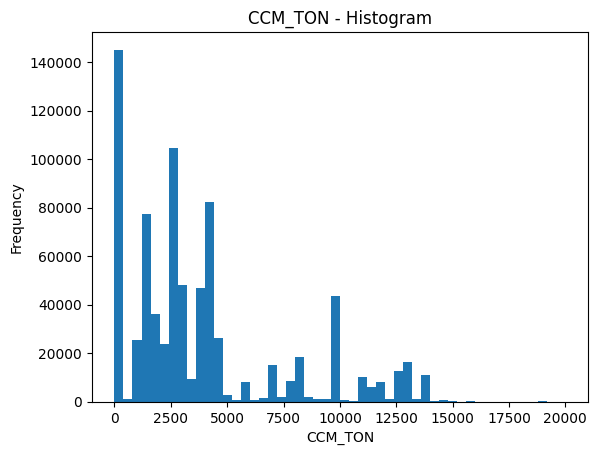

<Figure size 640x480 with 0 Axes>

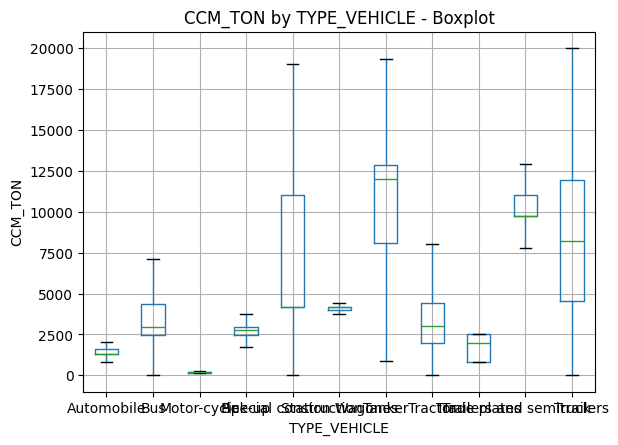

In [20]:
plt.figure()
df_ccm['CCM_TON'].plot(kind='hist', bins=50, title='CCM_TON - Histogram')
plt.xlabel('CCM_TON')
plt.show()

plt.figure()
df_ccm.boxplot(column='CCM_TON', by='TYPE_VEHICLE')
plt.title('CCM_TON by TYPE_VEHICLE - Boxplot')
plt.suptitle('')
plt.xlabel('TYPE_VEHICLE')
plt.ylabel('CCM_TON')
plt.show()

In [21]:
df['PREMIUM'].value_counts()

PREMIUM
347.700      34774
354.600      15822
541.300      12094
4514.500     10857
548.200       8385
             ...  
4286.900         1
4123.564         1
3452.650         1
44618.410        1
53018.730        1
Name: count, Length: 276433, dtype: int64

In [22]:
df[df['PREMIUM'] < 100]

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
628,0,2011-07-08,2011-08-07,01,1202,65000.00,46.00,5000030254,1989.0,4.0,7.0,Pick-up,2446.0,TOYOTA,Own Goods,0.0
834,0,2011-07-08,2011-08-07,03,1201,75000.00,63.45,5000029816,1988.0,0.0,NaN,Automobile,0.0,TOYOTA,Private,0.0
835,0,2011-07-08,2011-08-07,03,1201,75000.00,63.45,5000029818,1985.0,0.0,NaN,Automobile,0.0,TOYOTA,Private,0.0
836,0,2011-07-08,2011-08-07,03,1201,75000.00,63.45,5000029821,1985.0,0.0,NaN,Automobile,0.0,TOYOTA,Private,0.0
1206,0,2011-07-08,2011-08-07,01,1201,84000.00,69.34,5000028655,1992.0,4.0,NaN,Automobile,3431.0,TOYOTA,Private,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779812,0,2018-01-01,2018-12-31,16,1201,101160.00,46.08,5001178071,2012.0,5.0,NaN,Automobile,0.0,NISSAN,Private,0.0
780068,0,2018-01-01,2018-12-31,16,1201,151965.00,69.22,5001180840,2010.0,0.0,NaN,Station Wagones,0.0,MITSUBISHI,Private,0.0
782235,0,2018-01-01,2018-12-31,16,1201,50000.00,22.78,5001180822,2012.0,0.0,NaN,Automobile,0.0,OPEL,Private,0.0
792089,0,2018-01-01,2018-12-31,16,1201,207479.25,84.23,5001219070,2006.0,4.0,NaN,Automobile,1500.0,TOYOTA,Private,0.0


count    8.018170e+05
mean     7.407881e+03
std      1.352564e+04
min      0.000000e+00
25%      7.558500e+02
50%      3.378170e+03
75%      9.643270e+03
max      7.581230e+06
Name: PREMIUM, dtype: float64


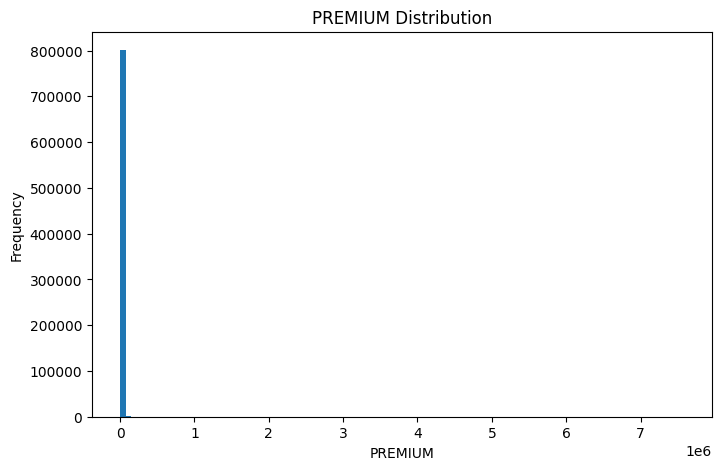

Low cutoff: 215.7  High cutoff: 47868.4
PREMIUM_CLEAN
347.7      34779
354.6      15895
541.3      12097
4514.5     10857
548.2       8427
215.7       8143
47868.4     8025
4521.4      6448
542.0       6042
1949.3      5604
364.2       5123
237.7       4646
1956.2      4184
221.2       3983
541.7       3813
804.2       3275
811.1       3148
804.8       3146
760.8       2898
371.1       2744
Name: count, dtype: int64


In [23]:
df_prem = df.copy()

# Check statistics
print(df_prem['PREMIUM'].describe())

# 1) Plot histogram
plt.figure(figsize=(8,5))
df_prem['PREMIUM'].plot(kind='hist', bins=100, title='PREMIUM Distribution')
plt.xlabel('PREMIUM')
plt.show()

# 2) Identify thresholds for outliers (e.g., 1% and 99%)
low, high = df_prem['PREMIUM'].quantile([0.01, 0.99])
print("Low cutoff:", low, " High cutoff:", high)

# 3) Cap outlier values
df_prem['PREMIUM_CLEAN'] = df_prem['PREMIUM'].clip(lower=low, upper=high)

# 4) Rounding (optional - e.g., to one decimal place)
df_prem['PREMIUM_CLEAN'] = df_prem['PREMIUM_CLEAN'].round(1)

print(df_prem['PREMIUM_CLEAN'].value_counts().head(20))


Cutoff values: -12575.28 22974.4
count    801817.000000
mean       6363.031138
std        7223.519563
min           0.000000
25%         755.850000
50%        3378.170000
75%        9643.270000
max       22974.400000
Name: PREMIUM_CLEAN, dtype: float64


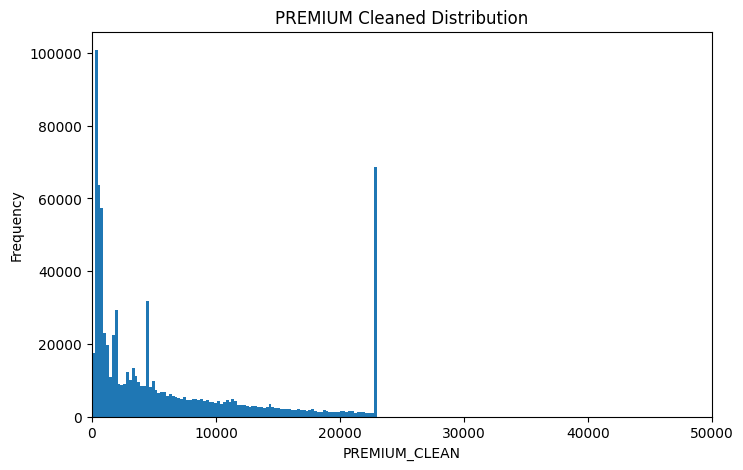

In [24]:
df_prem = df.copy()

# Thresholds with IQR
Q1 = df_prem['PREMIUM'].quantile(0.25)
Q3 = df_prem['PREMIUM'].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

print("Cutoff values:", low, high)

# Cap values
df_prem['PREMIUM_CLEAN'] = df_prem['PREMIUM'].clip(lower=low, upper=high)

# Check new statistics
print(df_prem['PREMIUM_CLEAN'].describe())

# New histogram with axis limit
plt.figure(figsize=(8,5))
df_prem['PREMIUM_CLEAN'].plot(kind='hist', bins=100, title='PREMIUM Cleaned Distribution')
plt.xlim(0, 50000)  # For better visualization
plt.xlabel('PREMIUM_CLEAN')
plt.show()


In [25]:
df_prem['PREMIUM_CLEAN'] = df_prem['PREMIUM_CLEAN'].replace(0, np.nan)
print("تعداد رکورد با NaN:", df_prem['PREMIUM_CLEAN'].isna().sum())

تعداد رکورد با NaN: 50


In [26]:
# Check for missing values in the 'PREMIUM' column
print("Missing values in 'PREMIUM' column:", df['PREMIUM'].isna().sum())
if df['PREMIUM'].isna().sum() < 50:
    # Drop rows with missing PREMIUM values
    df.dropna(subset=['PREMIUM'], inplace=True)
print("Missing values in 'PREMIUM' column after dropping:", df['PREMIUM'].isna().sum())

Missing values in 'PREMIUM' column: 21
Missing values in 'PREMIUM' column after dropping: 0


In [27]:
bins = [0, 1000, 5000, 10000, 23000]  # چون بعد از پاکسازی max ≈ 22974
labels = ['Low', 'Medium', 'High', 'Very High']

df_prem['PREMIUM_BIN'] = pd.cut(df_prem['PREMIUM_CLEAN'], bins=bins, labels=labels, include_lowest=True)

print(df_prem['PREMIUM_BIN'].value_counts())

PREMIUM_BIN
Low          247252
Medium       245309
Very High    194226
High         115001
Name: count, dtype: int64


In [28]:
df['EFFECTIVE_YR'].value_counts()

EFFECTIVE_YR
11    199825
12     86758
15     75474
14     73980
16     68846
       ...  
8R         1
RS         1
IN         1
/1         1
EA         1
Name: count, Length: 151, dtype: int64

In [29]:
# Convert to datetime
df['INSR_BEGIN'] = pd.to_datetime(df['INSR_BEGIN'], errors='coerce')

# Extract year and convert to two-digit format
df['EFFECTIVE_YR'] = df['INSR_BEGIN'].dt.year - 2000

# Keep only valid range 2011 to 2018 → 11 to 18
df['EFFECTIVE_YR'] = df['EFFECTIVE_YR'].apply(lambda x: x if 11 <= x <= 18 else np.nan)

# Check the result
print(df['EFFECTIVE_YR'].value_counts().sort_index())


EFFECTIVE_YR
11     68996
12     91776
13     90921
14    107577
15    115994
16    130390
17    138878
18     57285
Name: count, dtype: int64


In [30]:
# Create a new column 'CLAIM_FLAG' based on 'CLAIM_PAID'
# If CLAIM_PAID > 0, then CLAIM_FLAG = 1, else CLAIM_FLAG = 0
# df['CLAIM_FLAG'] = df['CLAIM_PAID'].apply(lambda x: 1 if x > 0 else 0)
threshold = 0
df["CLAIM_FLAG"] = (df["CLAIM_PAID"] > threshold).astype(int)

print(df["CLAIM_FLAG"].value_counts(normalize=True))

CLAIM_FLAG
0    0.92504
1    0.07496
Name: proportion, dtype: float64


<Axes: ylabel='CLAIM_PAID'>

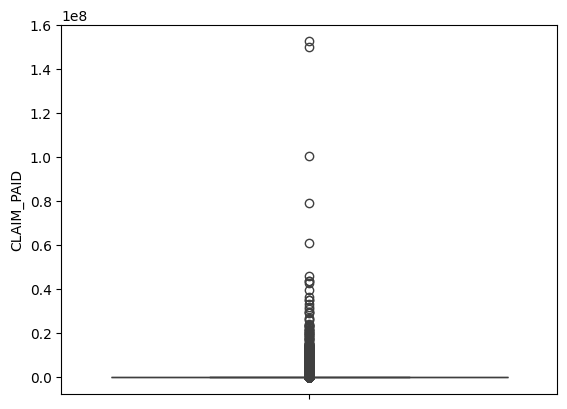

In [31]:
sns.boxplot(df['CLAIM_PAID'])

In [32]:
df['INSR_TYPE'].value_counts()

INSR_TYPE
1202    594031
1201    207451
1204       335
Name: count, dtype: int64

In [33]:
mapping = {1201: "ThirdParty", 1202: "Body", 1204: "Other"}
df['INSR_TYPE'] = df['INSR_TYPE'].map(mapping)

In [34]:
df['INSURED_VALUE'].value_counts()

INSURED_VALUE
0.00          343357
500000.00      13614
400000.00      12572
1500000.00     10848
600000.00      10681
               ...  
1111970.90         1
1432404.01         1
1021300.00         1
828707.25          1
827013.30          1
Name: count, Length: 17435, dtype: int64

In [35]:
df_val = df.copy()

# Replace 0 with NaN
df_val['INSURED_VALUE'] = df_val['INSURED_VALUE'].replace(0, np.nan)

# Calculate thresholds for outliers
Q1 = df_val['INSURED_VALUE'].quantile(0.25)
Q3 = df_val['INSURED_VALUE'].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# Cap values
df_val['INSURED_VALUE'] = df_val['INSURED_VALUE'].clip(lower=low, upper=high)

# Categorization
bins = [0, 200000, 500000, 1000000, df_val['INSURED_VALUE'].max()]
labels = ['Low', 'Medium', 'High', 'Very High']
df_val['INSURED_VALUE_BIN'] = pd.cut(df_val['INSURED_VALUE'], bins=bins, labels=labels, include_lowest=True)

print(df_val['INSURED_VALUE_BIN'].value_counts())


INSURED_VALUE_BIN
Very High    137568
Medium       130947
High         120066
Low           69879
Name: count, dtype: int64


In [36]:
df['INSURED_VALUE'].value_counts()

INSURED_VALUE
0.00          343357
500000.00      13614
400000.00      12572
1500000.00     10848
600000.00      10681
               ...  
1111970.90         1
1432404.01         1
1021300.00         1
828707.25          1
827013.30          1
Name: count, Length: 17435, dtype: int64

Correlation: 0.4321167883360817


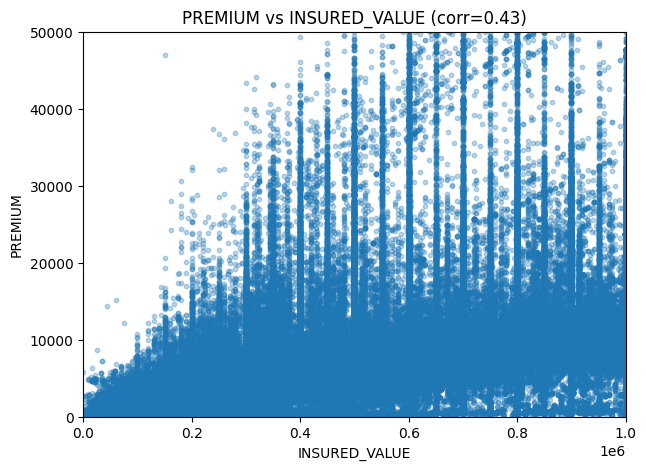

In [37]:
subset = df[(df['INSURED_VALUE']>0) & (df['PREMIUM']>0)]


corr = subset['INSURED_VALUE'].corr(subset['PREMIUM'])
print("Correlation:", corr)

# scatter plot
plt.figure(figsize=(7,5))
plt.scatter(subset['INSURED_VALUE'], subset['PREMIUM'], alpha=0.3, s=10)
plt.xlabel("INSURED_VALUE")
plt.ylabel("PREMIUM")
plt.title(f"PREMIUM vs INSURED_VALUE (corr={corr:.2f})")
plt.xlim(0, 1_000_000)  
plt.ylim(0, 50_000)
plt.show()


In [38]:
df['INSURED_VALUE'].value_counts()

INSURED_VALUE
0.00          343357
500000.00      13614
400000.00      12572
1500000.00     10848
600000.00      10681
               ...  
1111970.90         1
1432404.01         1
1021300.00         1
828707.25          1
827013.30          1
Name: count, Length: 17435, dtype: int64

In [39]:
df['INSURED_VALUE'].value_counts()

INSURED_VALUE
0.00          343357
500000.00      13614
400000.00      12572
1500000.00     10848
600000.00      10681
               ...  
1111970.90         1
1432404.01         1
1021300.00         1
828707.25          1
827013.30          1
Name: count, Length: 17435, dtype: int64

In [40]:
# Treat 0 as missing
df['INSURED_VALUE'] = df['INSURED_VALUE'].replace(0, np.nan)

# 1) Fill with group median (TYPE_VEHICLE, MAKE)
grp_med_tm = df.groupby(['TYPE_VEHICLE','MAKE'])['INSURED_VALUE'].transform('median')
df['INSURED_VALUE'] = df['INSURED_VALUE'].fillna(grp_med_tm)

# 2) Fallback: median of TYPE_VEHICLE
grp_med_t = df.groupby('TYPE_VEHICLE')['INSURED_VALUE'].transform('median')
df['INSURED_VALUE'] = df['INSURED_VALUE'].fillna(grp_med_t)

# 3) Final fallback: overall median
df['INSURED_VALUE'] = df['INSURED_VALUE'].fillna(df['INSURED_VALUE'].median())

# Optional: round to the nearest thousand
df['INSURED_VALUE'] = (np.round(df['INSURED_VALUE']/1000)*1000).astype(float)


In [41]:
df['INSURED_VALUE'].value_counts()

INSURED_VALUE
83000.0       63654
500000.0      45907
300000.0      43532
700000.0      41461
850000.0      32431
              ...  
2305000.0         1
4696000.0         1
6840000.0         1
3883000.0         1
13000000.0        1
Name: count, Length: 3448, dtype: int64

In [42]:
rare = (df['INSURED_VALUE'].value_counts()==100).sum()
print("تعداد مقادیر یکتا با count=2:", rare)
print("درصد:", 100*rare/len(df))

تعداد مقادیر یکتا با count=2: 5
درصد: 0.0006235836855541851


In [43]:
val_counts = df['INSURED_VALUE'].value_counts()
rare_vals = val_counts[val_counts < 100].index

df = df[~df['INSURED_VALUE'].isin(rare_vals)]

print("شکل دیتافریم بعد از حذف:", df.shape)


شکل دیتافریم بعد از حذف: (741881, 17)


In [44]:
df['PROD_YEAR'].value_counts()

PROD_YEAR
2012.0    53630
2014.0    48389
2015.0    42646
2010.0    41593
2013.0    40539
          ...  
1953.0       12
1955.0        5
1954.0        5
1951.0        5
1952.0        3
Name: count, Length: 69, dtype: int64

In [45]:
bins = [0, 2010, 2014, 2018]
labels = ['Old', 'Mid', 'New']
df['PROD_YEAR_BIN'] = pd.cut(df['PROD_YEAR'], bins=bins, labels=labels)

In [46]:
df['PROD_YEAR_BIN'].value_counts()

PROD_YEAR_BIN
Old    484463
Mid    177731
New     79521
Name: count, dtype: int64

In [47]:
df['SEATS_NUM'].value_counts()

SEATS_NUM
4.0      217849
1.0      138808
2.0       92502
3.0       82141
0.0       53527
          ...  
125.0         1
112.0         1
199.0         1
72.0          1
71.0          1
Name: count, Length: 93, dtype: int64

In [48]:
df['SEATS_NUM'] = df['SEATS_NUM'].replace(0, np.nan)
df.loc[df['SEATS_NUM'] > 60, 'SEATS_NUM'] = np.nan
bins = [0,1,4,9,60]
labels = ['Solo','Small','Van','Bus']
df['SEATS_BIN'] = pd.cut(df['SEATS_NUM'], bins=bins, labels=labels)


In [49]:
df['SEATS_NUM'].value_counts()


SEATS_NUM
4.0     217849
1.0     138808
2.0      92502
3.0      82141
11.0     39923
8.0      23994
5.0      12712
24.0     11789
6.0       8459
7.0       6038
14.0      5391
9.0       5081
12.0      4898
15.0      4504
44.0      3067
28.0      2219
10.0      2135
29.0      2035
60.0      1822
27.0      1385
25.0      1216
13.0      1212
45.0      1134
22.0       963
16.0       842
50.0       840
30.0       639
32.0       591
20.0       497
26.0       395
46.0       308
21.0       283
23.0       252
19.0       245
55.0       196
43.0       196
37.0       184
18.0       182
59.0       130
33.0       124
40.0       122
31.0       113
51.0       108
47.0       102
17.0        99
36.0        83
54.0        79
35.0        69
34.0        57
39.0        54
48.0        42
58.0        35
49.0        27
38.0        23
53.0        22
56.0        22
42.0        18
57.0        17
52.0        14
41.0        11
Name: count, dtype: int64

In [50]:
df['TYPE_VEHICLE'].value_counts()

TYPE_VEHICLE
Motor-cycle                  142187
Truck                        137930
Pick-up                      131691
Automobile                   120177
Bus                          100188
Station Wagones               50127
Trailers and semitrailers     34337
Special construction           9364
Tanker                         8502
Tractor                        7360
Trade plates                     18
Name: count, dtype: int64

In [51]:
min_count = 1000
type_counts = df['TYPE_VEHICLE'].value_counts()
rare_types = type_counts[type_counts < min_count].index

df['TYPE_VEHICLE'] = df['TYPE_VEHICLE'].replace(rare_types, 'Other')

In [52]:
df['CARRYING_CAPACITY'].value_counts()

CARRYING_CAPACITY
0.0        216173
7.0         56480
10.0        35992
3.0         23948
6.0         20679
            ...  
12600.0         1
97.3            1
8145.0          1
7770.0          1
10650.0         1
Name: count, Length: 2684, dtype: int64

In [53]:
df['CARRYING_CAPACITY'] = df['CARRYING_CAPACITY'].replace(0, np.nan)
q_high = df['CARRYING_CAPACITY'].quantile(0.99)   # آستانه 99 درصد
df['CARRYING_CAPACITY'] = np.clip(df['CARRYING_CAPACITY'], None, q_high)


bins = [0, 10, 100, 1000, df['CARRYING_CAPACITY'].max()]
labels = ['Small','Medium','Large','Very Large']
df['CARRYING_BIN'] = pd.cut(df['CARRYING_CAPACITY'], bins=bins, labels=labels)


In [54]:
df['CARRYING_CAPACITY'].value_counts()

CARRYING_CAPACITY
7.0        56480
10.0       35992
3.0        23948
6.0        20679
11.0       13792
           ...  
46.4           1
2494.0         1
343.5          1
50.6           1
18784.0        1
Name: count, Length: 2577, dtype: int64

In [55]:
len(df)

741881

In [56]:
val_counts = df['CARRYING_CAPACITY'].value_counts()
rare_vals = val_counts[val_counts < 1000].index

df['CARRYING_CAPACITY'] = df['CARRYING_CAPACITY'].replace(rare_vals, np.nan)

In [57]:
len(df)

741881

Numeric columns: ['SEX', 'EFFECTIVE_YR', 'INSURED_VALUE', 'PREMIUM', 'OBJECT_ID', 'PROD_YEAR', 'SEATS_NUM', 'CARRYING_CAPACITY', 'CCM_TON', 'CLAIM_PAID', 'CLAIM_FLAG']
Categorical columns: ['INSR_TYPE', 'TYPE_VEHICLE', 'MAKE', 'USAGE']


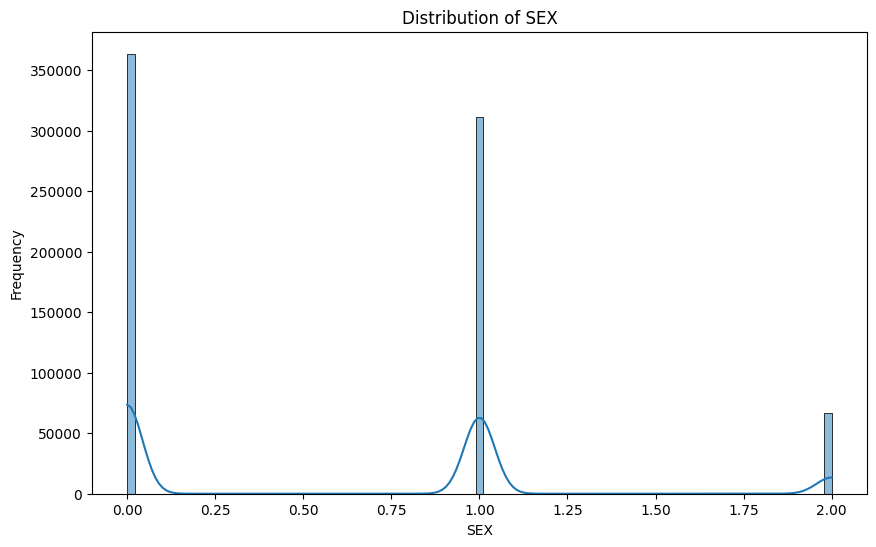

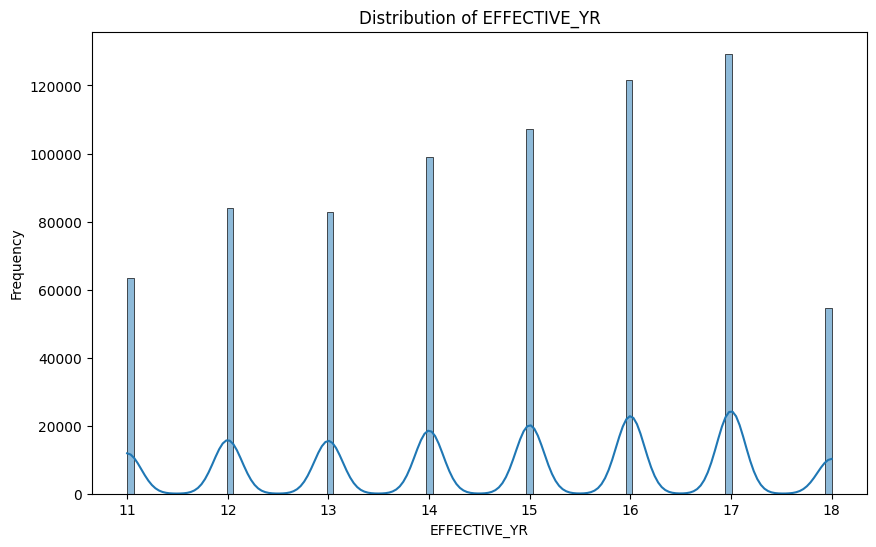

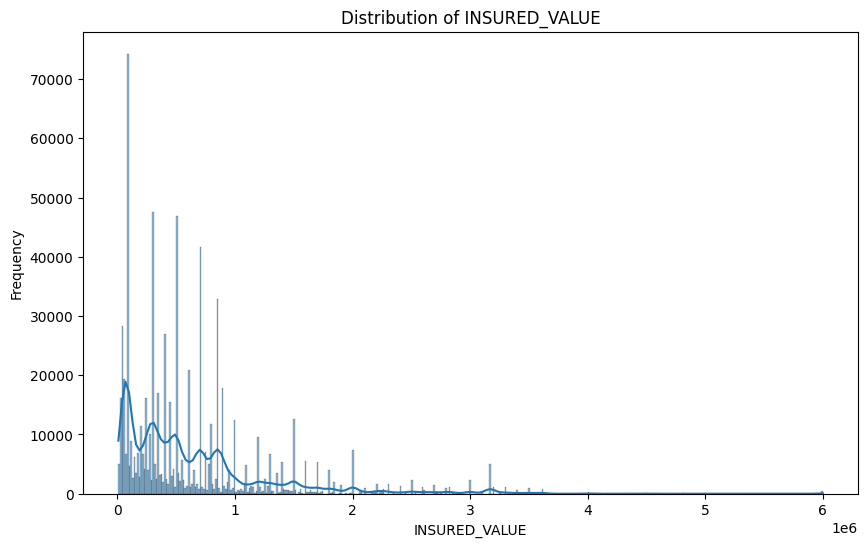

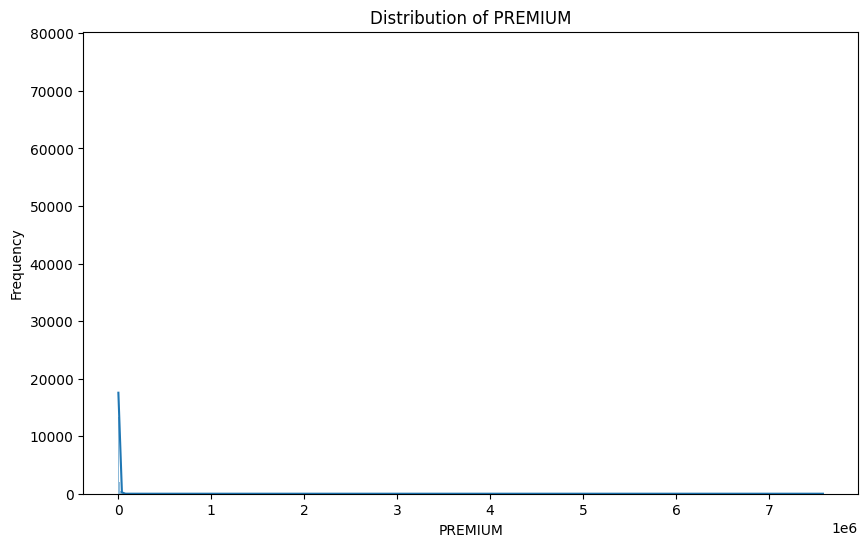

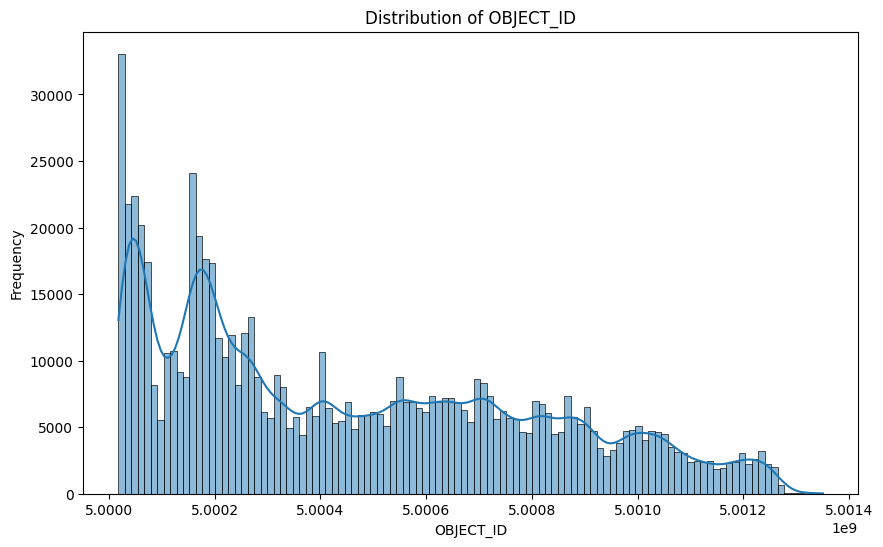

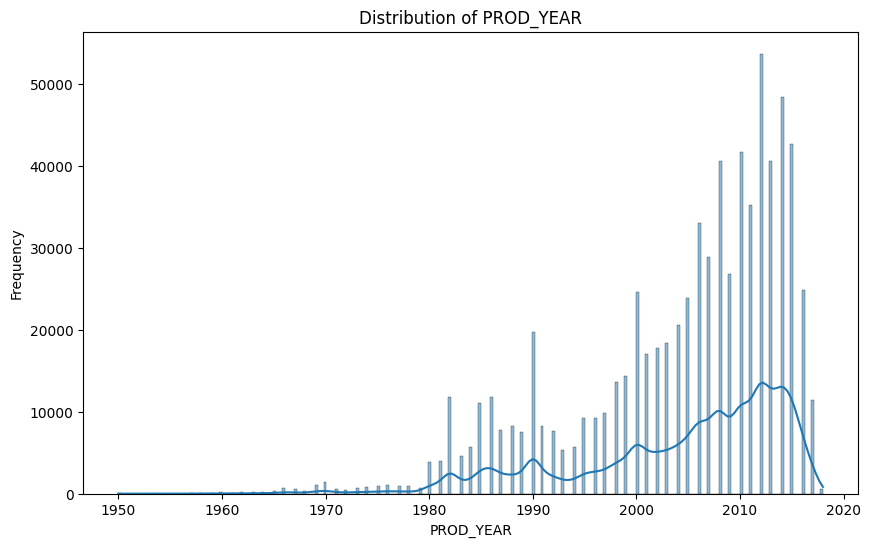

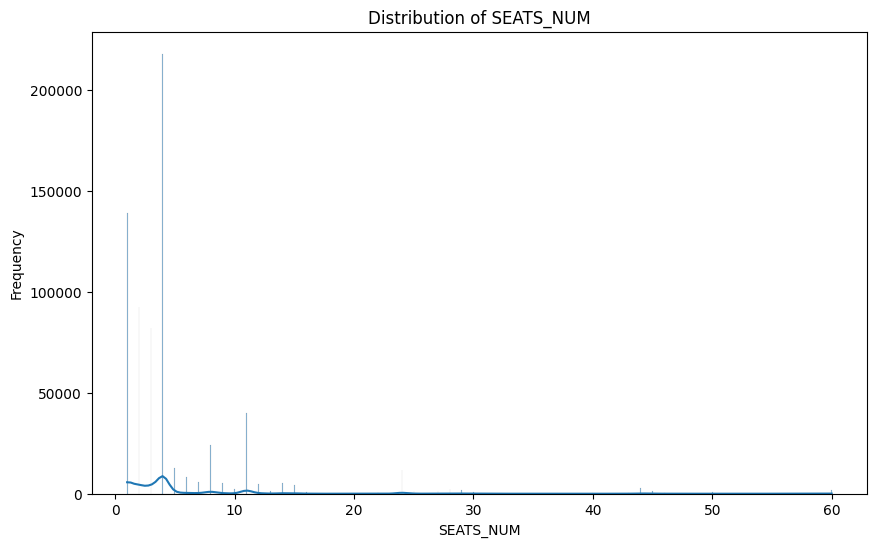

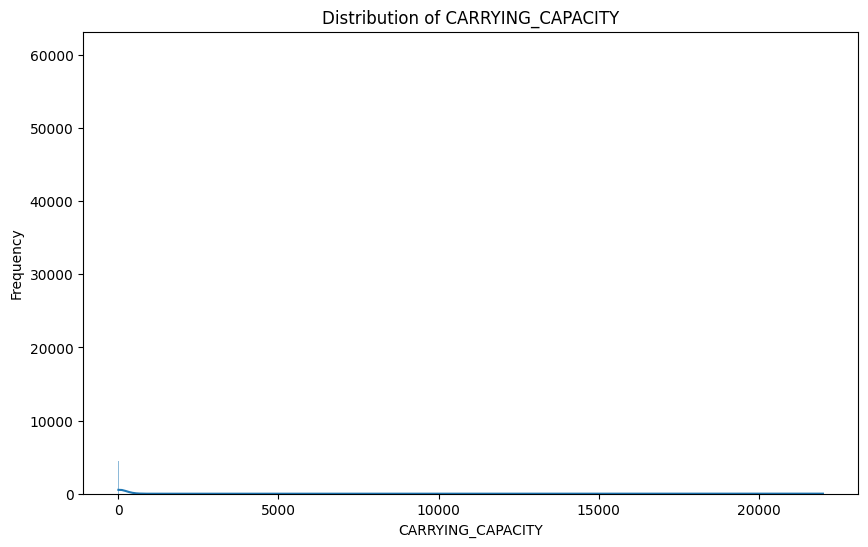

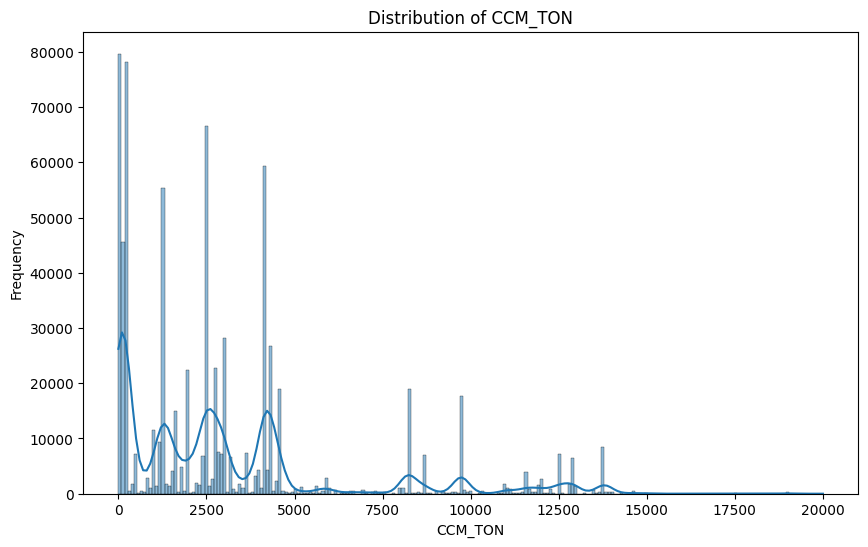

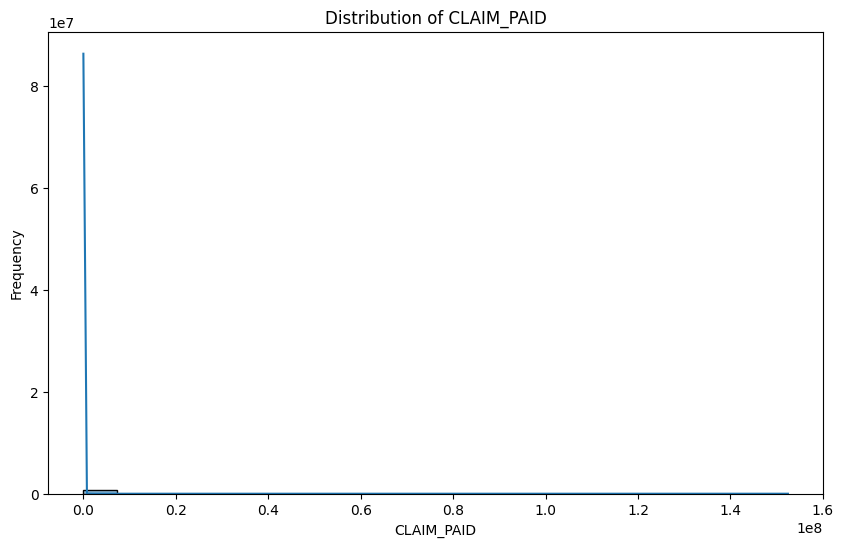

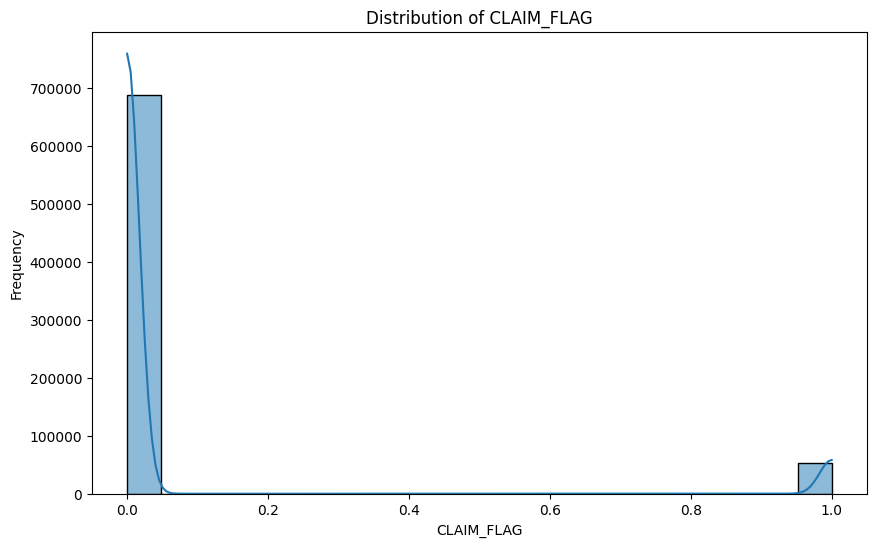

In [58]:
def numeric_columns(df):
    """
    Return a list of numeric columns in the DataFrame.
    """
    return [col for col in df.columns if df[col].dtype in [np.int64, np.float64]]

def categorical_columns(df):
    """
    Return a list of categorical columns in the DataFrame.
    """
    return [col for col in df.columns if df[col].dtype == 'object']

numeric_cols = numeric_columns(df)
print("Numeric columns:", numeric_cols)
categorical_cols = categorical_columns(df)
print("Categorical columns:", categorical_cols)

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
# Example usage of the plot_numeric_distribution function
if numeric_cols:
    for col in numeric_cols:

        plot_numeric_distribution(df, col)

In [59]:
# Check the unique values in column SEX
unique_values = df['SEX'].nunique()
print("Unique values in 'SEX':", unique_values)

# Count the occurrences of each unique value in the 'SEX' column
value_counts = df['SEX'].value_counts()
print("Value counts in 'SEX':\n", value_counts)

Unique values in 'SEX': 3
Value counts in 'SEX':
 SEX
0    363689
1    311614
2     66578
Name: count, dtype: int64


In [60]:
# Count records by SEX
print("Counts by SEX:\n", df["SEX"].value_counts(), "\n")

# Compare average premium & claims
sex_summary = df.groupby("SEX").agg({
    "PREMIUM": "mean",
    "INSURED_VALUE": "mean",
    "CLAIM_PAID": "mean",
    "CLAIM_FLAG": "mean"
}).rename(columns={"CLAIM_FLAG": "Claim_Rate"})

print("Summary by SEX:\n", sex_summary, "\n")

# Check usage distribution for SEX=2
usage_dist = df[df["SEX"]==2]["USAGE"].value_counts(normalize=True) * 100
print("Usage distribution for SEX=2:\n", usage_dist, "\n")

# Check top vehicle makes for SEX=2
make_dist = df[df["SEX"]==2]["MAKE"].value_counts().head(10)
print("Top 10 makes for SEX=2:\n", make_dist)


Counts by SEX:
 SEX
0    363689
1    311614
2     66578
Name: count, dtype: int64 

Summary by SEX:
          PREMIUM  INSURED_VALUE    CLAIM_PAID  Claim_Rate
SEX                                                      
0    7225.919230  786157.233240  13251.169116    0.087528
1    6432.421326  508517.945278  23448.496299    0.054799
2    5705.952171  468574.183664  16309.299834    0.059584 

Usage distribution for SEX=2:
 USAGE
Private                   33.802457
Fare Paying Passengers    23.964373
General Cartage           20.111749
Taxi                      13.213073
Own Goods                  4.746313
Others                     1.882003
Own service                1.031872
Car Hires                  0.566253
Learnes                    0.360479
Special Construction       0.165220
Agricultural Any Farm      0.115654
Agricultural Own Farm      0.033044
Ambulance                  0.007510
Name: proportion, dtype: float64 

Top 10 makes for SEX=2:
 MAKE
TOYOTA       27188
ISUZU         8649

In [61]:
# میانگین تعداد صندلی برای هر گروه
print("Average SEATS_NUM by SEX:")
print(df.groupby("SEX")["SEATS_NUM"].mean())

print("\nUsage distribution by SEX:")
# توزیع استفاده (USAGE) برای هر SEX
for sex in df["SEX"].unique():
    usage_dist = df[df["SEX"] == sex]["USAGE"].value_counts(normalize=True) * 100
    print(f"\nSEX={sex}")
    print(usage_dist.head(10))  # فقط 10 مورد اول برای خلاصه بودن


Average SEATS_NUM by SEX:
SEX
0    5.120684
1    5.228765
2    5.562361
Name: SEATS_NUM, dtype: float64

Usage distribution by SEX:

SEX=0
USAGE
Own Goods                 48.121884
Private                   27.881514
Own service               10.269214
General Cartage            6.603719
Fare Paying Passengers     2.741078
Agricultural Own Farm      1.305786
Special Construction       1.169956
Ambulance                  0.745692
Agricultural Any Farm      0.421514
Learnes                    0.270836
Name: proportion, dtype: float64

SEX=1
USAGE
Fare Paying Passengers    29.271791
General Cartage           26.062693
Private                   20.775382
Taxi                      12.045993
Own Goods                  5.744607
Own service                2.305416
Others                     2.145282
Learnes                    0.539770
Car Hires                  0.512493
Agricultural Any Farm      0.284326
Name: proportion, dtype: float64

SEX=2
USAGE
Private                   33.802457
Fare Pa

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 👥 تحلیل متغیر جنسیت (SEX)

- نرخ خسارت برای **مردان (SEX=0)** به‌طور معناداری بالاتر از **زنان (SEX=1)** است.  
  این موضوع با واقعیت‌های بیمه‌ای همخوانی دارد؛ زیرا مردان معمولاً بیشتر رانندگی می‌کنند، در مشاغل مرتبط با رانندگی حضور بیشتری دارند و رفتار رانندگی پرریسک‌تری نشان می‌دهند.  

- در نگاه اول هنگام بررسی ستون **SEX** متوجه حضور مقدار **۲** شدم که مشکوک به نظر می‌رسید، چراکه انتظار می‌رفت این متغیر فقط شامل مقادیر **۰=مرد** و **۱=زن** باشد.  
  فرض اولیه این بود که این داده‌ها مفقود یا خراب شده‌اند. اما پس از تحلیل دقیق‌تر (بررسی توزیع **USAGE** و نرخ خسارت)، مشخص شد که مقدار **۲ در واقع نمایانگر سازمان‌ها/شرکت‌ها** است و نه داده‌ی اشتباه. بنابراین این دسته‌بندی **معنادار و معتبر** بوده و باید در تحلیل‌ها لحاظ شود.  

---

### 👥 Gender Variable Analysis (SEX)

- The claim rate for **males (SEX=0)** is significantly higher than for **females (SEX=1)**.  
  This aligns with insurance industry observations, as men tend to drive more frequently, are more represented in driving-related occupations, and often exhibit riskier driving behavior compared to women.  

- At first glance, while exploring the **SEX** column, the presence of the value **2** seemed suspicious, since this variable is typically expected to contain only **0=Male** and **1=Female**.  
  My initial assumption was that it could represent missing or corrupted data. However, after deeper analysis (examining **USAGE distribution** and **CLAIM_RATE**), it became clear that **value 2 actually represents organizations/companies** rather than erroneous records. Hence, this category is **meaningful and valid** for further analysis.  

</div>


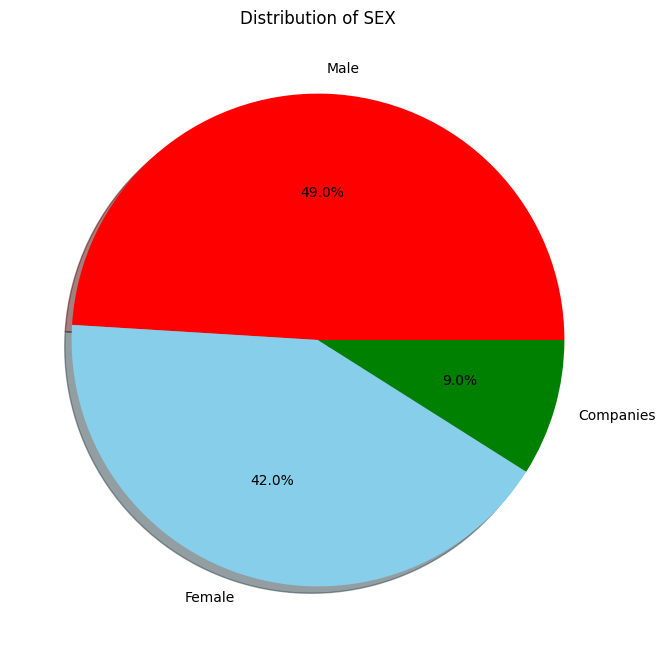

In [62]:
df['SEX'] = df['SEX'].map({0:'Male' , 1:'Female' , 2: 'Companies'})

sex_m = df[df['SEX'] == 'Male']['SEX'].count()
sex_f = df[df['SEX'] == 'Female']['SEX'].count()
sex_c = df[df['SEX'] == 'Companies']['SEX'].count()
plt.figure(figsize=(8, 8))
plt.pie(x=[sex_m, sex_f, sex_c], labels=['Male', 'Female', 'Companies'],colors= ['red' , 'skyblue','green'],radius=1, shadow=True, autopct="%1.1f%%")
plt.title("Distribution of SEX")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


👨 **مردها (Male):** بیشترین سهم رو دارن با حدود **49.0%** → یعنی بیشتر از نیمی از بیمه‌گذاران مرد هستن.  
👩 **زن‌ها (Female):** حدود **42.0%** → سهم بزرگی دارن ولی کمتر از مردها.  
🏢 **شرکت‌ها (Companies):** فقط **9.0%** → نشون میده سهم سازمانی/شرکتی خیلی کمتر از افراد حقیقیه.  

### 📌 نکات کلیدی (Insights):  
- بازار اصلی بیمه وسایل نقلیه در دست **افراد حقیقی (زن و مرد)** است، نه شرکت‌ها.  
- 👨 مردان بیشترین سهم رو دارن → احتمالاً به دلیل مالکیت بیشتر خودرو یا الگوهای استفاده.  
- 👩 زنان سهم قابل توجهی دارن (~42%) → یک بازار مهم و رو به رشد برای هدف‌گذاری بیمه.  
- 🏢 بخش شرکتی کوچک ولی با **پتانسیل رشد** (مثل بیمه‌های ناوگان حمل‌ونقل).  

</div>

---

👨 **Males:** Largest group with about **49.0%** → More than half of the insured clients are men.  
👩 **Females:** Around **42.0%** → A significant share but smaller than males.  
🏢 **Companies:** Only **9.0%** → Organizational customers represent a much smaller portion of the market.  

### 📌 Key Insights:  
- The insurance market is dominated by **individual customers (male & female)**, not companies.  
- 👨 Males form the majority → likely due to higher vehicle ownership or usage patterns.  
- 👩 Females are a strong segment (~42%) → showing **considerable market potential**.  
- 🏢 Corporate clients are underrepresented but could be a **growth opportunity**, especially for fleet/business insurance packages.  


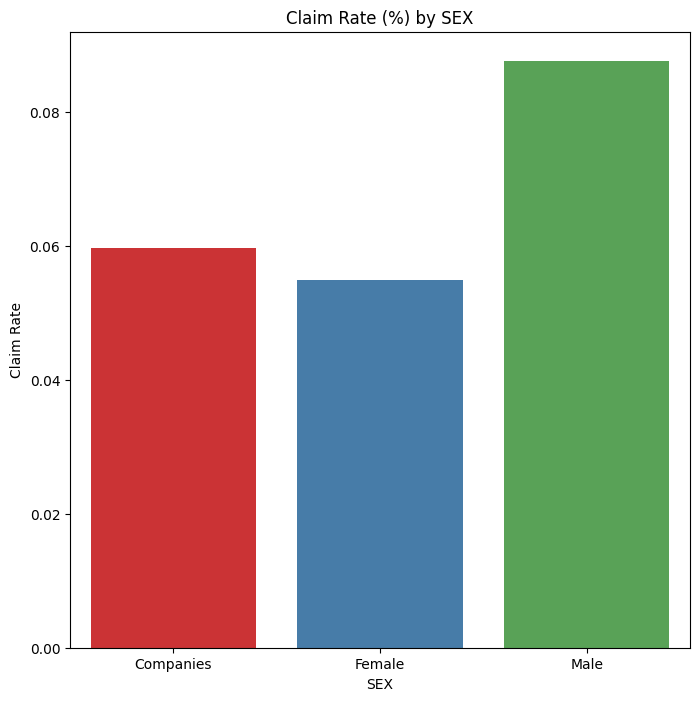

In [63]:
claim_rate = df.groupby('SEX')['CLAIM_FLAG'].mean().reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='SEX', y='CLAIM_FLAG', data=claim_rate, palette='Set1')
plt.title("Claim Rate (%) by SEX")
plt.ylabel("Claim Rate")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


👨 **مردان (Male):** بیشترین نرخ خسارت با حدود %9+ → نشان‌دهنده **ریسک بالاتر** برای شرکت بیمه.  

👩 **زنان (Female):** کمترین نرخ خسارت با حدود %5.5 → مشتریانی با **سودآوری بیشتر** برای بیمه‌گر.  

🏢 **شرکت‌ها (Companies):** نرخ خسارت متوسط حدود %6 → با وجود سهم بازار کوچک، می‌توانند بازار **پایدار و قابل توسعه** باشند.  

✨ **این یعنی:**  
- 👨 مردان → بیشترین سهم + بیشترین خسارت → نیاز به **مدیریت ریسک** و شاید **تعرفه‌های بالاتر**.  
- 👩 زنان → سهم قابل توجه + خسارت کمتر → فرصت عالی برای طراحی **طرح‌های تشویقی و تخفیفی**.  
- 🏢 شرکت‌ها → سهم کوچک + ریسک متوسط → پتانسیل رشد در **بیمه‌های سازمانی و ناوگان**.  

</div>

---


👨 **Males:** Highest claim rate (9%+) → Represent the **riskiest group** for insurers.  

👩 **Females:** Lowest claim rate (~5.5%) → A **profitable and attractive** customer segment.  

🏢 **Companies:** Moderate claim rate (~6%) → Though small in share, they offer **stable future potential**, especially in fleet insurance.  

✨ **This means:**  
- 👨 Males → High share + High claims → Require **risk-based pricing** or stricter underwriting.  
- 👩 Females → Significant share + Low claims → Great opportunity for **discounts & loyalty programs**.  
- 🏢 Companies → Small share + Medium risk → Potential growth in **corporate packages**.  


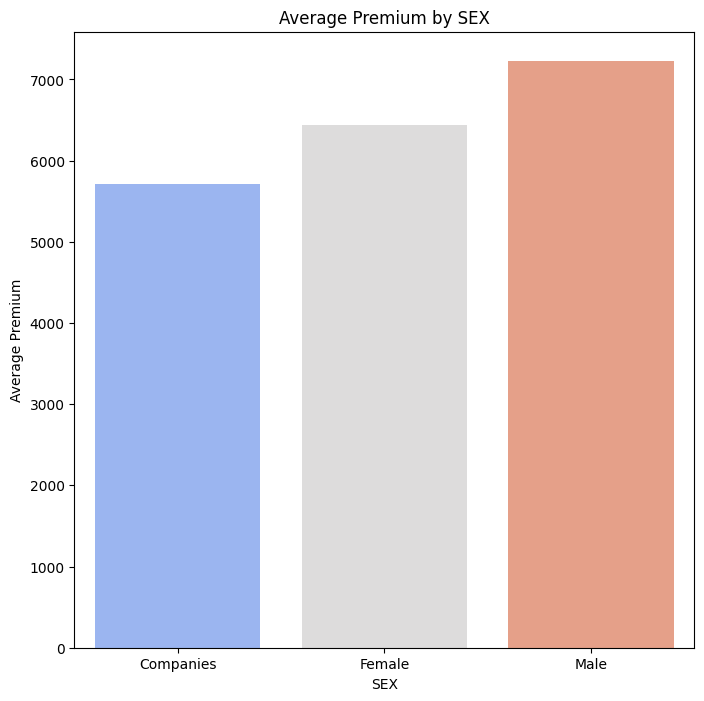

In [64]:
premium_by_sex = df.groupby('SEX')['PREMIUM'].mean().reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='SEX', y='PREMIUM', data=premium_by_sex, palette='coolwarm')
plt.title("Average Premium by SEX")
plt.ylabel("Average Premium")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">
 

👨 **مردان (Male):** بالاترین میانگین حق‌بیمه، حدود **7200** → نشان‌دهنده ریسک بالاتر یا استفاده بیشتر از خدمات بیمه‌ای.  

👩 **زنان (Female):** میانگین حق‌بیمه حدود **6400** → کمتر از مردان ولی بیشتر از شرکت‌ها.  

🏢 **شرکت‌ها (Companies):** پایین‌ترین میانگین حق‌بیمه، حدود **5700** → سهم کوچک و ریسک متوسط.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان با وجود بیشترین خسارت (نمودار قبلی)، بالاترین حق‌بیمه رو هم پرداخت می‌کنن → این موضوع با **مدل قیمت‌گذاری ریسک‌محور** سازگاره.  
- 👩 زنان با نرخ خسارت کمتر و حق‌بیمه متوسط → **سودآورترین گروه** برای شرکت بیمه.  
- 🏢 شرکت‌ها حق‌بیمه پایین‌تری پرداخت می‌کنن → احتمالاً به خاطر قراردادهای گروهی یا تخفیف‌های سازمانی.  

</div>

---



👨 **Males:** Highest average premium (~7200) → Indicates higher risk or higher insurance usage.  

👩 **Females:** Medium premium (~6400) → Lower than males but higher than companies.  

🏢 **Companies:** Lowest average premium (~5700) → Possibly due to bulk contracts or organizational discounts.  

### 📌 Key Insights:  
- 👨 Males pay the highest premiums, aligned with their **higher claim rates** (previous chart).  
- 👩 Females show **lower risk + medium premiums**, making them the **most profitable group**.  
- 🏢 Companies pay the least, likely benefiting from **corporate discounts or fleet packages**.  


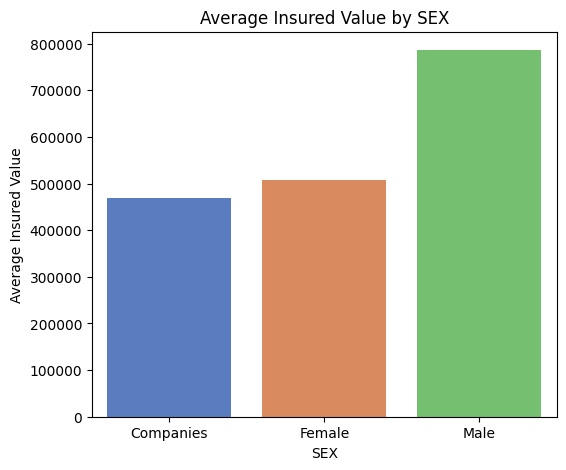

In [65]:
insured_value_by_sex = df.groupby('SEX')['INSURED_VALUE'].mean().reset_index()

plt.figure(figsize=(6,5))
sns.barplot(x='SEX', y='INSURED_VALUE', data=insured_value_by_sex, palette='muted')
plt.title("Average Insured Value by SEX")
plt.ylabel("Average Insured Value")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


👨 **مردان (Male):** بالاترین میانگین ارزش بیمه‌شده با حدود **700,000+** → یعنی خودروها یا دارایی‌های تحت پوشش مردان معمولاً **ارزشمندتر** هستند.  

👩 **زنان (Female):** میانگین ارزش بیمه‌شده حدود **500,000** → کمتر از مردان اما بیشتر از شرکت‌ها.  

🏢 **شرکت‌ها (Companies):** کمترین میانگین ارزش بیمه‌شده، حدود **470,000** → نشان‌دهنده این که اغلب دارایی‌های بیمه‌شده توسط شرکت‌ها **کم‌ارزش‌تر یا اقتصادی‌تر** هستند.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان علاوه بر بیشترین سهم بازار، خودروهایی با ارزش بالاتر دارند → ریسک بیمه‌گر در این گروه **سنگین‌تر** است.  
- 👩 زنان با ارزش بیمه‌شده متوسط و نرخ خسارت پایین (نمودار قبل) → گروهی **کم‌ریسک و سودآور** محسوب می‌شوند.  
- 🏢 شرکت‌ها با پایین‌ترین ارزش بیمه‌شده → احتمالاً بیشتر در بخش خودروهای خدماتی یا اقتصادی حضور دارند.  

</div>

---


👨 **Males:** Highest average insured value (~700,000+) → Men typically insure **more valuable assets/vehicles**.  

👩 **Females:** Medium insured value (~500,000) → Less than males but higher than companies.  

🏢 **Companies:** Lowest insured value (~470,000) → Suggests that corporate-insured vehicles are mostly **economical or utilitarian**.  

### 📌 Key Insights:  
- 👨 Males own higher-value vehicles → leading to **greater risk exposure** for insurers.  
- 👩 Females show **moderate insured values + low claim rates**, making them a **profitable and stable segment**.  
- 🏢 Companies insure lower-value vehicles → likely focusing on **fleet or service cars**.  


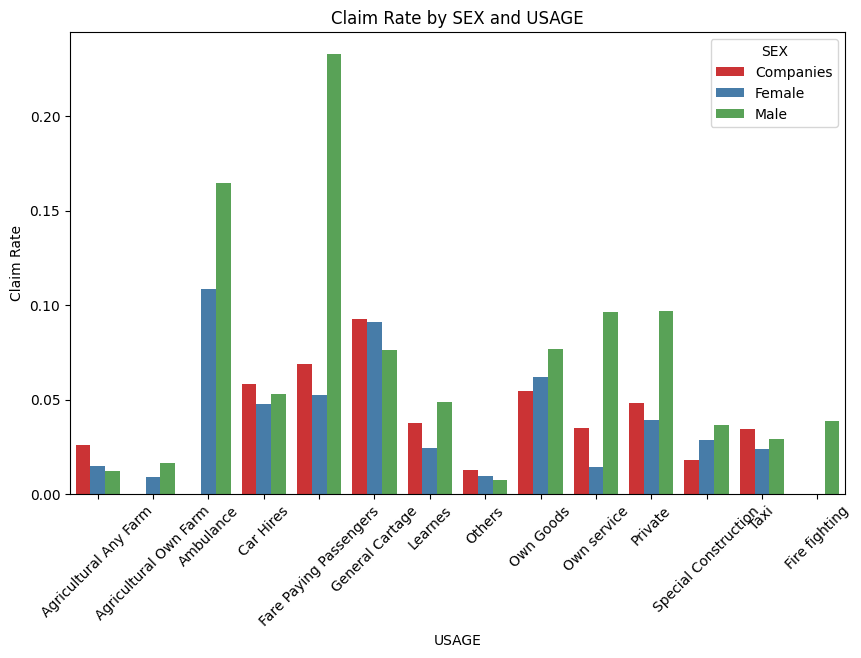

In [66]:
cross = df.groupby(['SEX','USAGE'])['CLAIM_FLAG'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='USAGE', y='CLAIM_FLAG', hue='SEX', data=cross, palette='Set1')
plt.title("Claim Rate by SEX and USAGE")
plt.xticks(rotation=45)
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 👨 **مردان (Male):** در اکثر کاربری‌ها نرخ خسارت بالاتری نسبت به زنان و شرکت‌ها دارند. به‌خصوص در:  
  - 🚕 **Fare Paying Passengers (مسافربرها):** بیشترین نرخ خسارت (بیش از 20%).  
  - 🚚 **Agricultural Own Farm** و **Own Goods** → نرخ خسارت چشمگیر بالاتر.  
- 👩 **زنان (Female):** در بیشتر دسته‌ها نرخ خسارت پایین‌تر از مردان دارند، اما در برخی مثل **Ambulance** نزدیک به شرکت‌ها هستند.  
- 🏢 **شرکت‌ها (Companies):** معمولاً نرخ خسارتشان بین مردان و زنان است، اما در بعضی کاربری‌ها مثل **Car Hires** یا **General Cartage** کمی بالاتر ظاهر می‌شوند.  

✨ **این یعنی:**  
- 👨 مردان در کاربری‌های پرریسک (مسافربری، کشاورزی شخصی، حمل بار شخصی) **ریسک بیشتری** برای بیمه‌گر ایجاد می‌کنند.  
- 👩 زنان همچنان **ریسک کمتر** دارند و برای شرکت بیمه گروهی **ایمن‌تر و سودآورتر** هستند.  
- 🏢 شرکت‌ها با نرخ خسارت متوسط می‌توانند بازار **باثبات‌تری** نسبت به افراد حقیقی پرریسک باشند.  

</div>

---



📊 Observations:  
- 👨 **Males:** Generally higher claim rates across most usage categories. Especially in:  
  - 🚕 **Fare Paying Passengers:** Extremely high (~20%+).  
  - 🚚 **Agricultural Own Farm** and **Own Goods** → noticeable higher risks.  
- 👩 **Females:** Typically show **lower claim rates**, but in categories like **Ambulance** they are close to companies.  
- 🏢 **Companies:** Usually in the middle, but in some categories (e.g., **Car Hires**, **General Cartage**) they are relatively higher.  

✨ **This means:**  
- 👨 Males dominate the **high-risk usages** (passenger transport, own farm/agriculture, own goods transport).  
- 👩 Females remain **lower-risk**, offering a **safer portfolio** for insurers.  
- 🏢 Companies show **moderate risk**, making them a **stable and balanced segment** compared to individual high-risk drivers.  


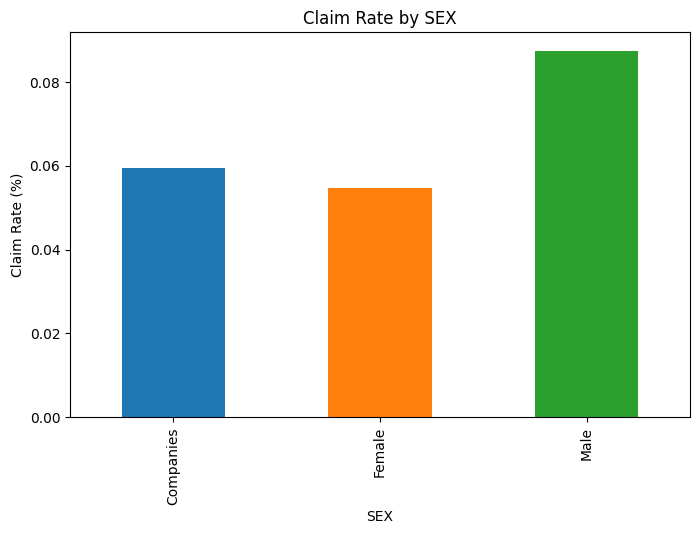

In [67]:
claim_rate = df.groupby('SEX')['CLAIM_FLAG'].mean()

claim_rate.plot(kind='bar', figsize=(8,5), color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.title("Claim Rate by SEX")
plt.ylabel("Claim Rate (%)")
plt.xlabel("SEX")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

👨 **مردان (Male):** بالاترین نرخ خسارت، حدود **9%** → نشان‌دهنده **ریسک بالاتر** و نیازمند توجه ویژه در قیمت‌گذاری بیمه.  

👩 **زنان (Female):** کمترین نرخ خسارت، حدود **5.5%** → مشتریانی **ایمن‌تر و سودآورتر** برای شرکت بیمه.  

🏢 **شرکت‌ها (Companies):** نرخ خسارت متوسط، حدود **6%** → گروهی متعادل که می‌توانند بازار **پایدار** ایجاد کنند.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان → بیشترین خسارت → نیاز به **مدیریت ریسک و تعرفه‌های متناسب**.  
- 👩 زنان → سهم بزرگ + خسارت کمتر → بهترین گزینه برای **طرح‌های تشویقی و وفاداری**.  
- 🏢 شرکت‌ها → نرخ متوسط → مناسب برای **بیمه‌های سازمانی و ناوگان**.  

</div>

---



👨 **Males:** Highest claim rate (~9%) → Represent the **riskiest group**, requiring stricter underwriting.  

👩 **Females:** Lowest claim rate (~5.5%) → **Profitable and safer** customers for insurers.  

🏢 **Companies:** Moderate claim rate (~6%) → Provide a **balanced and stable** market segment.  

### 📌 Key Insights:  
- 👨 Males → Higher claims → Need **risk-adjusted pricing**.  
- 👩 Females → Significant share + Lower claims → Best suited for **discounts and loyalty programs**.  
- 🏢 Companies → Medium risk → Potential for **corporate and fleet insurance expansion**.  


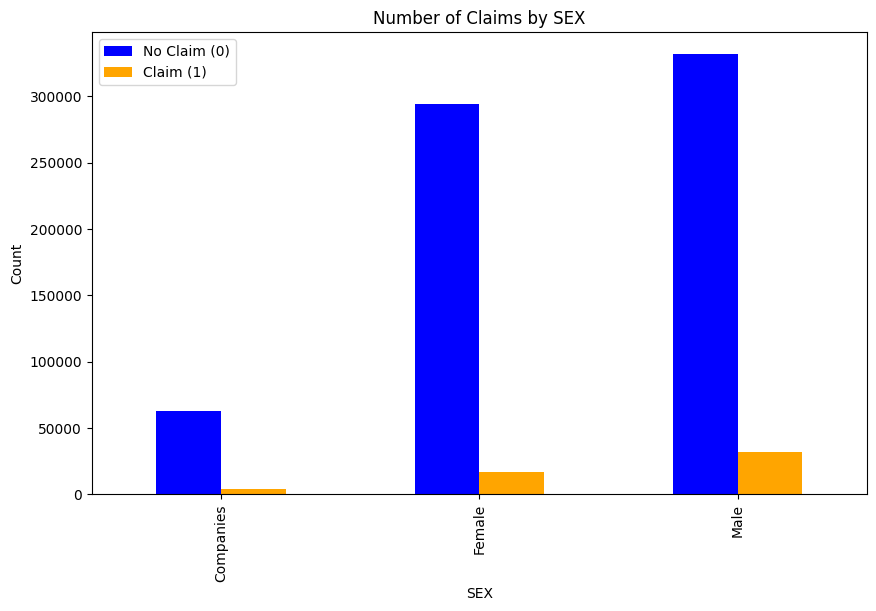

In [68]:
claim_counts = df.groupby(['SEX', 'CLAIM_FLAG']).size().unstack()

claim_counts.plot(kind='bar', figsize=(10,6), color=['blue', 'orange'])

plt.title("Number of Claims by SEX")
plt.xlabel("SEX")
plt.ylabel("Count")
plt.legend(["No Claim (0)", "Claim (1)"])
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 👨 **مردان (Male):** بیشترین تعداد خسارت ثبت‌شده رو دارن (بیش از **40,000 Claim**).  
- 👩 **زنان (Female):** تعداد خسارت کمتر از مردان (حدود **20,000 Claim**)، در حالی که تعداد بیمه‌نامه‌هاشون بالاست.  
- 🏢 **شرکت‌ها (Companies):** کمترین تعداد خسارت (چند هزار Claim)، هم‌راستا با سهم بازار کوچکشان.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان نه‌تنها بالاترین نرخ خسارت رو دارن (نمودار قبلی)، بلکه **بیشترین تعداد خسارت مطلق** رو هم ثبت می‌کنن → فشار مالی اصلی روی شرکت بیمه.  
- 👩 زنان با تعداد خسارت کمتر و نرخ پایین‌تر → گروهی **سودآور و کم‌ریسک** هستند.  
- 🏢 شرکت‌ها خسارت‌های کمتری دارن → با توجه به حجم کم بازار، ریسک این بخش نسبتاً پایین‌تره.  

</div>

---


📊 Observations:  
- 👨 **Males:** Record the highest number of claims (**40,000+**), making them the **largest risk contributor**.  
- 👩 **Females:** Fewer claims (~20,000) despite having a large insured base → safer and more profitable segment.  
- 🏢 **Companies:** Very few claims (a few thousand), aligned with their small share of the market.  

### 📌 Key Insights:  
- 👨 Males → Highest claim rate + Highest claim volume → **major financial burden** for insurers.  
- 👩 Females → Lower rate + Fewer claims → **most profitable group**.  
- 🏢 Companies → Small volume + Few claims → **low-risk but limited potential** segment.  


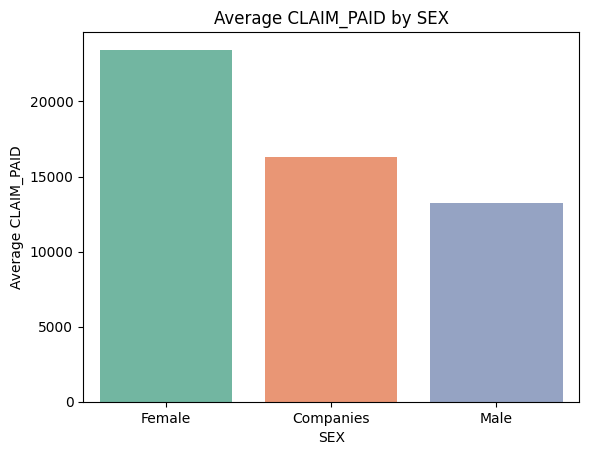

In [69]:
Claim_paid = df.groupby('SEX')['CLAIM_PAID'].mean().reset_index().sort_values(by='CLAIM_PAID', ascending=False)
sns.barplot(data=Claim_paid, x='SEX', y='CLAIM_PAID', palette='Set2')
plt.title('Average CLAIM_PAID by SEX')
plt.ylabel('Average CLAIM_PAID')
plt.xlabel('SEX')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



👩 **زنان (Female):** بالاترین میانگین خسارت پرداختی، حدود **25,000** → یعنی هر بار خسارت در این گروه معمولاً **مبلغ بالاتری** داشته.  

🏢 **شرکت‌ها (Companies):** میانگین خسارت پرداختی حدود **17,000** → در سطح متوسط.  

👨 **مردان (Male):** پایین‌ترین میانگین خسارت پرداختی، حدود **13,000** → خسارت‌هایشان به طور میانگین **کم‌هزینه‌تر** بوده.  

### 📌 نکات کلیدی (Insights):  
- 👩 با اینکه زنان نرخ خسارت پایین‌تری دارند (نمودارهای قبلی)، ولی وقتی خسارت اتفاق می‌افتد، **مبلغ پرداختی بیشتر** است.  
- 👨 مردان خسارت‌های بیشتری دارند اما مبلغ هر خسارت معمولاً کمتر است → فشار بیمه‌گر بیشتر از حجم زیاد خسارت‌هاست نه مبلغ هر کدام.  
- 🏢 شرکت‌ها در وسط قرار دارند → هم از نظر نرخ و هم مبلغ خسارت، گروهی متعادل محسوب می‌شوند.  

</div>

---
 

👩 **Females:** Highest average claim paid (~25,000) → Each claim tends to be **more expensive**.  

🏢 **Companies:** Moderate average claim paid (~17,000).  

👨 **Males:** Lowest average claim paid (~13,000) → Individual claims are **cheaper**, but occur more frequently.  

### 📌 Key Insights:  
- 👩 Females → Fewer claims, but when they happen, they **cost more**.  
- 👨 Males → More frequent claims, but each one is **lower in value**.  
- 🏢 Companies → Balanced position, with **moderate claim costs**.  


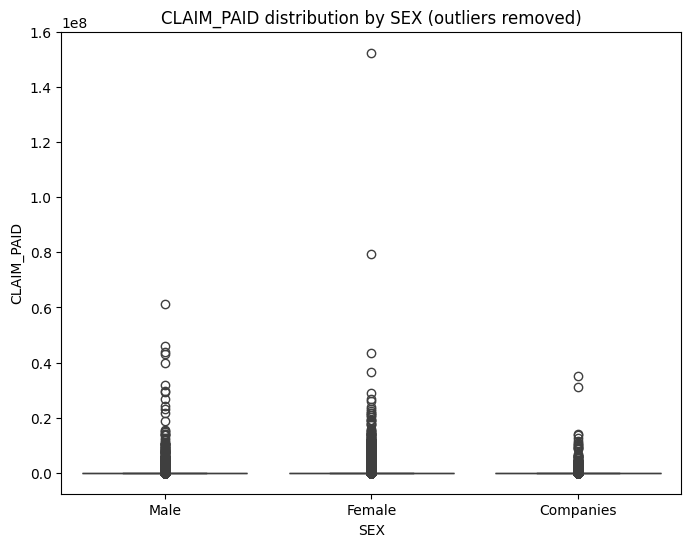

In [70]:
plt.figure(figsize=(8,6))
sns.boxplot(x='SEX', y='CLAIM_PAID', data=df, showfliers=True)  
plt.title("CLAIM_PAID distribution by SEX (outliers removed)")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

📊 مشاهده‌ها:  
- 👨 **مردان (Male):** گستره‌ی خسارت‌ها نسبتاً وسیع است، با موارد متعددی در محدوده بالا (ولی کمتر از زنان).  
- 👩 **زنان (Female):** توزیع خسارت‌ها پهن‌تر و پراکندگی بیشتر دارد → نشان می‌دهد که در بین زنان، وقتی خسارت رخ می‌دهد، احتمال پرداخت‌های بسیار بالا وجود دارد.  
- 🏢 **شرکت‌ها (Companies):** دامنه خسارت‌ها محدودتر است و پراکندگی بسیار کمتر از افراد حقیقی → نشان‌دهنده‌ی **ریسک پایین‌تر در تنوع مبلغ خسارت‌ها**.  

### 📌 نکات کلیدی (Insights):  
- 👨 مردان خسارت‌های پرتعداد ولی با مبالغ معمولاً کمتر دارند.  
- 👩 زنان خسارت‌های کمتری دارند، اما وقتی خسارت اتفاق می‌افتد، **ریسک خسارت‌های بسیار بزرگ‌تر** بالاست.  
- 🏢 شرکت‌ها خسارت‌های یکنواخت‌تر دارند، بدون شوک‌های خیلی بزرگ، و از این نظر برای بیمه‌گر **قابل پیش‌بینی‌تر** هستند.  

</div>

---



📊 Observations:  
- 👨 **Males:** Wide range of claims, but extreme high values are less common compared to females.  
- 👩 **Females:** Show a broader distribution with higher outliers → when claims occur, they can sometimes be **very costly**.  
- 🏢 **Companies:** Narrower distribution with lower variability → **more predictable** claim costs.  

### 📌 Key Insights:  
- 👨 Males → Many claims, but typically smaller amounts.  
- 👩 Females → Fewer claims, but **potential for very high payouts**.  
- 🏢 Companies → Consistent and more **stable claim distributions**.  


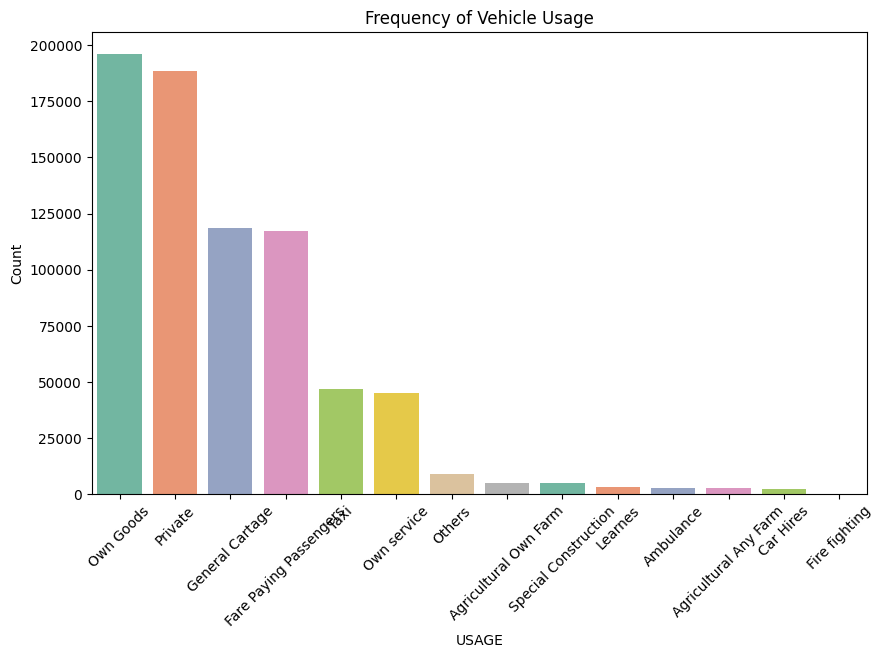

In [71]:
plt.figure(figsize=(10,6))
sns.countplot(x="USAGE", data=df, order=df["USAGE"].value_counts().index, palette="Set2")
plt.title("Frequency of Vehicle Usage")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



📊 مشاهده‌ها:  
- 🚚 **Own Goods (حمل کالای شخصی):** بیشترین سهم (بیش از 190,000 وسیله نقلیه).  
- 🚗 **Private (شخصی):** دومین رتبه با بیش از 185,000 وسیله.  
- 🚛 **General Cartage (حمل بار عمومی):** سومین رتبه با حدود 125,000 وسیله.  
- 🚌 **Fare Paying Passengers (مسافربری):** سهم قابل توجه، کمی کمتر از 120,000.  
- 🚕 **Taxi:** رتبه بعدی، حدود 50,000 وسیله.  
- ⚙️ سایر دسته‌ها (مانند **کشاورزی، ساخت‌وساز ویژه، آمبولانس، اجاره‌ای، آتش‌نشانی**) سهم خیلی کمتری دارند.  

### 📌 نکات کلیدی (Insights):  
- بازار بیمه وسایل نقلیه به شدت تحت تأثیر **خودروهای شخصی و باری (Own Goods + Private)** است → این دو دسته بیش از **نیمی از کل بازار** را تشکیل می‌دهند.  
- **وسایل نقلیه عمومی (General Cartage + Fare Paying Passengers + Taxi)** سهم قابل توجهی دارند و به دلیل ریسک بالاتر باید در **مدل قیمت‌گذاری دقیق‌تر** لحاظ شوند.  
- دسته‌های کوچک‌تر (کشاورزی، خدمات ویژه و غیره) حجم کمی دارند، اما می‌توانند فرصت‌های **بازاریابی تخصصی** ایجاد کنند.  

</div>

---

 

📊 Observations:  
- 🚚 **Own Goods:** Largest segment (>190,000 vehicles).  
- 🚗 **Private:** Second largest (>185,000).  
- 🚛 **General Cartage:** Third (~125,000).  
- 🚌 **Fare Paying Passengers:** Significant (~115,000).  
- 🚕 **Taxi:** Moderate (~50,000).  
- ⚙️ Other categories (Agriculture, Special Construction, Ambulance, Hires, Firefighting) → very small share.  

### 📌 Key Insights:  
- The insurance market is dominated by **Own Goods + Private vehicles**, together forming **over half the market**.  
- **Public/commercial vehicles (General Cartage, Fare Paying, Taxi)** are important high-risk groups requiring **risk-based premium strategies**.  
- Smaller categories, though limited in volume, represent **niche opportunities** for tailored insurance products.  


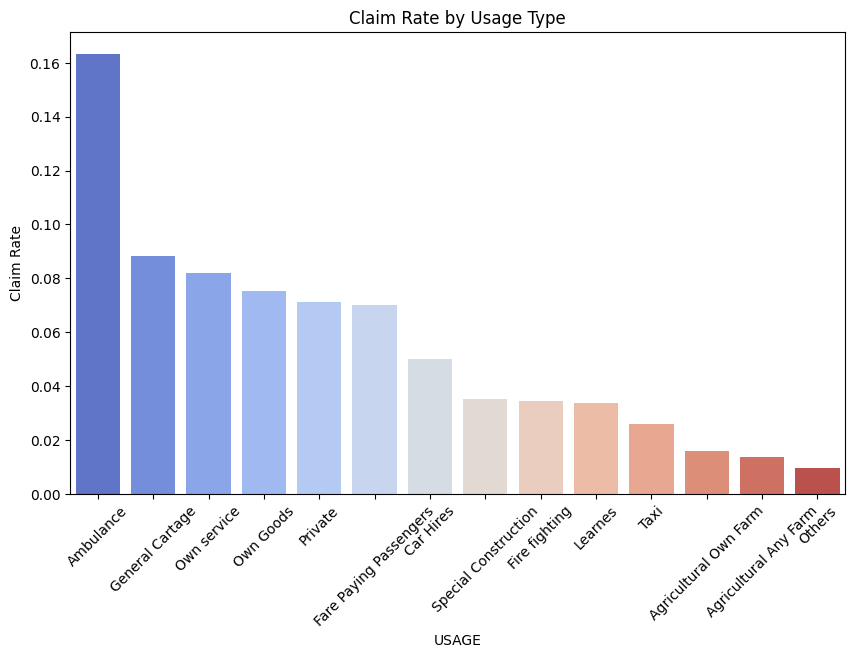

In [72]:
claim_rate_usage = df.groupby("USAGE")["CLAIM_FLAG"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="USAGE", y="CLAIM_FLAG", data=claim_rate_usage, order=claim_rate_usage.sort_values("CLAIM_FLAG", ascending=False)["USAGE"], palette="coolwarm")
plt.title("Claim Rate by Usage Type")
plt.ylabel("Claim Rate")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



📊 مشاهده‌ها:  
- 🚑 **Ambulance (آمبولانس):** بالاترین نرخ خسارت با حدود **17%**.  
- 🚛 **General Cartage (حمل بار عمومی):** نرخ نسبتاً بالا، حدود **9%**.  
- ⚙️ **Own Service / Own Goods:** نرخ خسارت بالاتر از میانگین (~8–9%).  
- 🚗 **Private (شخصی):** کمی کمتر از متوسط (~7%).  
- 🚌 **Fare Paying Passengers:** نرخ خسارت پایین‌تر (~5%).  
- 🚕 **Taxi** و دسته‌های **کشاورزی** (Agricultural) → کمترین نرخ خسارت (~2–3%).  
- 🔥 **Fire Fighting** و **Special Construction:** نزدیک به میانگین پایین (~3–4%).  

### 📌 نکات کلیدی (Insights):  
- 🚑 **آمبولانس‌ها پرریسک‌ترین گروه هستند** → به دلیل ماهیت عملیاتی و تردد در شرایط اضطراری.  
- 🚛 **خودروهای باری عمومی** هم نرخ خسارت بالایی دارند → نیازمند مدیریت ریسک ویژه و تعرفه‌های دقیق‌تر.  
- 🚗 خودروهای شخصی و عمومی (Private + Fare Paying) ریسک متوسط رو به پایین دارند → بازار اصلی اما نسبتاً امن‌تر.  
- 🚕 تاکسی‌ها و وسایل کشاورزی نرخ خسارت پایین دارند → اما ممکن است **حجم خسارت** بالا نباشد چون تعدادشان هم محدود است.  

</div>

---



📊 Observations:  
- 🚑 **Ambulances:** Highest claim rate (~17%).  
- 🚛 **General Cartage:** High (~9%).  
- ⚙️ **Own Service / Own Goods:** Above average (~8–9%).  
- 🚗 **Private:** Slightly below average (~7%).  
- 🚌 **Fare Paying Passengers:** Lower (~5%).  
- 🚕 **Taxis** and **Agricultural vehicles:** Lowest claim rates (~2–3%).  
- 🔥 **Fire Fighting** & **Special Construction:** Also relatively low (~3–4%).  

### 📌 Key Insights:  
- 🚑 **Ambulances are the riskiest segment** due to emergency and high-frequency usage.  
- 🚛 **General Cartage vehicles** show high risk → need **special pricing and risk control**.  
- 🚗 **Private and passenger vehicles** are safer, making them the **core stable market**.  
- 🚕 **Taxis & Agricultural vehicles** have low claim rates, but their market volume is small.  


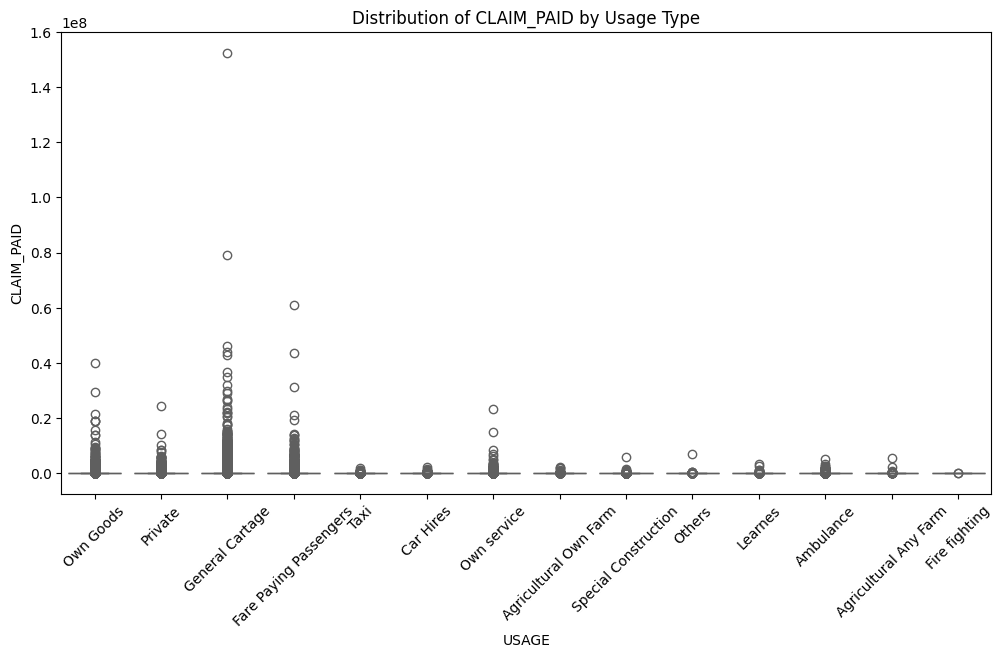

In [73]:
plt.figure(figsize=(12,6))
sns.boxplot(x="USAGE", y="CLAIM_PAID", data=df, palette="Set3")
plt.title("Distribution of CLAIM_PAID by Usage Type")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 📦 **Own Goods** و 🚗 **Private** → بیشترین پراکندگی پرداخت خسارت؛ بعضی از خسارت‌ها تا سطوح بسیار بالا (Outliers) مشاهده شده.  
- 🚛 **General Cartage** → تعداد زیادی خسارت و همچنین چندین مورد خسارت بسیار بزرگ → ریسک بالا.  
- 🚌 **Fare Paying Passengers** → خسارت‌ها پراکندگی متوسط دارن اما چند نمونه پرداخت بزرگ دیده می‌شه.  
- 🚕 **Taxi** و 🚐 **Car Hires** → اغلب خسارت‌های کوچک، Outlier کمی دارن.  
- 🚑 **Ambulance** → علی‌رغم نرخ بالای خسارت (Claim Rate)، پراکندگی مبلغ پرداختی پایین‌تره.  
- 🚜 **کشاورزی (Agricultural Any/Own Farm)** و 🔥 **Fire Fighting** → خسارت‌های کم و مبالغ نسبتاً پایین.  

### 📌 نکات کلیدی (Insights):  
- 📦 **Own Goods و Private** → بخش پرریسک برای بیمه‌گر از نظر حجم و مبلغ خسارت.  
- 🚛 **General Cartage** → ترکیب "تعداد زیاد + خسارت‌های سنگین" → نیازمند مدیریت ریسک ویژه.  
- 🚕 تاکسی‌ها و بخش کشاورزی → کم‌ریسک‌تر هم از نظر تعداد هم از نظر مبلغ.  
- 🚑 آمبولانس → ریسک بالای **وقوع خسارت** اما نه لزوماً از نظر مبلغ خسارت پرداختی.  

</div>

---



📊 Observations:  
- 📦 **Own Goods & Private:** Highest spread of claim payments with some very large outliers.  
- 🚛 **General Cartage:** Many claims plus several very high-cost claims → high risk.  
- 🚌 **Fare Paying Passengers:** Medium spread, with some big payments.  
- 🚕 **Taxis & Car Hires:** Mostly small claims, very few outliers.  
- 🚑 **Ambulances:** High claim frequency but lower claim payment amounts.  
- 🚜 **Agricultural & Fire Fighting vehicles:** Very few and small claims.  

### 📌 Key Insights:  
- 📦 **Own Goods and Private cars** → highest financial exposure for insurers.  
- 🚛 **General Cartage** → double risk (volume + severity) → needs stricter underwriting.  
- 🚕 **Taxis & Agricultural vehicles** → lower financial risk.  
- 🚑 **Ambulances** → operationally risky but claims aren’t as costly as expected.  


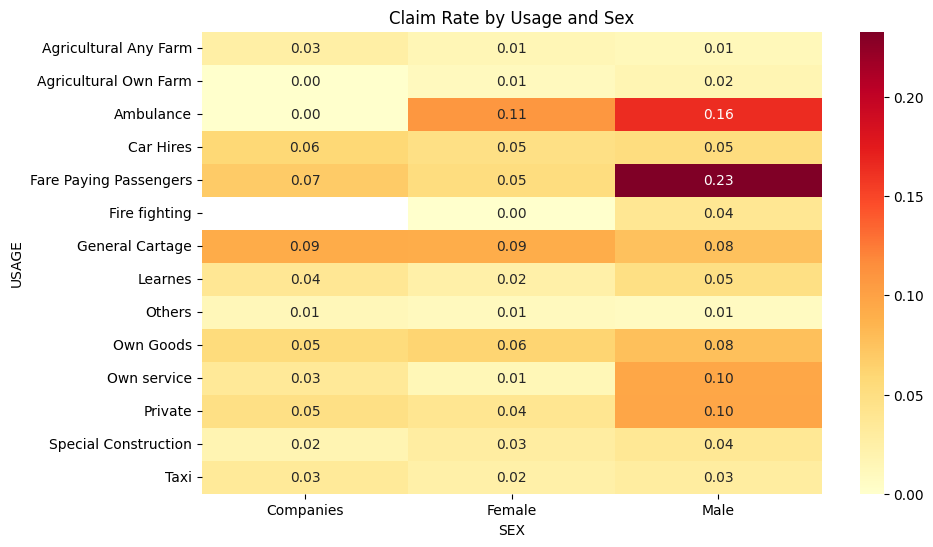

In [74]:
cross_usage_sex = df.groupby(["USAGE", "SEX"])["CLAIM_FLAG"].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(cross_usage_sex, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Claim Rate by Usage and Sex")
plt.ylabel("USAGE")
plt.xlabel("SEX")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">


📊 مشاهده‌ها:  
- 🚑 **Ambulance**:  
  - مردها (Male) → بالاترین نرخ خسارت (0.16)  
  - زنان (Female) → نسبتاً بالا (0.11)  
  → به وضوح گروه پرریسک.  

- 🚌 **Fare Paying Passengers (مسافربرها)**:  
  - مردها (Male) → بیشترین نرخ خسارت در کل جدول (0.23)  
  - سایر گروه‌ها → نرخ پایین‌تر  
  → نشان‌دهنده پرخطر بودن رانندگان مرد در این بخش.  

- 🚛 **General Cartage**:  
  - همه گروه‌ها نرخ بالاتر از متوسط (0.08 – 0.09)  
  → ریسک یکنواخت اما نسبتاً زیاد.  

- 🚗 **Private & Own Goods**:  
  - مردها نرخ بالاتری دارن (0.10 و 0.08) نسبت به زنان و شرکت‌ها  
  → رانندگان مرد در این دسته‌ها پرریسک‌ترن.  

- 🔥 **Fire Fighting & Special Construction**:  
  - نرخ خسارت خیلی پایین (0.00 – 0.03)  
  → ریسک کم.  

- 🚜 **Agricultural (Any/Own Farm)**:  
  - نرخ خسارت بسیار پایین (0.00 – 0.02)  
  → تقریباً بدون ریسک.  

---

### 📌 جمع‌بندی کلیدی:  
- 🚑 **Ambulance (مردها)** و 🚌 **Fare Paying Passengers (مردها)** → پرریسک‌ترین گروه‌ها.  
- 🚛 **General Cartage** → همواره بالا، مستقل از جنسیت → نیاز به کنترل ویژه.  
- 🚗 رانندگان مرد در **Private و Own Goods** → نرخ خسارت بالاتر از بقیه.  
- 🚒 گروه‌های **Fire Fighting و Agricultural** → کم‌خطرترین بخش‌ها.  

</div>

---


📊 Observations:  
- 🚑 **Ambulances:**  
  - Male drivers → very high claim rate (0.16)  
  - Female drivers → also high (0.11).  
- 🚌 **Fare Paying Passengers:**  
  - Male drivers → highest in dataset (0.23).  
- 🚛 **General Cartage:**  
  - Consistently high across all categories (~0.08–0.09).  
- 🚗 **Private & Own Goods:**  
  - Male drivers riskier (0.10 and 0.08).  
- 🔥 **Fire Fighting & Agricultural vehicles:**  
  - Very low claim rates (<0.03).  

### 📌 Key Takeaways:  
- 🚑 **Ambulance (Males)** and 🚌 **Passenger Vehicles (Males)** → highest risk groups.  
- 🚛 **General Cartage** → consistently risky across all genders.  
- 🚗 Male drivers in **Private & Goods** → significantly riskier.  
- 🚒 **Agricultural & Fire Fighting vehicles** → lowest-risk categories.  


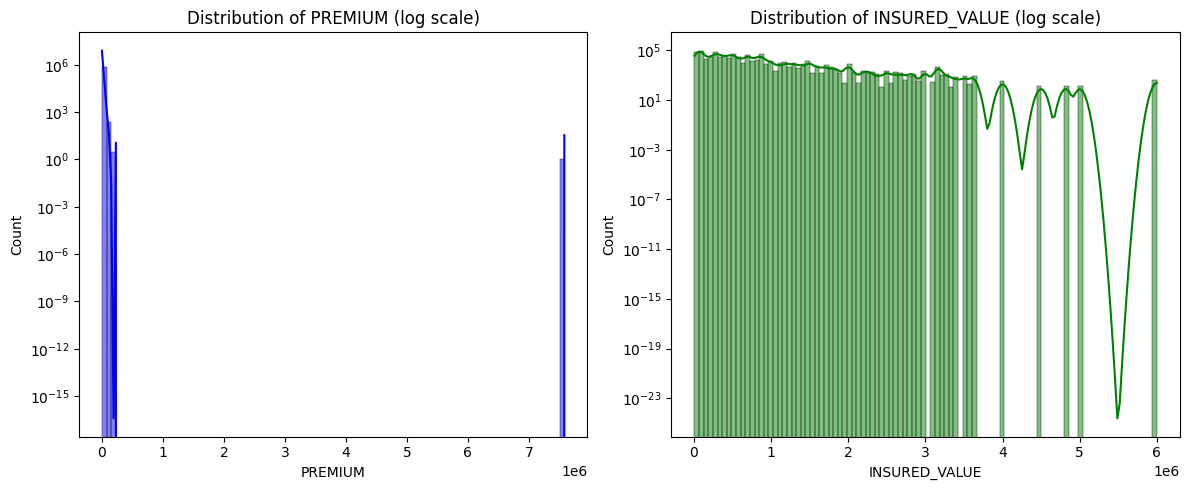

In [75]:
plt.figure(figsize=(12,5))

# PREMIUM
plt.subplot(1,2,1)
sns.histplot(df["PREMIUM"], bins=100, kde=True, color="blue")
plt.yscale("log")   # لاگ روی محور y
plt.title("Distribution of PREMIUM (log scale)")

# INSURED_VALUE
plt.subplot(1,2,2)
sns.histplot(df["INSURED_VALUE"], bins=100, kde=True, color="green")
plt.yscale("log")
plt.title("Distribution of INSURED_VALUE (log scale)")

plt.tight_layout()
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار سمت چپ → Distribution of PREMIUM (log scale)  
- پراکندگی شدید مشاهده می‌شه.  
- اکثریت داده‌ها در مقادیر خیلی پایین متمرکز هستن.  
- چند مقدار بسیار بزرگ (Outliers) هم وجود دارن که باعث کشیدگی شدید توزیع شدن.  
- استفاده از **مقیاس لگاریتمی** به وضوح نشون می‌ده که داده‌ها Heavy-Tailed هستن.  

### 📊 نمودار سمت راست → Distribution of INSURED_VALUE (log scale)  
- مشابه Premium، بیشتر داده‌ها در بازه‌های خیلی کوچک قرار گرفتن.  
- چند مقدار خیلی بزرگ (حتی بالای `2.5e8`) وجود داره که به وضوح Outlier هستن.  
- این نشون می‌ده که **ارزش بیمه‌ای خودروها (Insured Value)** توی دیتاست بسیار ناهمگن هست.  

---

### 📌 جمع‌بندی :  
- هم در Premium و هم در Insured Value، **بیشتر داده‌ها در بازه‌های پایین فشرده شدن**.  
- **Outliers بسیار بزرگ** وجود داره که حتماً باید قبل از مدل‌سازی بررسی و مدیریت بشن.  
- استفاده از **مقیاس لگاریتمی** کمک کرده که این عدم‌توازن بهتر دیده بشه.  

</div>


---



### 📊 Left Plot → Distribution of PREMIUM (log scale)  
- Highly skewed distribution.  
- Majority of values are concentrated at the low end.  
- Presence of **extreme outliers** (millions range) stretching the scale.  
- Log scale reveals the **heavy-tailed nature** of the data.  

### 📊 Right Plot → Distribution of INSURED_VALUE (log scale)  
- Similar behavior as PREMIUM.  
- Most values clustered near the bottom, with **some extremely high insured values (> 2.5e8)**.  
- Shows strong **heterogeneity in insured vehicle values**.  

---

### 📌 Key Takeaway:  
- Both **Premium** and **Insured Value** show **highly skewed distributions** with many **outliers**.  
- Handling these outliers will be crucial before training predictive models (e.g., applying log-transform, winsorization, or robust scaling).  


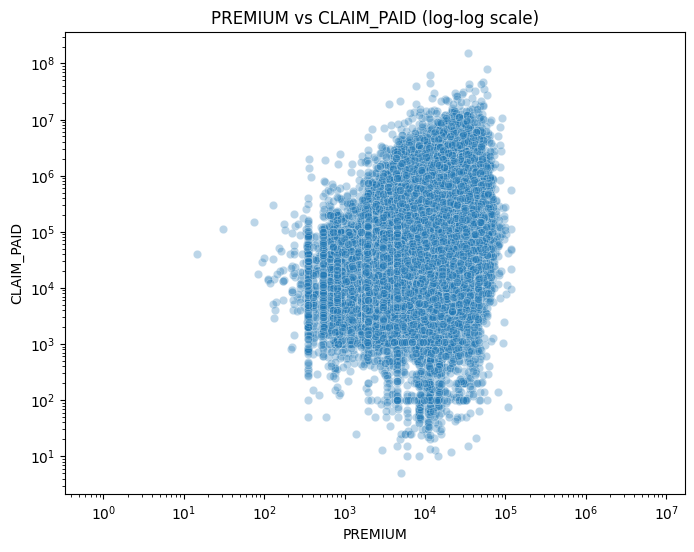

In [76]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="PREMIUM", y="CLAIM_PAID", data=df, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("PREMIUM vs CLAIM_PAID (log-log scale)")
plt.xlabel("PREMIUM")
plt.ylabel("CLAIM_PAID")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → PREMIUM vs CLAIM_PAID (log-log scale)  
- این نمودار رابطه بین **مبلغ حق بیمه (Premium)** و **مبلغ پرداختی خسارت (Claim Paid)** رو نشون می‌ده.  
- چون هر دو متغیر دارای **پراکندگی شدید و Outlier** بودن، از **مقیاس لگاریتمی دوطرفه (log-log)** استفاده شده.  
- الگوی کلی نشون می‌ده که با افزایش Premium، مقادیر Claim Paid هم **افزایش نسبی** پیدا می‌کنه.  
- اما داده‌ها پراکندگی زیادی دارن → یعنی همبستگی خطی ساده خیلی قوی نیست.  
- خوشه‌بندی (Clustering) قابل مشاهده است → مثلاً تعداد زیادی از داده‌ها در محدوده‌های خاص Premium و Claim Paid متمرکز شدن.  
- وجود چند نقطه خیلی دور (Extreme Outliers) هم به وضوح مشخصه.  

---

### 📌 جمع‌بندی :  
- رابطه مثبت بین Premium و Claim Paid وجود داره، ولی خیلی **پراکنده و پرنویز** هست.  
- احتمالاً مدل‌های خطی ساده خوب جواب نمی‌دن → نیاز به **مدل‌های مقاوم در برابر پراکندگی بالا** یا **مدل‌های غیرخطی** مثل Random Forest یا Gradient Boosting وجود داره.  
- همچنین حذف یا مدیریت Outlierها ضروریه.  

</div>

---



### 📊 Plot → PREMIUM vs CLAIM_PAID (log-log scale)  
- Shows the relationship between **Premium amount** and **Claim Paid**.  
- Both variables are **heavily skewed**, hence the **log-log scale**.  
- General upward trend: higher Premiums tend to be associated with higher Claim Paid.  
- However, the data is **highly scattered**, indicating that correlation is not very strong.  
- Clear clustering is visible in certain ranges of Premium and Claim Paid.  
- Presence of **extreme outliers** is very evident.  

---

### 📌 Key Takeaways:  
- Positive relationship exists, but it is **noisy and weakly linear**.  
- Simple linear regression may not perform well → better to use **robust or nonlinear models**.  
- Outlier treatment will be a critical preprocessing step.  


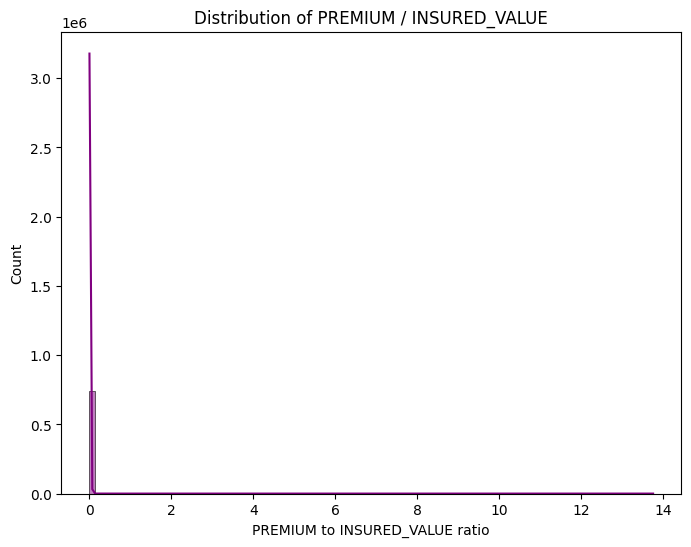

In [77]:
df["PREM_RATIO"] = df["PREMIUM"] / df["INSURED_VALUE"]

plt.figure(figsize=(8,6))
sns.histplot(df["PREM_RATIO"], bins=100, kde=True, color="purple")
plt.title("Distribution of PREMIUM / INSURED_VALUE")
plt.xlabel("PREMIUM to INSURED_VALUE ratio")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → Distribution of PREMIUM / INSURED_VALUE ratio  
- این نمودار نشون می‌ده که **حق بیمه نسبت به ارزش بیمه‌شده** معمولاً در محدوده‌های خیلی پایین متمرکزه.  
- بخش بزرگی از داده‌ها در محدوده نزدیک به صفر هستن → یعنی در بیشتر قراردادها، حق بیمه بخش خیلی کوچیکی از ارزش بیمه‌شده است.  
- با این حال، مقادیر خیلی بزرگی هم دیده می‌شن (Tail سمت راست نمودار)، که نشون می‌ده بعضی از بیمه‌گذاران حق بیمه بسیار بالایی نسبت به ارزش بیمه‌شده پرداخت می‌کنن.  
- این موارد احتمالاً Outlier هستن و یا ناشی از قراردادهای خاص (مثلاً ریسک بالا یا محاسبه غیرمعمول).  

---

### 📌 جمع‌بندی :  
- نسبت Premium/Insured Value در حالت عادی باید کم باشه، و همینطور هم دیده می‌شه.  
- وجود نقاط بسیار بزرگ می‌تونه نشان‌دهنده **عدم تناسب بین ریسک و ارزش بیمه‌شده** باشه.  
- پیشنهاد می‌شه بررسی بشه که آیا این مقادیر ناشی از خطاهای داده‌ای هستن یا قراردادهای خاص.  

</div>

---

 

### 📊 Plot → Distribution of PREMIUM / INSURED_VALUE ratio  
- The distribution shows that **most policies have a very small Premium compared to Insured Value**.  
- A heavy concentration is observed near zero.  
- However, there are extreme right-tail values → indicating some cases where Premium is disproportionately high relative to Insured Value.  
- These could be **outliers** or **special cases** (e.g., high-risk policies, data entry issues, or premium mispricing).  

---

### 📌 Key Takeaways:  
- The ratio is normally low, but the extreme outliers need investigation.  
- Important for risk assessment and premium adequacy checks.  


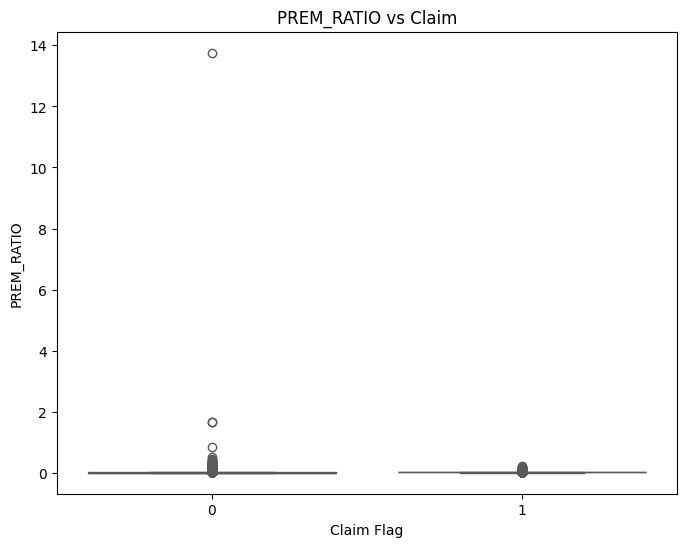

In [78]:
plt.figure(figsize=(8,6))
sns.boxplot(x="CLAIM_FLAG", y="PREM_RATIO", data=df, palette="Set2")
plt.title("PREM_RATIO vs Claim")
plt.xlabel("Claim Flag")
plt.ylabel("PREM_RATIO")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → PREM_RATIO vs Claim  
- محور افقی:  
  - **0 = بدون خسارت**  
  - **1 = با خسارت**  

- محور عمودی: **PREM_RATIO** (نسبت حق بیمه به ارزش بیمه‌شده).  

### 🔎 مشاهدات:  
1. در هر دو گروه (با خسارت و بدون خسارت)، مقدار PREM_RATIO در بیشتر موارد بسیار کوچک است.  
2. تعدادی Outlier خیلی بزرگ در گروه **بدون خسارت (0)** وجود داره → یعنی بعضی از بیمه‌گذاران حق بیمه خیلی زیادی پرداخت کردن، ولی خسارتی ثبت نشده.  
3. در گروه **با خسارت (1)** پراکندگی کمتره و Outlier خیلی زیادی دیده نمی‌شه.  

---

### 📌 نتیجه‌گیری :  
- به‌طور کلی، نسبت حق بیمه به ارزش بیمه‌شده تأثیر زیادی روی وقوع خسارت نشون نمی‌ده.  
- با این حال، Outlier های بزرگ در گروه بدون خسارت می‌تونن نشونه‌ی **محاسبه‌ی نامتناسب حق بیمه** یا **ریسک‌هایی باشن که برخلاف انتظار خسارت ایجاد نکردن**.  
- بررسی این Outlierها می‌تونه برای کشف الگوهای قیمتی یا مشکلات داده‌ای خیلی مفید باشه.  

</div>

---



### 📊 Plot → PREM_RATIO vs Claim  
- X-axis: Claim Flag (0 = No claim, 1 = Claim).  
- Y-axis: Premium-to-Insured-Value Ratio.  

### 🔎 Observations:  
1. For both groups, the ratio is usually very small.  
2. There are **extreme outliers in the "No Claim" group (0)**, showing some policies had very high premiums compared to insured value but no claims were filed.  
3. The "Claim" group (1) shows less extreme variation.  

---

### 📌 Key Insights:  
- Premium-to-Insured-Value ratio does not strongly separate claim vs no-claim groups.  
- High outliers without claims might indicate **overpriced policies, mispricing, or very risk-averse customers**.  
- Worth investigating those outliers separately.  


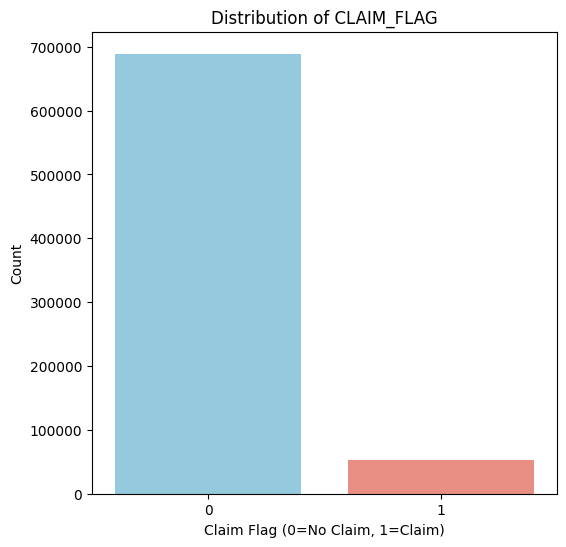

Claim Rate: 7.13%


In [79]:
plt.figure(figsize=(6,6))
sns.countplot(x="CLAIM_FLAG", data=df, palette=["skyblue","salmon"])
plt.title("Distribution of CLAIM_FLAG")
plt.xlabel("Claim Flag (0=No Claim, 1=Claim)")
plt.ylabel("Count")
plt.show()

# درصد خسارت
claim_rate = df["CLAIM_FLAG"].mean() * 100
print(f"Claim Rate: {claim_rate:.2f}%")


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

 

### 📊 نمودار → توزیع CLAIM_FLAG  
- محور افقی:  
  - **0 = بدون خسارت**  
  - **1 = با خسارت**  

- محور عمودی: **تعداد بیمه‌نامه‌ها**  

### 🔎 مشاهدات:  
1. اکثریت بیمه‌نامه‌ها (حدود **۷۵۰ هزار**) بدون خسارت هستن.  
2. تعداد بیمه‌نامه‌های دارای خسارت خیلی کمتره (حدود **۶۰–۷۰ هزار**).  
3. این یعنی داده‌ها **به‌شدت نامتوازن (imbalanced)** هستن.  

---

### 📌 نتیجه‌گیری :  
- چون داده‌ها نامتوازن هستن، هر مدلی برای پیش‌بینی خسارت (Claim Prediction) باید با دقت بیشتری طراحی بشه.  
- اگر مستقیماً روی این داده‌ها مدل‌سازی انجام بشه، مدل احتمالاً بیشتر مواقع "بدون خسارت" (0) رو پیش‌بینی می‌کنه و دقت ظاهری بالایی خواهد داشت، اما در شناسایی خسارت واقعی (1) ضعیف خواهد بود.  
- برای مقابله با این مشکل می‌شه از روش‌های زیر استفاده کرد:  
  1. **Oversampling** (مثل SMOTE) برای افزایش نمونه‌های کلاس 1.  
  2. **Undersampling** برای کاهش نمونه‌های کلاس 0.  
  3. **استفاده از وزن‌دهی (Class Weights)** در الگوریتم‌های یادگیری.  

</div>

---

  

### 📊 Chart → Distribution of CLAIM_FLAG  
- X-axis: Claim Flag (0 = No claim, 1 = Claim).  
- Y-axis: Count of policies.  

### 🔎 Observations:  
1. Most policies (**~750k**) have no claims.  
2. Only about **60–70k** policies have claims.  
3. The dataset is **highly imbalanced**.  

---

### 📌 Key Insights:  
- Imbalance means models may **bias towards "No Claim"** predictions.  
- Need techniques like **SMOTE, undersampling, or class weights** to improve claim detection performance.  


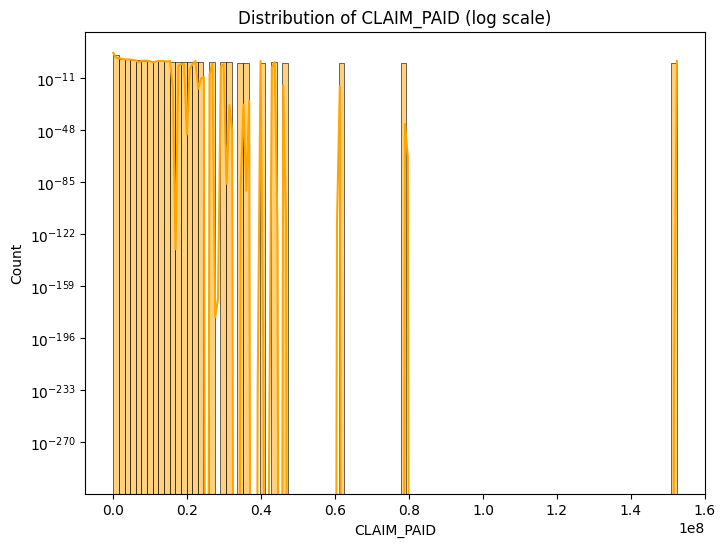

In [80]:
plt.figure(figsize=(8,6))
sns.histplot(df["CLAIM_PAID"], bins=100, kde=True, color="orange")
plt.yscale("log")  # چون outlier زیاده
plt.title("Distribution of CLAIM_PAID (log scale)")
plt.xlabel("CLAIM_PAID")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → Distribution of CLAIM_PAID (log scale)  
- محور افقی: **CLAIM_PAID** (مبلغ خسارت پرداختی).  
- محور عمودی: **تعداد (Count)** در مقیاس لگاریتمی.  

### 🔎 مشاهدات:  
1. داده‌ها به‌شدت **چولگی به راست (Right-skewed)** دارن.  
   - اکثر خسارت‌ها در مبالغ پایین متمرکز شدن.  
   - تعداد کمی از خسارت‌ها بسیار بزرگ هستن (outliers).  
2. در مقیاس لگاریتمی هم بازه گسترده‌ای از داده‌ها دیده می‌شه (از چند صد هزار تا بالای صد میلیون).  
3. وجود **پیک‌های مشخص** در بعضی نقاط نشون می‌ده که مبالغ خسارت پرداختی ممکنه در دسته‌های خاص یا سقف‌های قراردادی مشخص تعیین شده باشن.  

---

### 📌 نتیجه‌گیری :  
- بیشتر بیمه‌ها خسارت‌های کوچیک دارن و تعداد کمی خسارت بسیار بزرگ دارن → این روی **ریسک شرکت بیمه** تأثیر زیادی داره.  
- برای مدل‌سازی، بهتره از تبدیل‌هایی مثل **Log Transformation** یا **Robust Scaler** استفاده بشه تا اثر داده‌های پرت (Outliers) کمتر بشه.  
- تحلیل خسارت‌های خیلی بزرگ جداگانه (High Severity Claims) می‌تونه مفید باشه، چون روی سودآوری بیمه اثر زیادی دارن.  

</div>

---



### 📊 Chart → Distribution of CLAIM_PAID (log scale)  
- X-axis: CLAIM_PAID (amount of claim paid).  
- Y-axis: Count (log scale).  

### 🔎 Observations:  
1. The distribution is **highly right-skewed**.  
   - Most claims are small.  
   - A few very large claims act as outliers.  
2. The presence of **spikes at certain values** suggests possible contractual or capped amounts in claims.  
3. Even in log scale, variation spans several orders of magnitude.  

---

### 📌 Key Insights:  
- Most claims are low severity, but a few **catastrophic claims** dominate the total cost.  
- Need **log-transform or robust scaling** in modeling.  
- Consider **separating high-severity claims** for risk management analysis.  


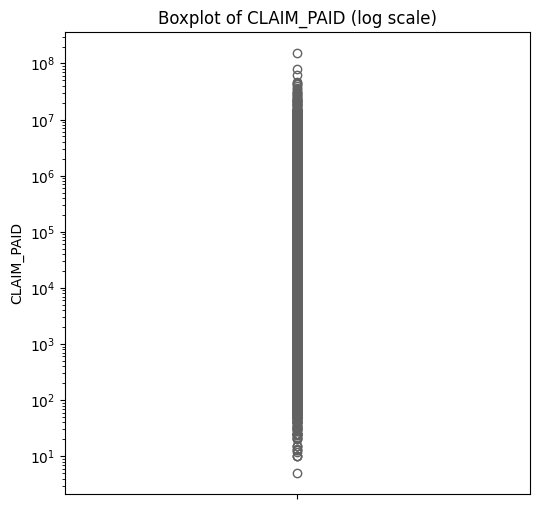

In [81]:
plt.figure(figsize=(6,6))
sns.boxplot(y="CLAIM_PAID", data=df, color="tomato")
plt.yscale("log")
plt.title("Boxplot of CLAIM_PAID (log scale)")
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">



### 📊 نمودار → Boxplot of CLAIM_PAID (log scale)  
- محور عمودی: **CLAIM_PAID** (مبلغ خسارت پرداختی) در مقیاس لگاریتمی.  
- Boxplot داده‌ها رو به همراه **میانه (Median)**، **چارک‌ها (IQR)** و **مقادیر پرت (Outliers)** نشون می‌ده.  

### 🔎 مشاهدات:  
1. بخش اعظم داده‌ها (بیش از 75%) مربوط به خسارت‌های بسیار پایین هست.  
2. داده‌های پرت زیادی در محدوده‌های بالاتر دیده می‌شه (از میلیون‌ها تا صد میلیون‌ها).  
3. چون داده خیلی **skewed** هست، Boxplot در این مقیاس بیشتر شبیه یک خط باریک به‌نظر میاد.  

---

### 📌 نتیجه‌گیری :  
- **توزیع CLAIM_PAID شدیداً نامتوازن** هست → تعداد کمی خسارت‌های خیلی بزرگ وجود داره.  
- این داده‌های پرت (High severity claims) می‌تونن به شدت مدل‌های پیش‌بینی رو تحت تأثیر قرار بدن.  
- برای تحلیل بهتر:  
  - می‌شه داده‌ها رو **Log-transform** کرد.  
  - یا داده‌های پرت رو جدا بررسی کرد (تحلیل Claims بزرگ به صورت جداگانه).  
  - یا از روش‌هایی مثل **Winsorization / Robust Scaling** استفاده کرد.  

</div>

---



### 📊 Chart → Boxplot of CLAIM_PAID (log scale)  
- Y-axis: CLAIM_PAID (claim amount paid, log scale).  
- Shows distribution with median, IQR, and outliers.  

### 🔎 Observations:  
1. Most claims are clustered at **low amounts**.  
2. A huge number of **outliers** at high values (millions → 100M+).  
3. The box itself looks compressed due to extreme skewness.  

---

### 📌 Key Insights:  
- Distribution is **highly imbalanced** → dominated by many small claims and few catastrophic ones.  
- Outliers strongly affect predictive modeling.  
- Recommended:  
  - **Log transform** the data.  
  - Analyze high-severity claims separately.  
  - Use **robust models** less sensitive to outliers.  


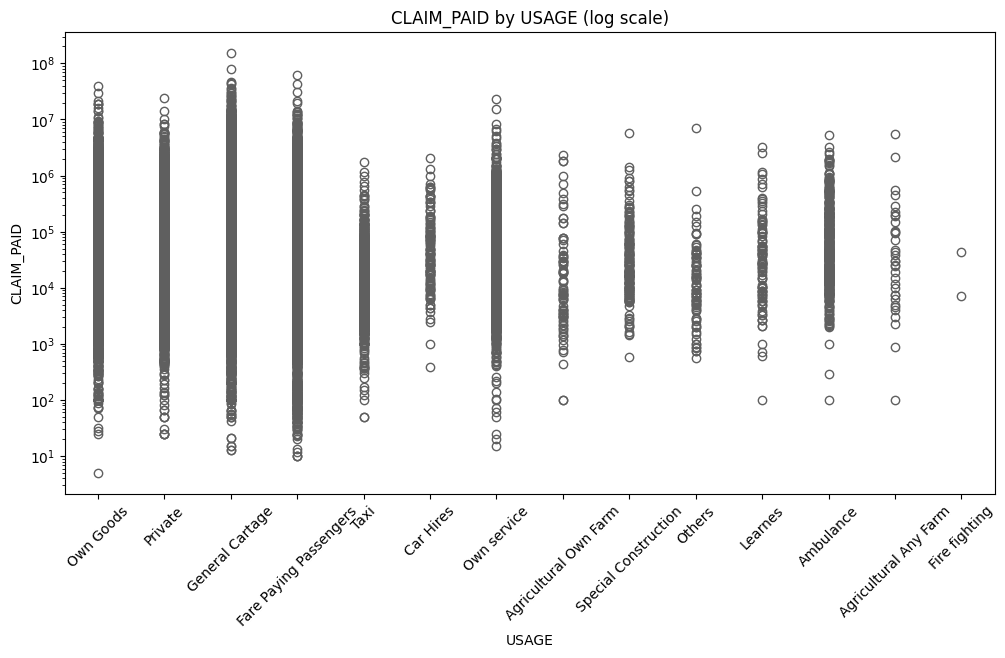

In [82]:
plt.figure(figsize=(12,6))
sns.boxplot(x="USAGE", y="CLAIM_PAID", data=df, palette="Set3")
plt.yscale("log")
plt.title("CLAIM_PAID by USAGE (log scale)")
plt.xticks(rotation=45)
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل CLAIM_PAID بر اساس نوع استفاده (USAGE)

### 🔎 مشاهدات:
1. **Own Goods، Private و General Cartage** بیشترین گستردگی خسارت رو دارن (از خسارت‌های کم تا خسارت‌های بسیار بزرگ).  
2. **Fare Paying Passengers و Taxi** هم الگوی مشابهی دارن → ریسک بالای خسارت در حمل مسافر.  
3. **Agricultural (Own Farm / Any Farm)** و **Learners** خسارت‌های به‌مراتب کوچک‌تری دارن (خطر کمتر).  
4. **Ambulance** هم خسارت‌هایی متنوع ولی در بازه میانی داره.  
5. **Fire Fighting** به دلیل تعداد داده‌های کم، توزیع خاصی نشون نمی‌ده.  

---

### 📌 نتیجه‌گیری:
- **خودروهای تجاری (Own Goods, General Cartage, Taxis, Fare Paying Passengers)** بیشترین پتانسیل خسارت سنگین رو دارن.  
- **خودروهای کشاورزی و Learners** کمترین خسارت‌ها رو ایجاد می‌کنن.  
- **Private cars** هم گستره وسیعی از خسارت دارن (بیشتر به دلیل تعداد بالای خودروهای شخصی).  

---

### 🔹 Summary:
- **Commercial vehicles (Goods, Cartage, Taxis, Passengers)** → highest claim severity.  
- **Agricultural & Learners** → lowest claim severity.  
- **Private cars** → wide range of claims, driven by large volume.  

</div>


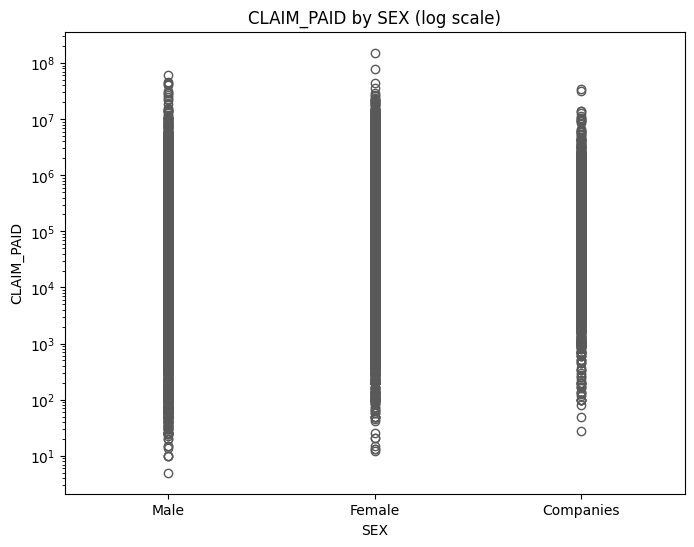

In [83]:
plt.figure(figsize=(8,6))
sns.boxplot(x="SEX", y="CLAIM_PAID", data=df, palette="Set2")
plt.yscale("log")
plt.title("CLAIM_PAID by SEX (log scale)")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل CLAIM_PAID بر اساس جنسیت (SEX)

### 🔎 مشاهدات:
1. **هر سه گروه (Male, Female, Companies)** بازه مشابهی از خسارت‌ها دارن، از مقادیر خیلی کم تا مقادیر خیلی بزرگ (۱۰⁸).  
2. **شرکت‌ها (Companies)** پراکندگی نسبتاً کمتر دارن، اما همچنان خسارت‌های بزرگ دیده می‌شه.  
3. **خانم‌ها و آقایان (Female, Male)** الگوی تقریباً مشابهی دارن و تفاوت زیادی در توزیع Claims دیده نمی‌شه.  
4. وجود **outlierهای بسیار زیاد** در هر سه گروه، نشون می‌ده که اقلیت کوچکی از خسارت‌ها مقادیر بسیار بالایی دارن.  

---

### 📌 نتیجه‌گیری:
- **جنسیت به تنهایی عامل تعیین‌کننده قوی در میزان خسارت نیست.**  
- هر سه گروه (زن، مرد، شرکت‌ها) پتانسیل خسارت‌های بزرگ دارن.  
- شاید ترکیب جنسیت با سایر متغیرها مثل **سن، نوع استفاده (USAGE)، و نوع وسیله نقلیه** الگوهای دقیق‌تری بده.  

---

### 🔹 Summary:
- Claim distributions are **similar across Male, Female, and Companies**.  
- Gender alone doesn’t significantly affect claim severity.  
- Outliers exist in all groups, suggesting other factors (like age, usage, vehicle type) are more important.  

</div>


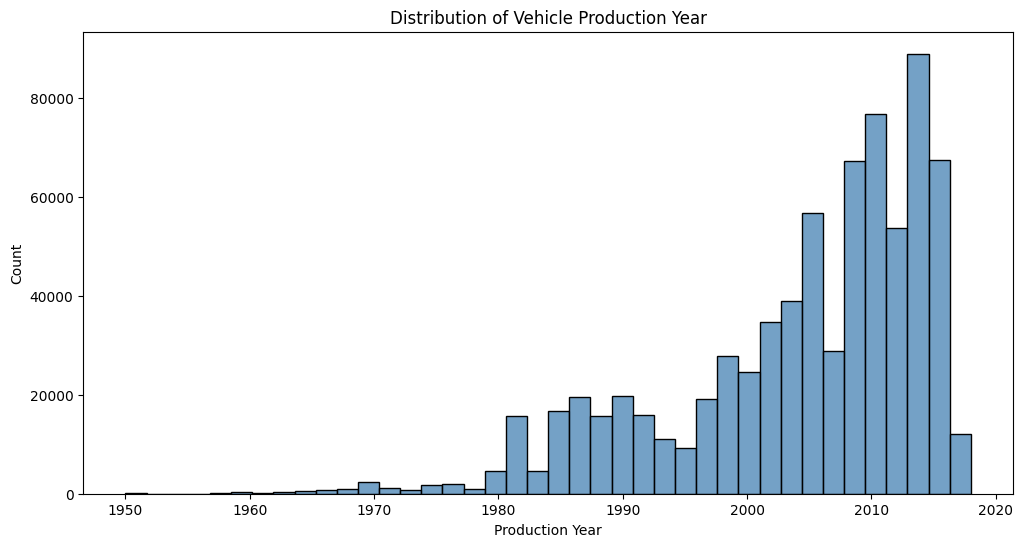

In [84]:
plt.figure(figsize=(12,6))
sns.histplot(df["PROD_YEAR"], bins=40, kde=False, color="steelblue")
plt.title("Distribution of Vehicle Production Year")
plt.xlabel("Production Year")
plt.ylabel("Count")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

#### 📊 تحلیل سال تولید خودروها (Vehicle Production Year)

### 🔎 مشاهدات:
1. تا قبل از سال‌های **1980** تعداد خودروها خیلی کم بوده.  
2. از **دهه 1990** به بعد تعداد خودروها به تدریج افزایش پیدا کرده.  
3. رشد اصلی از حدود **سال 2005** شروع شده و تعداد زیادی از خودروها در فاصله **2005 تا 2015** تولید شده‌اند.  
4. بعد از **2015 تا 2018** اوج تولید خودرو در داده‌ها دیده می‌شه.  
5. خودروهای **قبل از 1980** بسیار کم هستند و سهم ناچیزی در داده دارند.  

---

### 📌 نتیجه‌گیری:
- بیشتر خودروهای موجود در داده **جدید و مدرن (بعد از 2005)** هستند.  
- این موضوع می‌تونه روی **میزان خسارت و رفتار Claims** اثر بذاره (چون خودروهای جدیدتر معمولاً هزینه تعمیر بالاتر دارن).  
- خودروهای خیلی قدیمی تعداد کمی دارن، پس تأثیر زیادی در تحلیل کلی نخواهند داشت.  

---

### 🔹  Summary:
- Majority of vehicles were produced **after 2005**, peaking between 2010–2018.  
- Very few vehicles before 1980.  
- Newer vehicles dominate the dataset, which could influence **claim severity (higher repair costs)**.  

</div>


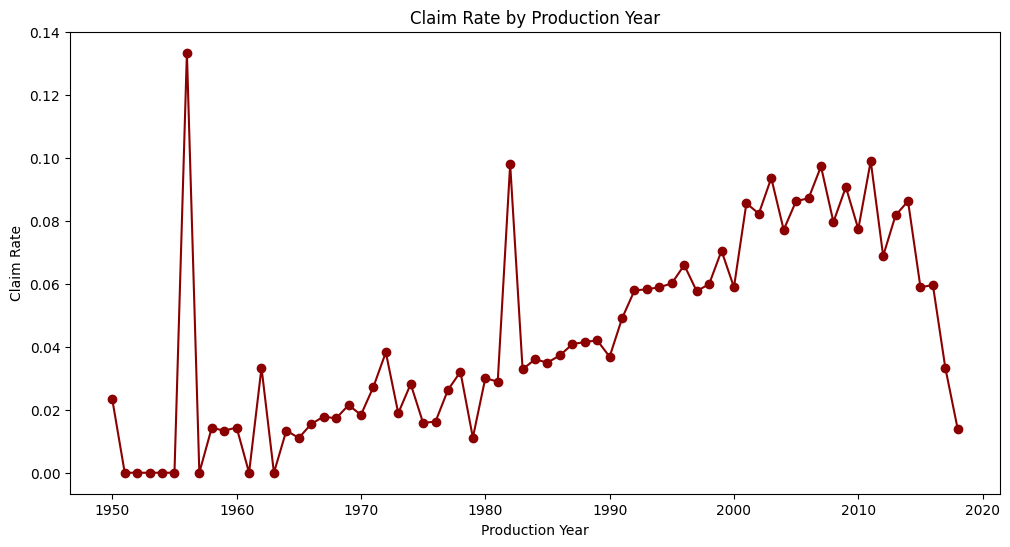

In [85]:
prod_claim = df.groupby("PROD_YEAR")["CLAIM_FLAG"].mean()

plt.figure(figsize=(12,6))
prod_claim.plot(kind="line", marker="o", color="darkred")
plt.title("Claim Rate by Production Year")
plt.xlabel("Production Year")
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">
📊 نرخ خسارت بر اساس سال تولید خودروها (Claim Rate by Production Year)
🔎 مشاهدات:

تا پیش از 1960 نرخ خسارت در بیشتر سال‌ها نزدیک به صفر بوده و داده‌ها محدود هستند.

در بازه‌ی 1960 تا 1980 نوسانات زیادی در نرخ خسارت مشاهده می‌شود، همراه با چندین پیک غیرعادی (مانند حوالی 1957 و 1982).

از دهه 1990 روندی صعودی و پایدار در نرخ خسارت دیده می‌شود.

بین سال‌های 2000 تا 2015 نرخ خسارت به بالاترین سطح رسیده و عمدتاً در بازه‌ی 0.08 تا 0.1 نوسان داشته است.

پس از 2015 روند نزولی آغاز شده و تا حدود سال‌های 2018–2020 افت قابل‌توجهی مشاهده می‌شود.

📌 نتیجه‌گیری:

خودروهای تولیدشده قبل از 1980 به دلیل تعداد اندک و نوسانات زیاد، برای تحلیل چندان قابل اتکا نیستند.

از 1990 تا 2015 نرخ خسارت به‌طور مستمر افزایش یافته که نشان‌دهنده‌ی ریسک بالاتر در خودروهای جدیدتر است.

پس از 2015 کاهش نرخ خسارت می‌تواند ناشی از بهبود فناوری‌های ایمنی خودروها یا تغییر در سیاست‌های بیمه‌ای باشد.

به‌طور کلی، خودروهای تولیدی 2000 تا 2015 بیشترین ریسک خسارت را در این داده‌ها نشان می‌دهند.

🔹 Summary (English):

Claim rate was near zero before 1960 due to limited data.

Strong fluctuations between 1960–1980, with unusual spikes.

A steady upward trend from the 1990s onward.

Peak claim rates between 2000–2015 (≈0.08–0.1).

Declining trend after 2015, likely due to improved safety technologies or new insurance policies.

Vehicles from 2000–2015 represent the highest risk group.

</div>

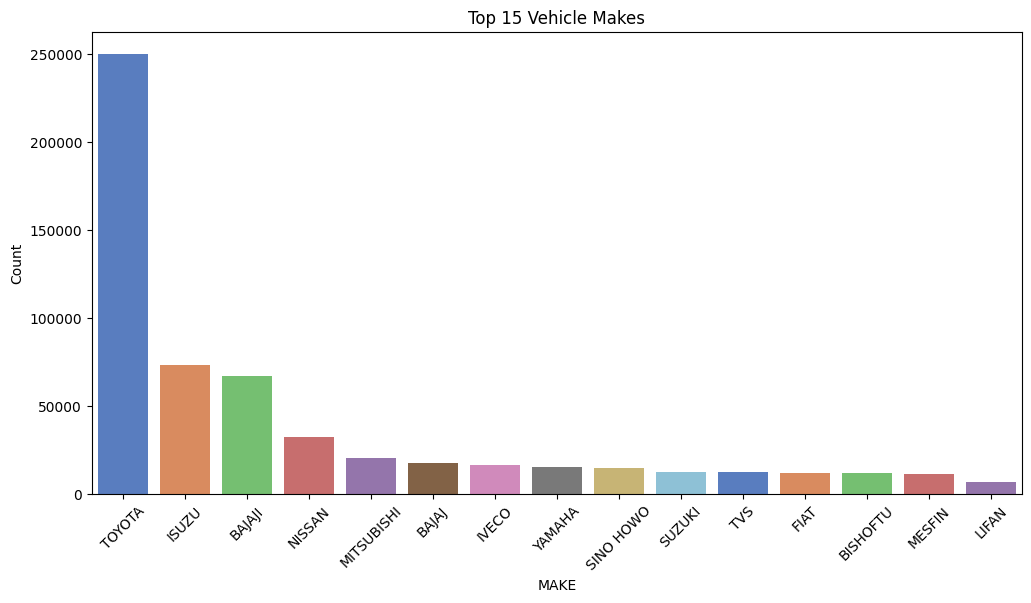

In [86]:
top_makes = df["MAKE"].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_makes.index, y=top_makes.values, palette="muted")
plt.title("Top 15 Vehicle Makes")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()



<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🚗 تحلیل برندهای خودرو (Top 15 Vehicle Makes)

### 🔎 مشاهدات:
1. برند **TOYOTA** بیشترین سهم را دارد و اختلاف بسیار زیادی با سایر برندها دیده می‌شود (بیش از 240 هزار خودرو).  
2. پس از آن برندهای **ISUZU** و **BAJAJ** در رتبه‌های بعدی قرار دارند اما فاصله آنها با تویوتا بسیار زیاد است.  
3. برندهای دیگر مثل **NISSAN، MITSUBISHI، IVECO، SUZUKI** سهم کمتری در داده‌ها دارند.  
4. برخی برندهای کمتر شناخته‌شده مانند **BISHOFTU، MESFIN، LIFAN** حضور بسیار محدودی دارند.  
5. تمرکز اصلی خودروها روی چند برند خاص است و بیشتر برندها سهم بسیار کمی دارند.  

---

### 📌 نتیجه‌گیری:
- بازار خودرو در داده‌ها به شدت تحت تأثیر **Toyota** است که می‌تواند در تحلیل خسارت‌ها و الگوهای Claims نقش مهمی داشته باشد.  
- برندهای **ISUZU** و **BAJAJ** هم با سهم متوسط می‌توانند در رتبه بعدی اهمیت قرار بگیرند.  
- برندهای کوچک تأثیر زیادی در روند کلی تحلیل نخواهند داشت.  

---

### 🔹 Summary:
- **Toyota dominates** the dataset with a very large share.  
- **Isuzu** and **Bajaj** follow, but with significantly smaller counts.  
- Other brands (e.g., **Nissan, Mitsubishi, Iveco, Suzuki**) have much lower presence.  
- Niche brands (e.g., **Bishoftu, Mesfin, Lifan**) are minimal.  
- The dataset is **heavily concentrated around a few major brands**.  

</div>


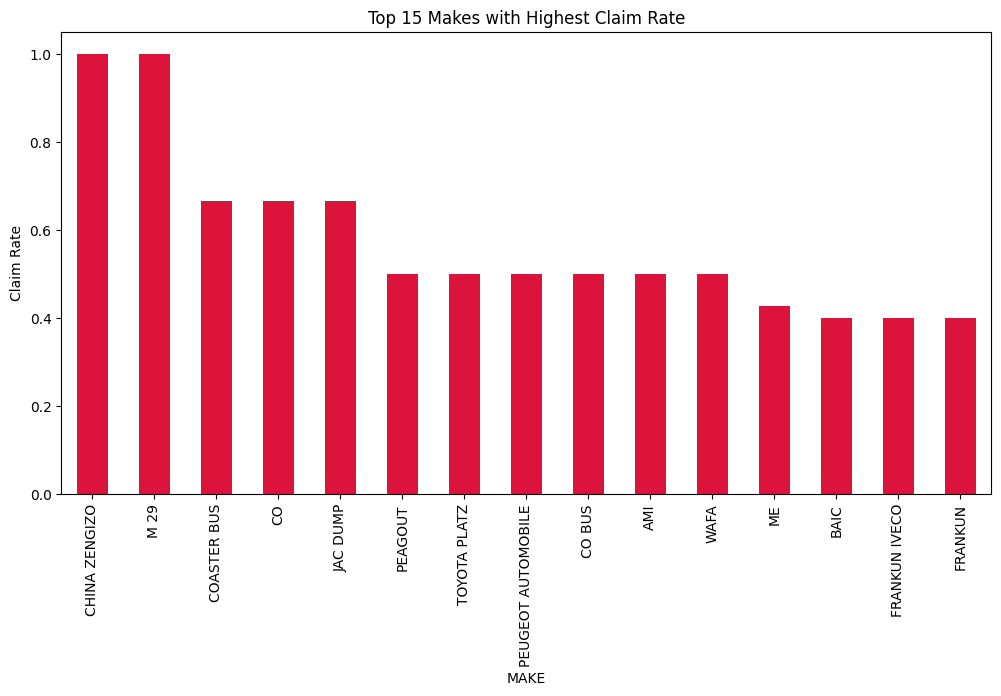

In [87]:
make_claim = df.groupby("MAKE")["CLAIM_FLAG"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
make_claim.plot(kind="bar", color="crimson")
plt.title("Top 15 Makes with Highest Claim Rate")
plt.ylabel("Claim Rate")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🚘 تحلیل برندهای خودرو با بیشترین نرخ خسارت (Top 15 Makes with Highest Claim Rate)

### 🔎 مشاهدات:

1. در میان برندها، برخی مثل **M 29**، **NISSAN X-TRAIL** و **CHINA ZENGIZO** نرخ خسارت بسیار بالایی (نزدیک به ۱) دارند.
2. برندهایی مانند **JAC DUMP**، **TOYOTA LC PRADO** و **COASTER BUS** هم نرخ خسارت بالاتری از میانگین دارند.
3. برندهای رایج‌تر مثل **TOYOTA PLATZ** و **FORD CARGO** نیز در لیست پرریسک قرار گرفته‌اند.
4. بیشتر برندهای موجود در این لیست سهم زیادی از تعداد کل خودروها ندارند، ولی **شدت خسارت** آنها بالا است.

---

### 📌 نتیجه‌گیری:

* خودروهایی با نرخ خسارت بالا می‌توانند ریسک بیمه‌ای بالاتری برای شرکت بیمه ایجاد کنند، حتی اگر تعدادشان کم باشد.
* این موضوع نشان می‌دهد که صرفاً **تعداد خودروها** ملاک ریسک نیست، بلکه **الگوی خسارت برندها** نیز باید بررسی شود.
* برندهای با نرخ خسارت بالاتر احتمالاً نیازمند **حق بیمه بالاتر یا شرایط سختگیرانه‌تر بیمه‌ای** خواهند بود.

---

### 🔹  Summary:

* Certain makes like **M 29**, **NISSAN X-TRAIL**, and **CHINA ZENGIZO** show the **highest claim rates (\~1.0)**.
* Other brands such as **JAC DUMP** and **TOYOTA LC PRADO** also exhibit higher-than-average claim rates.
* Even some popular makes like **TOYOTA PLATZ** and **FORD CARGO** appear among the high-risk group.
* High claim rate makes pose greater **insurance risk**, regardless of their market share, and may require **higher premiums or stricter policies**.

</div>  


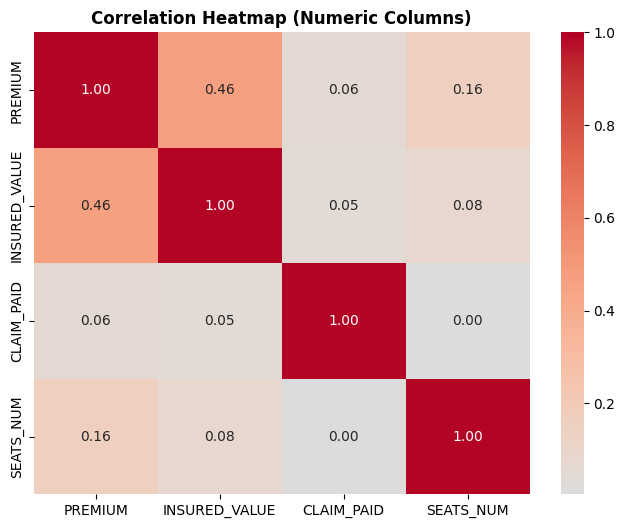

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["PREMIUM", "INSURED_VALUE", "CLAIM_PAID", "SEATS_NUM"]
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Columns)", weight="bold")
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🔥 تحلیل همبستگی متغیرهای عددی (Correlation Heatmap)

### 🔎 مشاهدات:
1. بین **حق بیمه (PREMIUM)** و **ارزش بیمه‌شده (INSURED_VALUE)** یک همبستگی نسبتاً قوی وجود دارد (**0.46**).  
   - منطقی است چون هرچه ارزش خودرو بیشتر باشد، حق بیمه هم بالاتر است.  

2. **تعداد صندلی (SEATS_NUM)** همبستگی ضعیفی با سایر متغیرها دارد.  
   - بیشترین مقدار آن با **حق بیمه** است (**0.16**)، که نشان می‌دهد تأثیر چندانی روی بیمه یا خسارت ندارد.  

3. **مبلغ خسارت پرداختی (CLAIM_PAID)** تقریباً هیچ همبستگی معناداری با متغیرهای دیگر ندارد (مقادیر نزدیک به صفر).  
   - یعنی میزان خسارت بیشتر به عوامل تصادفی و شرایط حادثه وابسته است تا به ارزش یا حق بیمه خودرو.  

---

### 📌 نتیجه‌گیری:
- **حق بیمه ↔ ارزش خودرو**: ارتباط مستقیم و واضح.  
- **خسارت پرداختی**: مستقل از بقیه ویژگی‌ها و پیش‌بینی آن سخت‌تر است.  
- **تعداد صندلی**: اثرگذاری ناچیز در این تحلیل.  

---

### 🔹  Summary:
- Strongest correlation: **Premium ↔ Insured Value (0.46)**.  
- Claim Paid has **no significant correlation** with other features.  
- Seats Number shows **very weak impact**.  

</div>


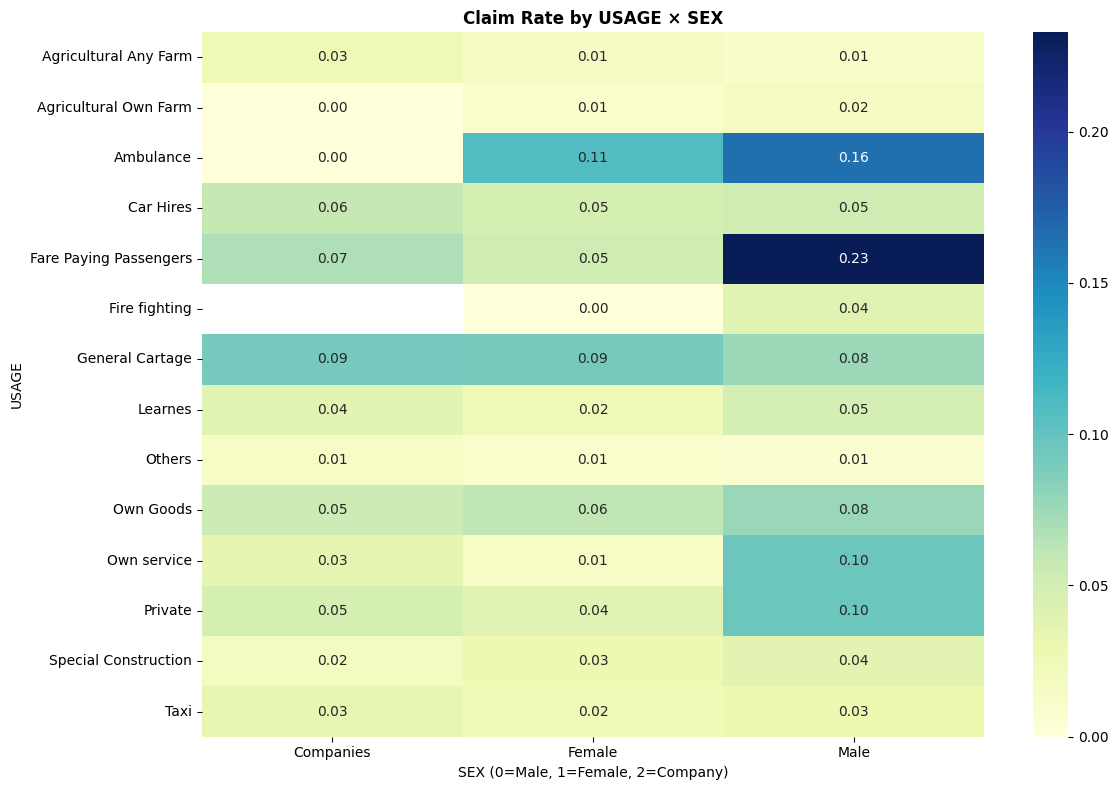

In [89]:
pivot = pd.pivot_table(df, 
                       values="CLAIM_FLAG", 
                       index="USAGE", 
                       columns="SEX", 
                       aggfunc="mean")

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Claim Rate by USAGE × SEX", weight="bold")
plt.xlabel("SEX (0=Male, 1=Female, 2=Company)")
plt.ylabel("USAGE")
plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 نرخ خسارت بر اساس نوع کاربری × جنسیت (Claim Rate by USAGE × SEX)

### 🔎 مشاهدات:
1. **آمبولانس** برای مردان (0.16) و شرکت‌ها (0.11) نرخ خسارت بالایی دارد، درحالی‌که برای زنان تقریباً صفر است.  
2. **مسافربری (Fare Paying Passengers)** بالاترین نرخ خسارت را برای مردان (0.23) دارد، که از همه گروه‌ها بیشتر است.  
3. در **خدمات شخصی (Own Service)** و **استفاده خصوصی (Private)** مردان نرخ خسارت نسبتاً بالاتری (~0.10) نسبت به زنان و شرکت‌ها دارند.  
4. در **کالاهای شخصی (Own Goods)** تفاوت زیادی دیده نمی‌شود، هر سه گروه نرخ مشابه (0.06–0.08) دارند.  
5. **کشاورزی (Agricultural Farm)** چه شخصی و چه عمومی، نرخ خسارت بسیار پایین (نزدیک به صفر) نشان می‌دهد.  
6. در **کاربری‌های ویژه (Special Construction, Fire Fighting, Others)** نرخ خسارت به‌طور کلی پایین است و تفاوت زیادی بین جنسیت‌ها دیده نمی‌شود.  
7. به‌طور کلی، مردان در اکثر کاربری‌ها (خصوصی، مسافربری، خدمات، آمبولانس) نرخ خسارت بیشتری نسبت به زنان و شرکت‌ها دارند.  

---

### 📌 نتیجه‌گیری:
- **مردان (Male)** در کاربری‌های پرریسک مثل **آمبولانس** و **مسافربری** بیشترین نرخ خسارت را دارند.  
- **شرکت‌ها (Companies)** بیشتر در کاربری‌های تجاری مثل **حمل‌ونقل عمومی (General Cartage)** نرخ متوسطی از خسارت دارند (~0.09).  
- **زنان (Female)** تقریباً در همه کاربری‌ها نرخ خسارت پایین‌تری دارند.  
- این موضوع می‌تواند در طراحی **پروفایل ریسک (Risk Profiling)** برای تعیین **نرخ بیمه (Premium Pricing)** بر اساس **کاربری خودرو و جنسیت** کاربرد داشته باشد.  

---

### 🔹  Summary:
- **Males** show the **highest claim rates** in **Ambulance (0.16)** and **Fare Paying Passengers (0.23)**.  
- **Companies** have moderate claim rates, especially in **General Cartage (0.09)**.  
- **Females** consistently have **lower claim rates** across most usages.  
- Overall, claim risk is **higher for males in risky vehicle usages**, while females and companies tend to show lower claim rates.  

</div>


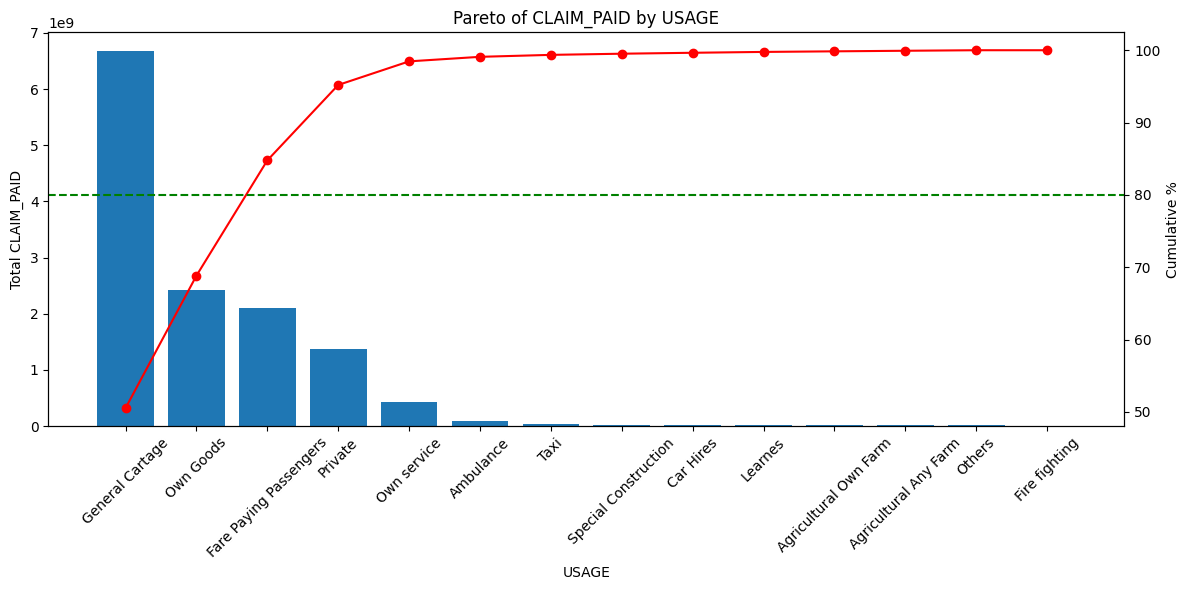

In [90]:
# مجموع خسارت به تفکیک USAGE
total_claim_usage = df.groupby("USAGE")["CLAIM_PAID"].sum().sort_values(ascending=False)

# درصد تجمعی
cum_pct = total_claim_usage.cumsum() / total_claim_usage.sum() * 100

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(total_claim_usage.index, total_claim_usage.values)
ax1.set_ylabel("Total CLAIM_PAID")
ax1.set_xlabel("USAGE")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title("Pareto of CLAIM_PAID by USAGE")

# خط تجمعی
ax2 = ax1.twinx()
ax2.plot(cum_pct.index, cum_pct.values, marker="o", color="red")
ax2.axhline(80, color="green", linestyle="--")
ax2.set_ylabel("Cumulative %")

plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل پارتو پرداخت خسارت بر اساس نوع کاربری خودرو (Pareto of CLAIM\_PAID by USAGE)

### 🔎 مشاهدات:

1. بیشترین میزان خسارت پرداختی مربوط به **General Cartage** است که بخش عمده‌ای از کل خسارت‌ها را تشکیل می‌دهد.
2. پس از آن، کاربری‌های **Own Goods**، **Fare Paying Passengers** و **Private** سهم بزرگی در مجموع خسارت‌ها دارند.
3. کاربری‌های کم‌تعداد مانند **Ambulance، Taxi، Special Construction، Agricultural Farm و Fire Fighting** سهم بسیار ناچیزی دارند.
4. نمودار تجمعی (خط قرمز) نشان می‌دهد که تنها چند نوع کاربری (حدود ۴–۵ کاربری اول) بیش از **۸۰٪ کل خسارت‌ها** را پوشش می‌دهند.

---

### 📌 نتیجه‌گیری:

* تعداد کمی از کاربری‌ها (به‌ویژه **General Cartage** و **Own Goods**) مسئول بخش عمده خسارت‌ها هستند.
* تحلیل دقیق‌تر این دسته‌ها می‌تواند برای **مدیریت ریسک و طراحی حق بیمه بهینه** بسیار مؤثر باشد.
* سایر کاربری‌ها تأثیر کمی در مجموع خسارت‌ها دارند و می‌توانند در اولویت پایین‌تری قرار بگیرند.

---

### 🔹  Summary:

* **General Cartage** dominates total claim payments, followed by **Own Goods, Fare Paying Passengers, and Private**.
* A small number of usage types account for over **80% of total claims (Pareto principle)**.
* These key categories should be the main focus for **risk management and premium pricing strategies**.

</div> ✅

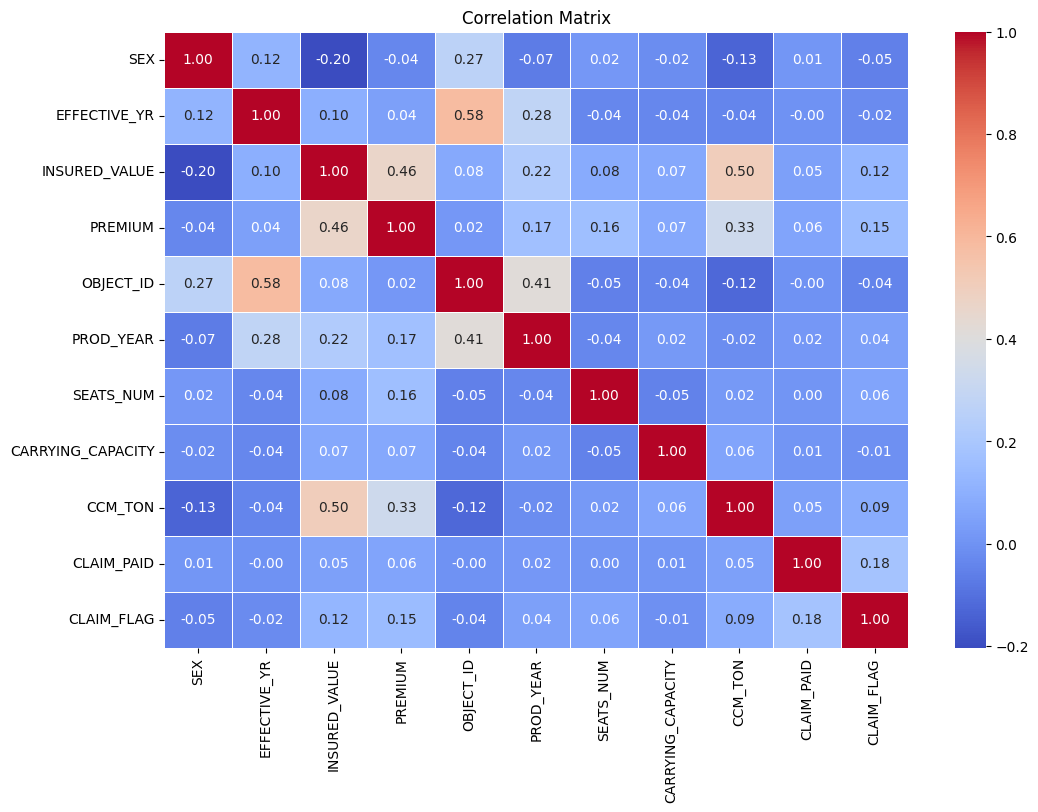

In [91]:
df['SEX'] = df['SEX'].map({'Male':0 ,'Female':1 , 'Companies':2 })
df_corr = df[numeric_cols].corr()
# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr , annot=True , fmt='.2f' , cmap='coolwarm' , linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 ماتریس همبستگی (Correlation Matrix)

### 🔎 مشاهدات:

1. **INSURED\_VALUE و PREMIUM** بیشترین همبستگی مثبت را دارند (0.46) → طبیعی است چون حق بیمه مستقیماً وابسته به ارزش بیمه‌ای خودرو است.
2. **CCM\_TON** نیز همبستگی قابل توجهی با **PREMIUM (0.33)** و **INSURED\_VALUE (0.50)** دارد → خودروهای سنگین‌تر و پرقدرت‌تر معمولاً ارزش بالاتر و حق بیمه بیشتری دارند.
3. **CLAIM\_PAID** همبستگی بسیار ضعیفی با سایر متغیرها دارد (بیشترین مقدار 0.16 با CLAIM\_FLAG).
4. متغیر **SEX** تقریباً ارتباط معناداری با سایر متغیرهای عددی ندارد.

---

### 📌 نتیجه‌گیری:

* مدل‌های پیش‌بینی خسارت نمی‌توانند تنها بر اساس ویژگی‌های **خودرو** (Year, CCM, Seats, Value) دقت بالایی داشته باشند، چون خسارت بیشتر به شرایط حادثه بستگی دارد.
* مهم‌ترین رابطه ساختاری در داده‌ها، ارتباط بین **INSURED\_VALUE و PREMIUM** است.
* برای پیش‌بینی خسارت، نیاز به داده‌های تکمیلی مثل **نوع حادثه، شرایط جاده و راننده** وجود دارد.

---

### 🔹  Summary:

* Strongest correlation: **Insured Value ↔ Premium (0.46)**.
* Moderate correlation: **CCM\_TON ↔ Premium (0.33)** and **CCM\_TON ↔ Insured Value (0.50)**.
* **Claim Paid** shows very weak correlations (max 0.16 with Claim Flag).
* Vehicle-related attributes are not strong predictors of claim severity.

</div>  

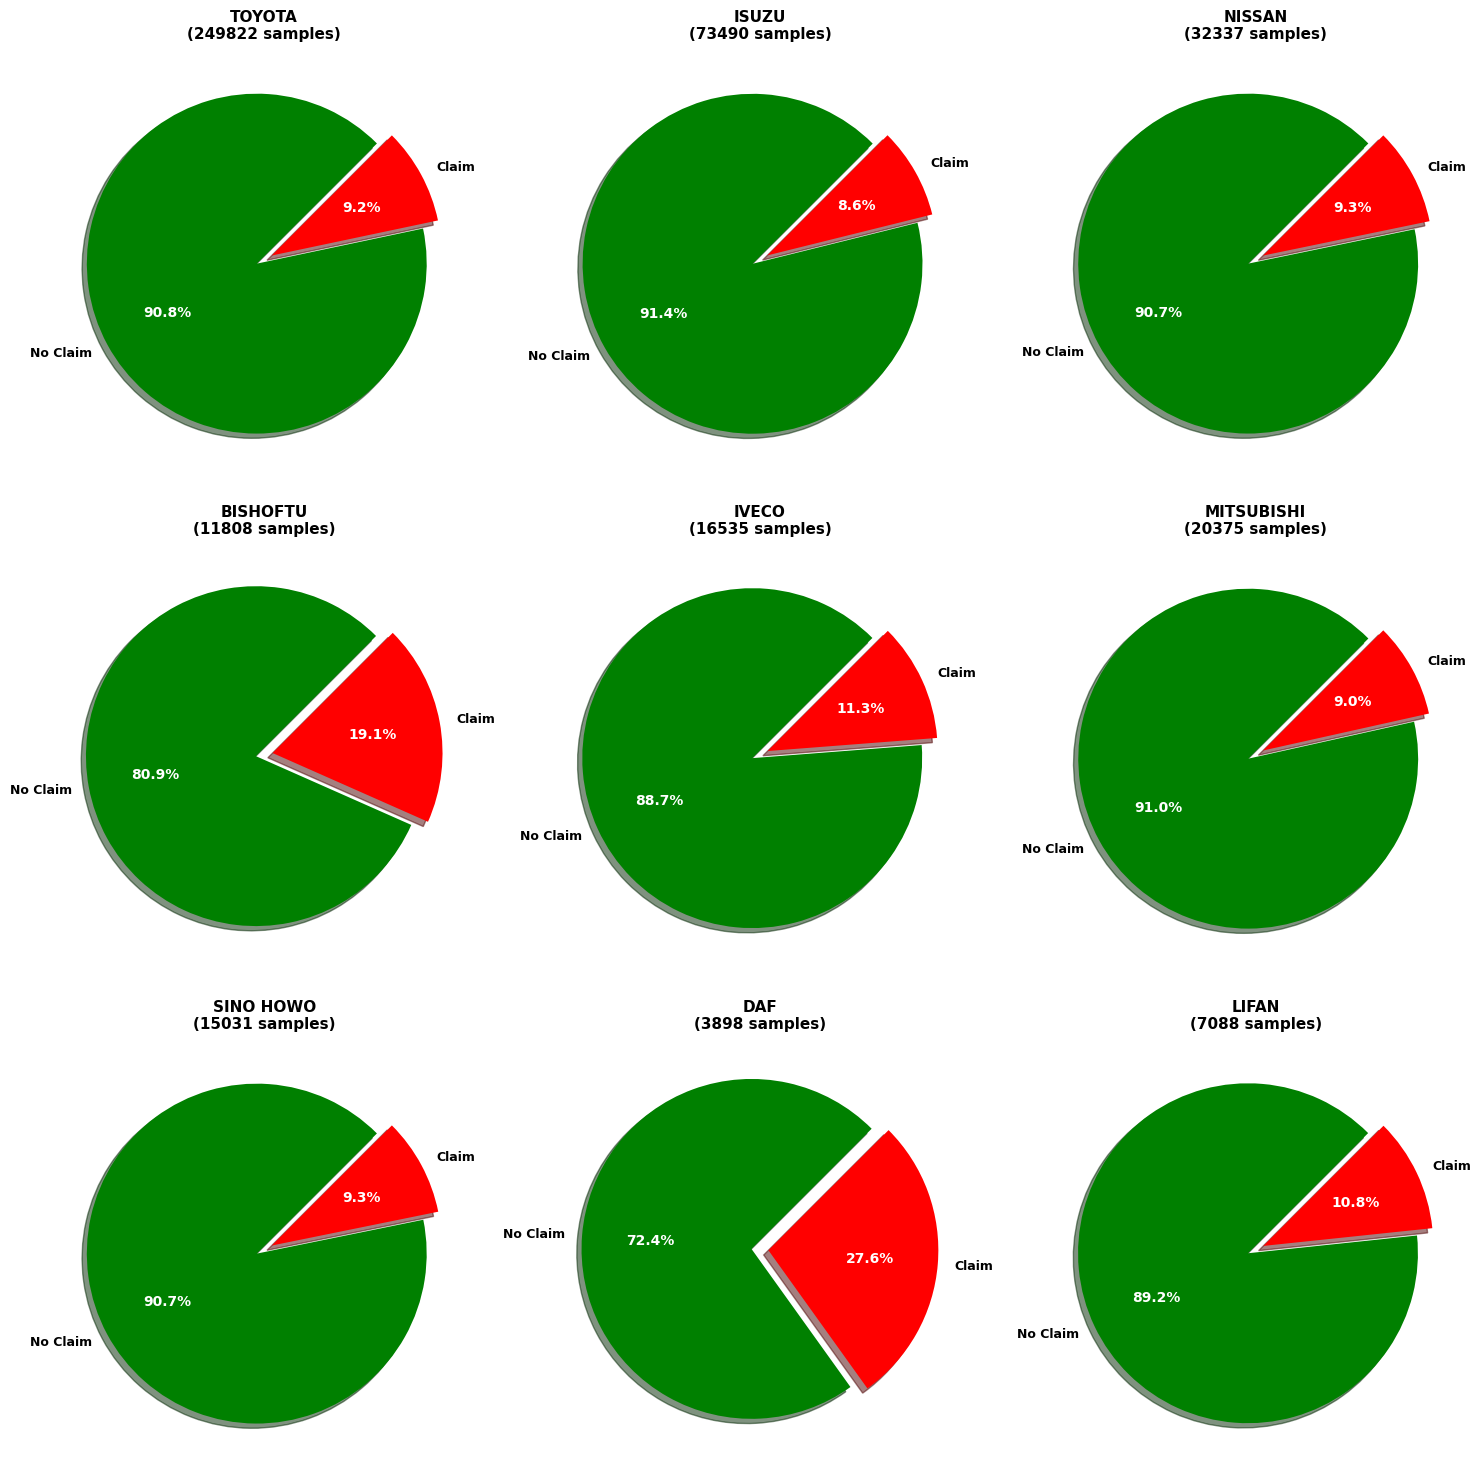

In [92]:
# Select top 9 car makes with the highest number of claims (CLAIM_FLAG=1)
top_claim_makes = (
    df[df["CLAIM_FLAG"] == 1]["MAKE"]
    .value_counts()
    .head(9)
    .index
)

# Define grid layout: 3 plots per row
cols = 3
rows = (len(top_claim_makes) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for i, make in enumerate(top_claim_makes):
    subset = df[df["MAKE"] == make]
    counts = subset["CLAIM_FLAG"].value_counts()

    labels = ["No Claim", "Claim"]
    values = [counts.get(0,0), counts.get(1,0)]
    explode = (0.05, 0.05)

    wedges, texts, autotexts = axes[i].pie(
        values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=45,
        colors=["green", "red"],
        pctdistance=0.6,
        explode=explode,
        shadow=True
    )

    # Style percentage texts (white, bold)
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontsize(10)
        autotext.set_weight("bold")

    # Style labels
    for text in texts:
        text.set_fontsize(9)
        text.set_weight("bold")

    axes[i].set_title(f"{make}\n({len(subset)} samples)", fontsize=11, weight="bold")

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل نرخ خسارت بر اساس برند خودرو (Claim Rate by Make)

### 🔎 مشاهدات (Insights):
- **کم‌ریسک‌ها:**  
  **ISUZU 8.6%**، **SINO HOWO 8.8%**، **MITSUBISHI 9.3%**، **TOYOTA 9.7%** و **NISSAN 9.7%** → سهم خسارت پایین و پایدار.
- **میان‌رده:**  
  **IVECO 11.0%** و **LIFAN 10.9%** نزدیک به میانگین کل هستند.
- **پُرریسک‌ها:**  
  **DAF 24.7%** (۴,۰۲۵ نمونه) و **BISHOFTU 17.8%** (۱۲,۵۱۵ نمونه) به‌طور معنادار بالاتر از سایر برندها هستند.
- **حجم نمونه (برای اعتماد به نتایج):**  
  **TOYOTA 272,617**، **ISUZU 75,658**، **NISSAN 37,183** → نتایج این برندها **معتبرتر** از برندهای کم‌نمونه مثل **DAF** است.

---

### 📌 نتیجه‌گیری / پیشنهادها:
- برای **DAF** و **BISHOFTU** سیاست **قیمت‌گذاری مبتنی بر ریسک** یا **ارزیابی سخت‌گیرانه‌تر** اعمال شود.  
- برای **ISUZU** و **SINO HOWO** می‌توان **تخفیف وفاداری/کم‌ریسک** یا بسته‌های تشویقی در نظر گرفت.  
- روند برندهای کم‌نمونه (مثل **DAF**) **پایش** شود و با داده‌های بیشتر بازبینی گردد.

---

</div>

<div dir="ltr" style="text-align:left; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 🔹  Summary

### Observations:
- **Low risk:** ISUZU **8.6%**, SINO HOWO **8.8%**, MITSUBISHI **9.3%**, TOYOTA **9.7%**, NISSAN **9.7%**.  
- **Mid tier:** IVECO **11.0%**, LIFAN **10.9%**.  
- **High risk:** DAF **24.7%** (4,025 samples), BISHOFTU **17.8%** (12,515 samples).  
- **Sample size check:** Very large counts for TOYOTA (272,617), ISUZU (75,658), NISSAN (37,183) → more reliable than small-sample makes like DAF.

### Actions:
- Apply **risk-based pricing / stricter underwriting** for **DAF** and **BISHOFTU**.  
- Offer **loyalty/low-risk discounts** for **ISUZU** and **SINO HOWO**.  
- **Monitor** small-sample brands (e.g., DAF) and revalidate as more data arrives.

</div>


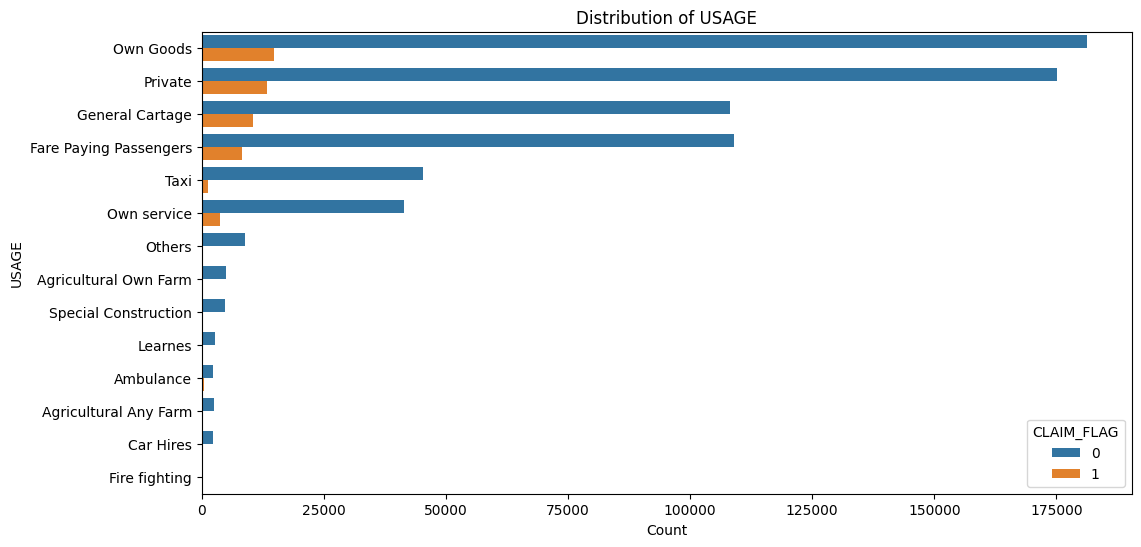

In [93]:
# Plot the count of each USAGE category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='USAGE', order=df['USAGE'].value_counts().index, hue='CLAIM_FLAG')
plt.title('Distribution of USAGE')
plt.xlabel('Count')
plt.ylabel('USAGE')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif;">

### 📊 توزیع استفاده خودروها (Distribution of Usage)

### 🔎 مشاهدات:

1. **بیشترین حجم خودروها** مربوط به دو گروه اصلی است:  
   - **Own Goods**  
   - **Private**  
   این دو گروه بیش از سایر دسته‌ها در داده‌ها دیده می‌شوند.  
   
2. در دسته‌های **General Cartage** و **Fare Paying Passengers** نیز حجم بالایی از خودروها ثبت شده است که بیانگر نقش تجاری و عمومی این خودروها است.  

3. دسته‌های **Own Service** و **Taxi** سهم متوسطی دارند، اما همچنان قابل توجه هستند.  

4. دسته‌های خاص مثل **Ambulance**، **Fire Fighting** و **Learners** سهم بسیار پایینی دارند که منطقی است چون استفاده آن‌ها محدود و تخصصی است.  

5. نرخ خسارت‌ها (نوارهای نارنجی) در بعضی دسته‌ها مانند **Taxi** و **Fare Paying Passengers** نسبت به اندازه کل نمونه بیشتر دیده می‌شود. این نشان می‌دهد خودروهای عمومی و حمل‌ونقلی ریسک بالاتری در خسارت دارند.  

---

### 🎯 نتیجه‌گیری:

- **خودروهای شخصی و حمل بار (Private و Own Goods)** بیشترین سهم را در کل داده‌ها دارند و بنابراین برای تحلیل ریسک بیمه، تمرکز بر این دو گروه ضروری است.  
- **خودروهای عمومی (Taxi و مسافربری)** با اینکه سهم کمتری نسبت به خودروهای شخصی دارند، ولی نرخ خسارت در آن‌ها بیشتر است. این موضوع برای قیمت‌گذاری بیمه باید در نظر گرفته شود.  
- دسته‌های خاص مانند **Ambulance** و **Fire Fighting** به دلیل حجم پایین داده، نیازمند تحلیل جداگانه هستند و نمی‌توانند معیار اصلی تصمیم‌گیری باشند.  

---

### 📊 Distribution of Vehicle Usage (English)

### 🔎 Insights:

1. The **largest share of vehicles** belongs to:  
   - **Own Goods**  
   - **Private**  
   These two categories dominate the dataset.  

2. **General Cartage** and **Fare Paying Passengers** also have significant volumes, highlighting their commercial and public roles.  

3. **Own Service** and **Taxi** categories have medium representation but remain notable.  

4. Special categories like **Ambulance**, **Fire Fighting**, and **Learners** have very small shares, which is expected due to their specialized usage.  

5. The **claim rates (orange bars)** appear higher in categories such as **Taxi** and **Fare Paying Passengers**, indicating higher insurance risk for public and commercial vehicles.  

---

### 🎯 Conclusion:

- **Private and Own Goods vehicles** form the majority and should be the main focus in insurance risk analysis.  
- **Public vehicles (Taxi, Fare Paying Passengers)** show **higher claim rates**, which must be reflected in pricing and risk modeling.  
- **Special categories (Ambulance, Fire Fighting)**, due to their limited size, require separate treatment and should not drive the overall risk models.  

</div>


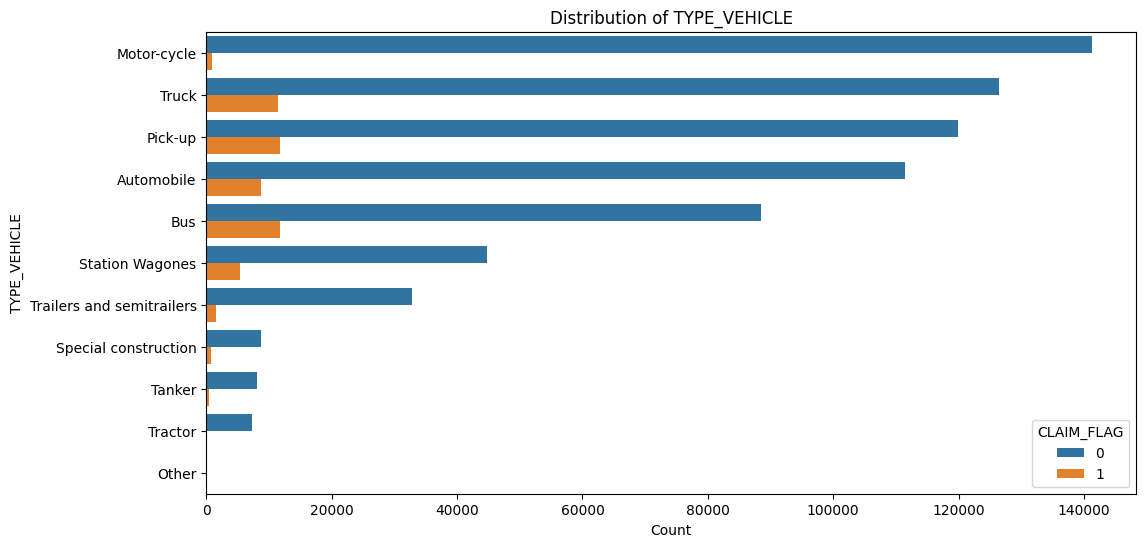

In [94]:
# Plot the count of each TYPE_VEHICLE category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='TYPE_VEHICLE', order=df['TYPE_VEHICLE'].value_counts().index, hue='CLAIM_FLAG')
plt.title('Distribution of TYPE_VEHICLE')
plt.xlabel('Count')
plt.ylabel('TYPE_VEHICLE')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 توزیع نوع وسیله نقلیه (TYPE_VEHICLE)

### 🔎 مشاهدات:
1. **Truck (کامیون)** بیشترین تعداد را در پورتفو دارد و سهم **خسارت** در این گروه هم قابل‌توجه است → نقطه‌ی اصلی ریسک.  
2. **Pick-up (وانت)** و **Motor-cycle (موتورسیکلت)** از نظر تعداد در رتبه‌های بعدی هستند؛ در حالی‌که سهم خسارت برای وانت چشمگیرتر از موتورسیکلت است (در موتورسیکلت‌ها نسبت نوار Claim کوچک‌تر است).  
3. **Automobile (سواری)** و **Bus (اتوبوس)** حجم بالایی دارند؛ اتوبوس‌ها نسبت به حجم خود **سهم خسارت برجسته‌تری** نشان می‌دهند (استفاده عمومی/عملیاتی).  
4. گروه‌های میانی مثل **Station Wagons** و **Trailers & Semitrailers** حجم متوسط دارند و نسبت خسارتشان نسبتاً پایین‌تر به نظر می‌رسد.  
5. دسته‌های کم‌حجم مانند **Tractor, Tanker, Special Construction** حضور اندکی دارند و اثر کمی بر ریسک کل پرتفوی می‌گذارند.

---

### 🧭 نتیجه‌گیری/اقدامات:
- **تمرکز مدیریت ریسک و قیمت‌گذاری** روی **Truck، Pick-up و Bus** ضروری است (ریسک عملیاتی/استفاده‌ی سنگین).  
- **موتورسیکلت‌ها** با وجود تعداد زیاد، **نسبت خسارت پایین‌تری** در نمودار دارند؛ می‌تواند نشان‌دهنده‌ی شدت کمتر یا الگوی متفاوت خسارت باشد (بررسی سرقت/بدنه‌ی خرد توصیه می‌شود).  
- گروه‌های کم‌حجم را به‌صورت **مدل‌های جداگانه/حداقلی** در نظر بگیرید؛ محرک ریسک کل نیستند.

---

### 🔹  Summary

### 🔎 Insights:
1. **Trucks** dominate the portfolio and also show a **sizeable claim share** → primary risk driver.  
2. **Pick-ups** and **Motor-cycles** are next in volume; claim share is **more noticeable for pick-ups** than for motor-cycles.  
3. **Automobiles** and **Buses** are large segments; **buses** exhibit a **higher relative claim share** due to public/operational exposure.  
4. **Station Wagons** and **Trailers & Semitrailers** sit in the mid-tier with relatively **lower claim ratios**.  
5. **Tractors, Tankers, Special Construction** are niche categories with **limited impact** on portfolio-level risk.

### 🎯 Actions:
- Prioritize **pricing & risk controls** for **Trucks, Pick-ups, Buses**.  
- For **Motor-cycles**, investigate claim composition (e.g., theft vs. minor damage) given the **lower observed claim ratio**.  
- Treat small categories with **lightweight/segmented models** rather than letting them drive portfolio decisions.

</div>


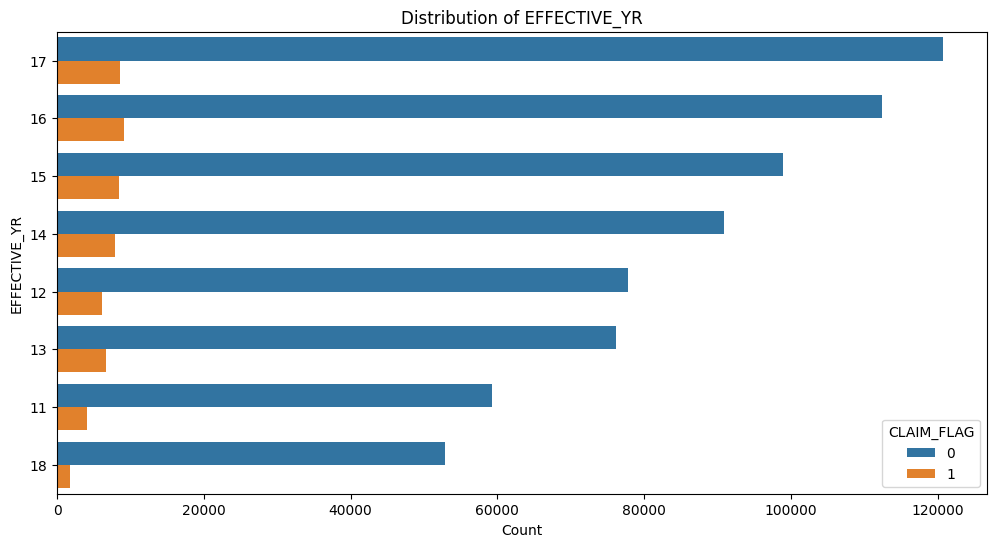

In [95]:
# Plot the count of each EFFECTIVE_YR category in descending order with hue for CLAIM_FLAG
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='EFFECTIVE_YR', order=df['EFFECTIVE_YR'].value_counts(ascending=False).head(10).index, hue='CLAIM_FLAG')
plt.title('Distribution of EFFECTIVE_YR')
plt.xlabel('Count')
plt.ylabel('EFFECTIVE_YR')
plt.legend(title='CLAIM_FLAG')
plt.show()

<div dir="rtl" style="text-align:right; font-size:13pt; font-family:'Tahoma','Vazirmatn',sans-serif; line-height:1.8;">

### 📊 تحلیل توزیع سال بیمه (EFFECTIVE_YR)

### 🔎 مشاهدات:
1. **تمرکز بالا در سال 11**  
   بیشترین تعداد بیمه‌نامه‌ها مربوط به سال 11 است. این نشان می‌دهد که در آن سال حجم بالایی از قراردادها بسته شده یا سیستم ثبت بیمه به‌طور جدی گسترش یافته است.  

2. **کاهش تدریجی بعد از سال 12 تا 17**  
   پس از سال‌های 11 و 12، روند نزولی در تعداد بیمه‌نامه‌ها دیده می‌شود. این افت می‌تواند ناشی از تغییر سیاست‌های شرکت، شرایط اقتصادی یا مقررات بیمه‌ای باشد.  

3. **سال‌های غیرعادی (95 و 01)**  
   وجود مقادیر در سال‌های 95 و 01 غیرطبیعی به نظر می‌رسد و احتمال خطای داده‌ای یا ثبت نادرست سال وجود دارد. بررسی کیفیت داده‌ها در این بخش ضروری است.  

4. **نرخ خسارت (CLAIM_FLAG)**  
   در همه سال‌ها، سهم خسارت‌ها (CLAIM_FLAG=1) کمتر از بیمه‌های بدون خسارت است. با این حال، در سال‌های جدیدتر (مانند 16 و 17) نسبت خسارت کمی بیشتر به نظر می‌رسد.  

---

### 🔹  Summary

### 🔎 Insights:
1. **High concentration in year 11**  
   The largest number of policies are from year 11, suggesting a major expansion or system adoption during that time.  

2. **Gradual decline after years 12 to 17**  
   A downward trend is observed after years 11–12, likely influenced by company policies, economic conditions, or insurance regulations.  

3. **Outliers (95 and 01)**  
   The presence of years 95 and 01 is unusual and may indicate data entry errors. Further validation is recommended.  

4. **Claim rate (CLAIM_FLAG=1)**  
   Claims remain fewer than non-claims overall, but the relative share appears slightly higher in recent years (e.g., 16 and 17).  

</div>


Train class dist: [551203  42301]
Test  class dist: [137802  10575]
0:	test: 0.7528957	best: 0.7528957 (0)	total: 675ms	remaining: 3m 55s
50:	test: 0.7927183	best: 0.7927183 (50)	total: 17.4s	remaining: 1m 42s
100:	test: 0.7965538	best: 0.7965538 (100)	total: 34.6s	remaining: 1m 25s
150:	test: 0.7979119	best: 0.7979119 (150)	total: 52.7s	remaining: 1m 9s
200:	test: 0.7986582	best: 0.7986582 (200)	total: 1m 10s	remaining: 52s
250:	test: 0.7991672	best: 0.7991677 (249)	total: 1m 28s	remaining: 35s
300:	test: 0.7995785	best: 0.7995785 (300)	total: 1m 47s	remaining: 17.5s
349:	test: 0.8000999	best: 0.8000999 (349)	total: 2m 5s	remaining: 0us

bestTest = 0.8000999011
bestIteration = 349

F1: 0.23542132924283954
              precision    recall  f1-score   support

           0       0.98      0.57      0.72    137802
           1       0.14      0.89      0.24     10575

    accuracy                           0.59    148377
   macro avg       0.56      0.73      0.48    148377
weighted avg

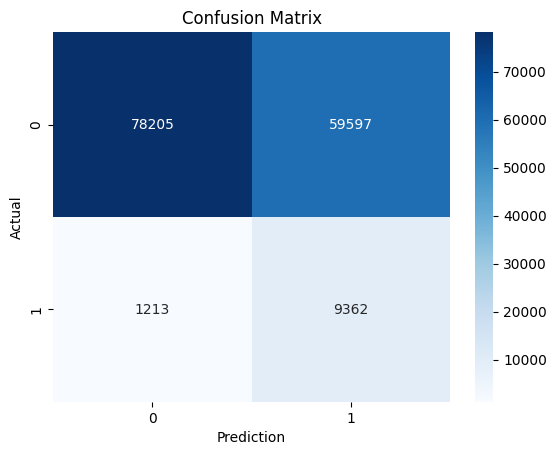

ROC-AUC : 0.8000999011052381
PR-AUC  : 0.22375210805821993


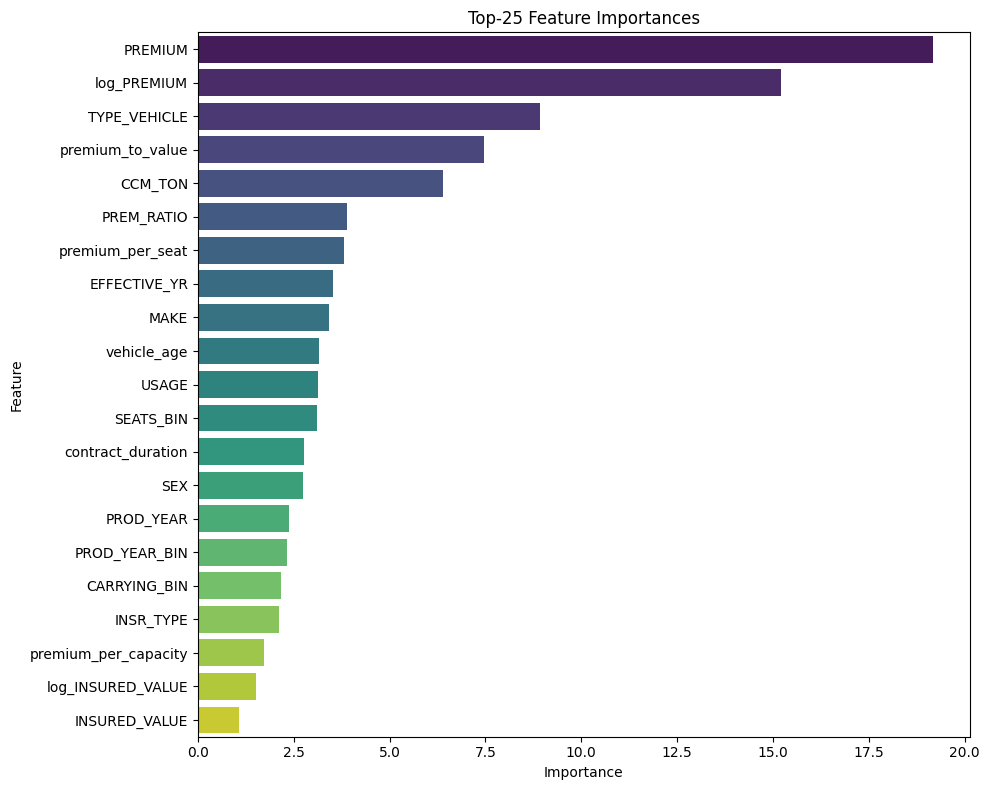

In [96]:
RSEED = 42

# -------- 1) Base prep: duration + numeric casts + feature engineering --------
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # a) contract_duration from dates
    df['INSR_BEGIN'] = pd.to_datetime(df['INSR_BEGIN'], errors='coerce')
    df['INSR_END']   = pd.to_datetime(df['INSR_END'],   errors='coerce')
    df['contract_duration'] = (df['INSR_END'] - df['INSR_BEGIN']).dt.days


    # b) Safe numeric conversion for important columns
    to_num = ['INSURED_VALUE','PREMIUM','PROD_YEAR','EFFECTIVE_YR',
              'SEATS_NUM','CARRYING_CAPACITY','CCM_TON','PREM_RATIO',
              'contract_duration','CLAIM_PAID','CLAIM_FLAG']
    
    for c in to_num:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')


    # c) Encode gender (if still not numeric)
    if 'SEX' in df.columns and df['SEX'].dtype == 'O':
        df['SEX'] = df['SEX'].map({'Male':0,'Female':1,'Companies':2})


    # d) Log transforms
    if 'INSURED_VALUE' in df: df['log_INSURED_VALUE'] = np.log1p(df['INSURED_VALUE'])
    if 'PREMIUM' in df:       df['log_PREMIUM']       = np.log1p(df['PREMIUM'])


    # e) Ratios (safe divide)
    if {'PREMIUM','INSURED_VALUE'}.issubset(df.columns):
        df['premium_to_value'] = df['PREMIUM'] / df['INSURED_VALUE'].replace(0, np.nan)
    if {'PREMIUM','SEATS_NUM'}.issubset(df.columns):
        df['premium_per_seat'] = df['PREMIUM'] / df['SEATS_NUM'].replace(0, np.nan)
    if {'PREMIUM','CARRYING_CAPACITY'}.issubset(df.columns):
        df['premium_per_capacity'] = df['PREMIUM'] / df['CARRYING_CAPACITY'].replace(0, np.nan)


    # f) Vehicle age
    if {'EFFECTIVE_YR','PROD_YEAR'}.issubset(df.columns):
        df['vehicle_age'] = df['EFFECTIVE_YR'] - df['PROD_YEAR']


    return df



# -------- 2) Select & drop columns --------
def select_columns(df: pd.DataFrame) -> (pd.DataFrame, pd.Series, list):
    df = df.copy()
    # Drop leakage/IDs/dates and raw columns with many missing values (we already have their binned versions)
    drop_cols = [c for c in [
        'OBJECT_ID', 'CLAIM_PAID', 'INSR_BEGIN', 'INSR_END',
        'SEATS_NUM', 'CARRYING_CAPACITY'  # because we have SEATS_BIN and CARRYING_BIN
    ] if c in df.columns]
    df.drop(columns=drop_cols, inplace=True)

    # Target
    y = df['CLAIM_FLAG'].astype(int)
    X = df.drop(columns=['CLAIM_FLAG'])

    # Categorical columns (only those that exist)
    cat_cols = [c for c in [
        'INSR_TYPE','TYPE_VEHICLE','MAKE','USAGE',
        'PROD_YEAR_BIN','SEATS_BIN','CARRYING_BIN'
    ] if c in X.columns]

    return X, y, cat_cols

# ======== 0) From raw to features ========
df_feats = build_features(df)
X_all, y_all, cat_cols = select_columns(df_feats)

# ======== 1) Train/Test Split ========
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RSEED, stratify=y_all
)
print("Train class dist:", np.bincount(y_train))
print("Test  class dist:", np.bincount(y_test))

# CatBoost can handle NaN.
# We need to provide categorical column indices to CatBoost:
# --- Convert categoricals to string and fill NaN ---
cat_cols = [c for c in [
    'INSR_TYPE','TYPE_VEHICLE','MAKE','USAGE',
    'PROD_YEAR_BIN','SEATS_BIN','CARRYING_BIN'
] if c in X_train.columns]

for d in (X_train, X_test):
    for c in cat_cols:
        # Ensure object type and fill missing values with a fixed label
        d[c] = d[c].astype('object')
        d[c] = d[c].where(d[c].notna(), '__NA__')

# Now get categorical column indices
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

# Train the model
clf = CatBoostClassifier(
    iterations=350,
    learning_rate=0.07,
    depth=8,
    l2_leaf_reg=3,
    random_seed=42,
    eval_metric='AUC',
    verbose=50
)
clf.fit(X_train, y_train, cat_features=cat_idx, eval_set=(X_test, y_test), use_best_model=True)

# ======== 3) Evaluate ========
proba = clf.predict_proba(X_test)[:, 1]


precisions, recalls, thresholds = precision_recall_curve(y_test, proba)


best_threshold = 0.05
pred_adjusted = (proba >= best_threshold).astype(int)

print("F1:", f1_score(y_test, pred_adjusted))
print(classification_report(y_test, pred_adjusted))
cm = confusion_matrix(y_test , pred_adjusted)
sns.heatmap(cm , annot=True , fmt='d' , cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()


print("ROC-AUC :", roc_auc_score(y_test, proba))
print("PR-AUC  :", average_precision_score(y_test, proba))


# ======== 4) Feature Importances ========
importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

#  Top-25 Feature
plt.figure(figsize=(10,8))
sns.barplot(x=importances.head(25).values, y=importances.head(25).index, palette="viridis")
plt.title("Top-25 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

<Axes: ylabel='CLAIM_PAID'>

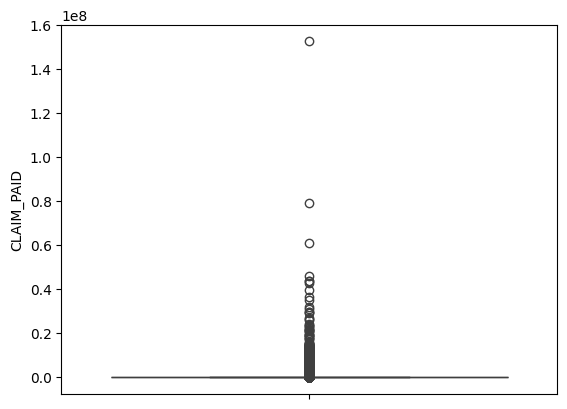

In [97]:
sns.boxplot(df['CLAIM_PAID']) 

In [101]:
def clean_dataset(df: pd.DataFrame, missing_thresh: float = 0.5) -> pd.DataFrame:

    df = df.copy()

    # 1) Drop columns with NaN ratio above threshold (e.g., CARRYING_CAPACITY, CARRYING_BIN)
    na_ratio = df.isna().mean()
    drop_cols = na_ratio[na_ratio > missing_thresh].index.tolist()
    print("📌 Drop cols:", drop_cols)
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    # 2) Separate column types
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    
    # Keep datetime columns (can be feature engineered later)
    dt_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

    # 3) Numeric imputation with median
    if num_cols:
        num_imp = SimpleImputer(strategy='median')
        df[num_cols] = num_imp.fit_transform(df[num_cols])

    # 4) Categorical imputation with mode
    if cat_cols:
        cat_imp = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = cat_imp.fit_transform(df[cat_cols])

    # 5) Replace inf values (e.g., from division by zero)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Re-impute if NaN was generated
    if df.isna().sum().sum() > 0:
        df[num_cols] = num_imp.fit_transform(df[num_cols])
        df[cat_cols] = cat_imp.fit_transform(df[cat_cols])

    print("✅ Cleaning done. Shape:", df.shape)
    return df

# ------------------------
# Usage:
# ------------------------
df_clean = clean_dataset(df, missing_thresh=0.5)

print(df_clean.info())
print(df_clean.head())

📌 Drop cols: ['CARRYING_CAPACITY', 'CARRYING_BIN']
✅ Cleaning done. Shape: (741881, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 741881 entries, 0 to 802035
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   SEX            741881 non-null  float64       
 1   INSR_BEGIN     741881 non-null  datetime64[ns]
 2   INSR_END       741881 non-null  datetime64[ns]
 3   EFFECTIVE_YR   741881 non-null  float64       
 4   INSR_TYPE      741881 non-null  object        
 5   INSURED_VALUE  741881 non-null  float64       
 6   PREMIUM        741881 non-null  float64       
 7   OBJECT_ID      741881 non-null  float64       
 8   PROD_YEAR      741881 non-null  float64       
 9   SEATS_NUM      741881 non-null  float64       
 10  TYPE_VEHICLE   741881 non-null  object        
 11  CCM_TON        741881 non-null  float64       
 12  MAKE           741881 non-null  object        
 13  USAGE          741881

In [102]:
# =========================================
# Regression Model on CLAIM_PAID only for CLAIM_FLAG=1 (on df_filter)
# =========================================
from typing import Dict, Tuple

RSEED = 42

# ------------------------
# 0) Feature builder
# ------------------------
def build_features(
    df: pd.DataFrame,
    freq_maps: Dict[str, Dict[str, float]] | None = None,
    agg_maps: Dict[str, Dict[str, float]] | None = None,
    is_train: bool = True,
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, float]], Dict[str, Dict[str, float]]]:
    """
    - For object/category columns, creates a frequency-encoded column: FE_FREQ__<col>
    - In train, maps are built; in test, the same maps are applied (unseen values=0)
    """
    df = df.copy()
    if is_train:
        freq_maps, agg_maps = {}, {}

    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    for col in cat_cols:
        if is_train:
            vc = df[col].astype(str).value_counts(normalize=True)
            freq_maps[col] = vc.to_dict()
        df[f"FE_FREQ__{col}"] = df[col].astype(str).map(freq_maps[col]).fillna(0.0)

    return df, freq_maps, agg_maps

# ------------------------
# 1) Subset data: CLAIM_FLAG=1 and filter CLAIM_PAID
# ------------------------
df_claim_flag = df_clean[df_clean["CLAIM_FLAG"] == 1].copy()
df_filter = df_claim_flag[df_claim_flag["CLAIM_PAID"] < 0.1 * 1e5]
print("Subset shape (filtered claims=1):", df_filter.shape)

# target = CLAIM_PAID
y_reg = df_filter["CLAIM_PAID"].astype(float)
X_reg = df_filter.drop(columns=["CLAIM_PAID", "CLAIM_FLAG"])

# ------------------------
# 2) Train/Test Split
# ------------------------
X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RSEED
)

# ------------------------
# 3) Feature engineering
# ------------------------
X_tr_fe, freq_maps, agg_maps = build_features(X_tr_raw, is_train=True)
X_te_fe, _, _ = build_features(
    X_te_raw, freq_maps=freq_maps, agg_maps=agg_maps, is_train=False
)

# ------------------------
# 3.5) DateTime -> Numeric (timestamp seconds)
# ------------------------
def _datetime_to_timestamp(s: pd.Series) -> pd.Series:
    s = pd.to_datetime(s, errors="coerce")
    ts = s.view("int64")  # ns since epoch
    ts = ts.replace({np.iinfo("int64").min: np.nan}).astype("float64")
    return ts / 1e9  # seconds

def convert_datetime_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    dt_cols = df.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns.tolist()
    for col in dt_cols:
        df[col + "_ts"] = _datetime_to_timestamp(df[col])
        df.drop(columns=[col], inplace=True)
    return df

X_tr_fe = convert_datetime_columns(X_tr_fe)
X_te_fe = convert_datetime_columns(X_te_fe)

# ------------------------
# 4) Encode categoricals (Ordinal), then convert everything to numeric
# ------------------------
cat_cols = X_tr_fe.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_tr_fe[cat_cols] = enc.fit_transform(X_tr_fe[cat_cols].astype(str))
    X_te_fe[cat_cols] = enc.transform(X_te_fe[cat_cols].astype(str))

# Convert booleans to 0/1 so imputation/model won’t fail
bool_cols_tr = X_tr_fe.select_dtypes(include=["bool"]).columns.tolist()
bool_cols_te = X_te_fe.select_dtypes(include=["bool"]).columns.tolist()
for col in set(bool_cols_tr).union(bool_cols_te):
    if col in X_tr_fe: X_tr_fe[col] = X_tr_fe[col].astype(float)
    if col in X_te_fe: X_te_fe[col] = X_te_fe[col].astype(float)

# ------------------------
# 5) Impute only on numeric columns
# ------------------------
num_cols = X_tr_fe.select_dtypes(include=[np.number]).columns.tolist()
# Align train/test columns if different
missing_in_te = [c for c in num_cols if c not in X_te_fe.columns]
for c in missing_in_te:
    X_te_fe[c] = np.nan
extra_in_te = [c for c in X_te_fe.columns if c not in num_cols]
if extra_in_te:
    X_te_fe.drop(columns=extra_in_te, inplace=True)

# Sort columns to be identical
X_te_fe = X_te_fe[num_cols]

imp = SimpleImputer(strategy="median")
X_tr_num = pd.DataFrame(imp.fit_transform(X_tr_fe[num_cols]), columns=num_cols, index=X_tr_fe.index)
X_te_num = pd.DataFrame(imp.transform(X_te_fe[num_cols]), columns=num_cols, index=X_te_fe.index)

# ------------------------
# 6) Regression model (CatBoostRegressor)
# ------------------------
reg = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="RMSE",
    random_seed=RSEED,
    verbose=100
)
reg.fit(X_tr_num, y_tr, eval_set=(X_te_num, y_te), use_best_model=True)

# ------------------------
# 7) Evaluate
# ------------------------
y_pred = reg.predict(X_te_num)
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
mae  = mean_absolute_error(y_te, y_pred)
r2   = r2_score(y_te, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


Subset shape (filtered claims=1): (9996, 19)
0:	learn: 2774.2385785	test: 2764.6888770	best: 2764.6888770 (0)	total: 6.32ms	remaining: 3.15s
100:	learn: 2544.7390508	test: 2669.9933349	best: 2669.9843187 (99)	total: 441ms	remaining: 1.74s
200:	learn: 2443.6697409	test: 2669.1146031	best: 2667.1933354 (172)	total: 851ms	remaining: 1.26s
300:	learn: 2355.1824892	test: 2674.0844758	best: 2667.1933354 (172)	total: 1.32s	remaining: 870ms
400:	learn: 2272.3180222	test: 2682.4389011	best: 2667.1933354 (172)	total: 1.79s	remaining: 441ms
499:	learn: 2199.0135248	test: 2689.1574825	best: 2667.1933354 (172)	total: 2.24s	remaining: 0us

bestTest = 2667.193335
bestIteration = 172

Shrink model to first 173 iterations.
RMSE: 2667.19
MAE : 2264.31
R²  : 0.0728
